In [81]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from lightgbm import LGBMRegressor
import numpy as np

In [82]:
import pandas as pd

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')
building = pd.read_csv('data/building_info.csv')

In [83]:
train = train.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
train.drop(['num_date_time','sunshine','solar_radiation'], axis = 1, inplace=True)

In [84]:
test = test.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
test.drop('num_date_time', axis = 1, inplace=True)

In [85]:
building = building.rename(columns={
    '건물번호': 'building_number',
    '건물유형': 'building_type',
    '연면적(m2)': 'total_area',
    '냉방면적(m2)': 'cooling_area',
    '태양광용량(kW)': 'solar_power_capacity',
    'ESS저장용량(kWh)': 'ess_capacity',
    'PCS용량(kW)': 'pcs_capacity'
})

In [86]:
translation_dict = {
    '건물기타': '1',
    '공공': '2',
    '대학교': '3',
    '데이터센터': '4',
    '백화점및아울렛': '3',
    '병원': '4',
    '상용': '5',
    '아파트': '6',
    '연구소': '7',
    '지식산업센터': '8',
    '할인마트': '9',
    '호텔및리조트': '10'
}

building['building_type'] = building['building_type'].replace(translation_dict)

# csv 병합

In [87]:
train = pd.merge(train, building, on='building_number', how='left')
test = pd.merge(test, building, on='building_number', how='left')

# train 전처리


In [88]:
train['date_time'] = pd.to_datetime(train['date_time'], format='%Y%m%d %H')

# date time feature 생성
train['hour'] = train['date_time'].dt.hour
train['day'] = train['date_time'].dt.weekday
train['month'] = train['date_time'].dt.month
#train['week'] = train['date_time'].dt.weekofyear

# 공휴일 변수 추가 
train['holiday'] = train['day'] .apply(lambda x : 0 if x<5 else 1)
train.loc[('2022-06-06'<=train.date_time)&(train.date_time<'2022-06-07'), 'holiday'] = 1
train.loc[('2022-08-15'<=train.date_time)&(train.date_time<'2022-08-16'), 'holiday'] = 1

# hour
train['sin_time'] = np.sin(2*np.pi*train.hour/24)
train['cos_time'] = np.cos(2*np.pi*train.hour/24)


def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)

cdhs = np.array([])
for num in range(1,101):
    temp = train[train['building_number'] == num]
    cdh = CDH(temp['temperature'].values)
    cdhs = np.concatenate([cdhs, cdh])
train['CDH'] = cdhs

train['solar_power_capacity'] = train['solar_power_capacity'].apply(lambda x : 0 if x=='-' else float(x))
train['ess_capacity'] = train['ess_capacity'].apply(lambda x : 0 if x=='-' else float(x))
train['pcs_capacity'] = train['pcs_capacity'].apply(lambda x : 0 if x=='-' else float(x))
train['building_type'] = train['building_type'].apply(lambda x :int(x))

train = train.fillna(0)
train.drop(['date_time','hour'],axis = 1,inplace = True)

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   building_number       204000 non-null  int64  
 1   temperature           204000 non-null  float64
 2   rainfall              204000 non-null  float64
 3   windspeed             204000 non-null  float64
 4   humidity              204000 non-null  float64
 5   power_consumption     204000 non-null  float64
 6   building_type         204000 non-null  int64  
 7   total_area            204000 non-null  float64
 8   cooling_area          204000 non-null  float64
 9   solar_power_capacity  204000 non-null  float64
 10  ess_capacity          204000 non-null  float64
 11  pcs_capacity          204000 non-null  float64
 12  day                   204000 non-null  int32  
 13  month                 204000 non-null  int32  
 14  holiday               204000 non-null  int64  
 15  

# 모델링 

In [19]:
## 12번 건물의 발전량
y = train.loc[train.building_number== 12, 'power_consumption']
x = train.loc[train.building_number == 12, ].drop(['power_consumption','building_number'], axis = 1)

In [20]:
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168)

In [30]:
x_train

,temperature,rainfall,windspeed,humidity,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity,day,month,holiday,sin_time,cos_time,CDH
22440,17.9,0.0,1.0,48.0,1,70163.1,3598.21,130.6,0.0,0.0,2,6,0,0.000000,1.000000,-8.1
22441,17.7,0.0,1.2,50.0,1,70163.1,3598.21,130.6,0.0,0.0,2,6,0,0.258819,0.965926,-16.4
22442,17.5,0.0,1.7,49.0,1,70163.1,3598.21,130.6,0.0,0.0,2,6,0,0.500000,0.866025,-24.9
22443,15.9,0.0,0.4,54.0,1,70163.1,3598.21,130.6,0.0,0.0,2,6,0,0.707107,0.707107,-35.0
22444,16.6,0.0,2.6,53.0,1,70163.1,3598.21,130.6,0.0,0.0,2,6,0,0.866025,0.500000,-44.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24307,25.4,0.0,2.0,74.0,1,70163.1,3598.21,130.6,0.0,0.0,2,8,0,-0.965926,0.258819,18.4
24308,24.5,0.0,2.7,79.0,1,70163.1,3598.21,130.6,0.0,0.0,2,8,0,-0.866025,0.500000,18.4
24309,23.8,0.0,1.2,85.0,1,70163.1,3598.21,130.6,0.0,0.0,2,8,0,-0.707107,0.707107,16.6
24310,23.3,0.0,1.5,86.0,1,70163.1,3598.21,130.6,0.0,0.0,2,8,0,-0.500000,0.866025,13.9


train data shape
x:(1872, 16), y:(1872,)


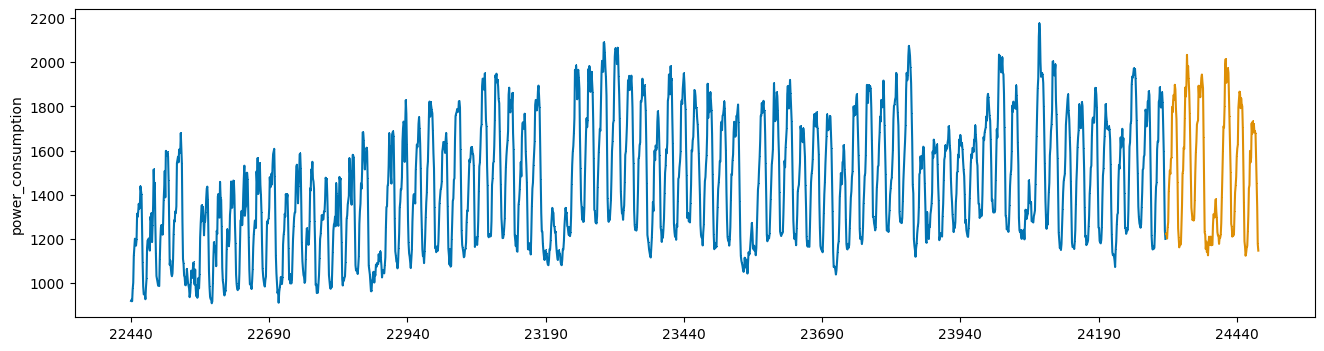

In [21]:
print('train data shape\nx:{}, y:{}'.format(x_train.shape, y_train.shape))

plot_series(y_train, y_valid, markers=[',' , ','])
plt.show()

In [22]:
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100

In [56]:
from lightgbm import LGBMRegressor

In [31]:
model = LGBMRegressor()
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)])

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 10
[LightGBM] [Info] Start training from score 1435.420865


LGBMRegressor()

SMAPE : 2.108611811181992


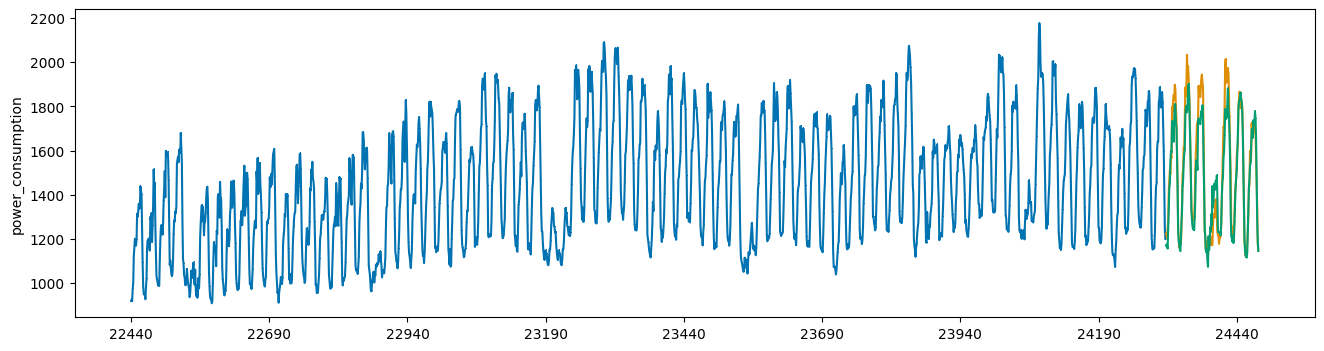

In [34]:
## 주황색이 실제 전력소비량, 초록색이 예측값입니다.
pred = model.predict(x_valid)
pred = pd.Series(pred)
pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(pred), markers=[',' , ',', ','])

print('SMAPE : {}'.format(SMAPE(y_valid, pred)))

## 모델 튜닝

In [62]:
LGBMRegressor??

Init signature:
LGBMRegressor(
    boosting_type: str = 'gbdt',
    num_leaves: int = 31,
    max_depth: int = -1,
    learning_rate: float = 0.1,
    n_estimators: int = 100,
    subsample_for_bin: int = 200000,
    objective: Union[str, Callable[[Optional[numpy.ndarray], numpy.ndarray], Tuple[numpy.ndarray, numpy.ndarray]], Callable[[Optional[numpy.ndarray], numpy.ndarray, Optional[numpy.ndarray]], Tuple[numpy.ndarray, numpy.ndarray]], Callable[[Optional[numpy.ndarray], numpy.ndarray, Optional[numpy.ndarray], Optional[numpy.ndarray]], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = None,
    class_weight: Union[Dict, str, NoneType] = None,
    min_split_gain: float = 0.0,
    min_child_weight: float = 0.001,
    min_child_samples: int = 20,
    subsample: float = 1.0,
    subsample_freq: int = 0,
    colsample_bytree: float = 1.0,
    reg_alpha: float = 0.0,
    reg_lambda: float = 0.0,
    random_state: Union[int, numpy.random.mtrand.RandomState, NoneType] = None,
    n_jobs: Opti

In [63]:
# lgbm parameter tuning
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

def objective(trial: Trial) -> float:

    params_lgb = {
        "random_state": 42,
        "verbosity": -1,
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.1),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "objective": "regression",
        "metric": "rmse",
        "max_depth": trial.suggest_int("max_depth", 1, 30),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 0.6),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 2, 30),
    }
    
    model = LGBMRegressor(**params_lgb)
    model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks=[lgb.early_stopping(stopping_rounds=100)]
        )
    lgb_pred = model.predict(x_valid)
    smape = SMAPE(y_valid, lgb_pred)
    return smape

sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="minimize",
    sampler=sampler,
)

study.optimize(objective, n_trials=500)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-14 15:52:03,659] A new study created in memory with name: lgbm_parameter_opt
[I 2023-08-14 15:52:03,754] Trial 0 finished with value: 27.25680497153392 and parameters: {'learning_rate': 0.06872700594236814, 'n_estimators': 956, 'max_depth': 22, 'num_leaves': 154, 'colsample_bytree': 0.2624074561769746, 'subsample': 0.40919616423534183, 'subsample_freq': 1, 'min_child_samples': 27}. Best is trial 0 with value: 27.25680497153392.
[I 2023-08-14 15:52:03,780] Trial 1 finished with value: 28.532258619976012 and parameters: {'learning_rate': 0.08005575058716044, 'n_estimators': 737, 'max_depth': 1, 'num_leaves': 249, 'colsample_bytree': 0.5329770563201687, 'subsample': 0.44863737747479326, 'subsample_freq': 2, 'min_child_samples': 7}. Best is trial 0 with value: 27.25680497153392.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[86]	training's mape: 0.0840071	training's rmse: 71.7307	valid_1's mape: 0.416361	valid_1's rmse: 649.966
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's mape: 0.432888	training's rmse: 298.383	valid_1's mape: 0.438511	valid_1's rmse: 736.169
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:04,002] Trial 2 finished with value: 28.698406020621892 and parameters: {'learning_rate': 0.0652121121479769, 'n_estimators': 572, 'max_depth': 13, 'num_leaves': 76, 'colsample_bytree': 0.44474115788895174, 'subsample': 0.3976457024564293, 'subsample_freq': 3, 'min_child_samples': 12}. Best is trial 0 with value: 27.25680497153392.
[I 2023-08-14 15:52:04,067] Trial 3 finished with value: 28.45876393635085 and parameters: {'learning_rate': 0.0728034992108518, 'n_estimators': 807, 'max_depth': 6, 'num_leaves': 133, 'colsample_bytree': 0.43696582754481694, 'subsample': 0.3325152889039984, 'subsample_freq': 7, 'min_child_samples': 6}. Best is trial 0 with value: 27.25680497153392.


Early stopping, best iteration is:
[231]	training's mape: 0.0345619	training's rmse: 33.7935	valid_1's mape: 0.431513	valid_1's rmse: 669.583
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[43]	training's mape: 0.0923061	training's rmse: 75.3059	valid_1's mape: 0.432144	valid_1's rmse: 671.968
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84]	training's mape: 0.0921058	training's rmse: 76.9867	valid_1's mape: 0.41751	valid_1's rmse: 650.98


[I 2023-08-14 15:52:04,152] Trial 4 finished with value: 27.2544887642045 and parameters: {'learning_rate': 0.05325257964926398, 'n_estimators': 954, 'max_depth': 29, 'num_leaves': 208, 'colsample_bytree': 0.3218455076693483, 'subsample': 0.3683704798044687, 'subsample_freq': 7, 'min_child_samples': 14}. Best is trial 4 with value: 27.2544887642045.
[I 2023-08-14 15:52:04,206] Trial 5 finished with value: 27.83041983644825 and parameters: {'learning_rate': 0.05610191174223894, 'n_estimators': 546, 'max_depth': 2, 'num_leaves': 233, 'colsample_bytree': 0.3035119926400068, 'subsample': 0.7637655990477874, 'subsample_freq': 4, 'min_child_samples': 17}. Best is trial 4 with value: 27.2544887642045.
[I 2023-08-14 15:52:04,310] Trial 6 finished with value: 28.286250794814123 and parameters: {'learning_rate': 0.07733551396716398, 'n_estimators': 266, 'max_depth': 30, 'num_leaves': 199, 'colsample_bytree': 0.5757995766256756, 'subsample': 0.9263791452993542, 'subsample_freq': 6, 'min_child_sam

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[222]	training's mape: 0.0814291	training's rmse: 73.1114	valid_1's mape: 0.421707	valid_1's rmse: 654.297
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	training's mape: 0.0509194	training's rmse: 47.6413	valid_1's mape: 0.425522	valid_1's rmse: 661.696
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[252]	training's mape: 0.0693749	training's rmse: 64.7975	valid_1's mape: 0.433639	valid_1's rmse: 671.262


[I 2023-08-14 15:52:04,415] Trial 8 finished with value: 28.175668004442993 and parameters: {'learning_rate': 0.06404672548436904, 'n_estimators': 588, 'max_depth': 5, 'num_leaves': 206, 'colsample_bytree': 0.22982025747190835, 'subsample': 0.9908208556203622, 'subsample_freq': 8, 'min_child_samples': 7}. Best is trial 4 with value: 27.2544887642045.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	training's mape: 0.106959	training's rmse: 88.5385	valid_1's mape: 0.429847	valid_1's rmse: 668.096
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:04,599] Trial 9 finished with value: 27.89908437004065 and parameters: {'learning_rate': 0.05027610585618012, 'n_estimators': 834, 'max_depth': 22, 'num_leaves': 187, 'colsample_bytree': 0.5085081386743783, 'subsample': 0.35183125621386324, 'subsample_freq': 4, 'min_child_samples': 5}. Best is trial 4 with value: 27.2544887642045.
[I 2023-08-14 15:52:04,655] Trial 10 finished with value: 27.34028931343949 and parameters: {'learning_rate': 0.09280447462707023, 'n_estimators': 105, 'max_depth': 30, 'num_leaves': 6, 'colsample_bytree': 0.34907353484081194, 'subsample': 0.589009807278857, 'subsample_freq': 10, 'min_child_samples': 21}. Best is trial 4 with value: 27.2544887642045.
[I 2023-08-14 15:52:04,755] Trial 11 finished with value: 28.154245211433516 and parameters: {'learning_rate': 0.06039256080877499, 'n_estimators': 997, 'max_depth': 23, 'num_leaves': 152, 'colsample_bytree': 0.20855821935659888, 'subsample': 0.5474135038949431, 'subsample_freq': 1, 'min_child

Early stopping, best iteration is:
[69]	training's mape: 0.0575751	training's rmse: 50.2947	valid_1's mape: 0.423438	valid_1's rmse: 657.724
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[53]	training's mape: 0.108374	training's rmse: 88.5819	valid_1's mape: 0.418133	valid_1's rmse: 651.892
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	training's mape: 0.115213	training's rmse: 93.9037	valid_1's mape: 0.429966	valid_1's rmse: 668.945


[I 2023-08-14 15:52:04,843] Trial 12 finished with value: 27.011428355974747 and parameters: {'learning_rate': 0.06885088523135915, 'n_estimators': 999, 'max_depth': 24, 'num_leaves': 165, 'colsample_bytree': 0.28400999036835417, 'subsample': 0.30651780889839714, 'subsample_freq': 5, 'min_child_samples': 23}. Best is trial 12 with value: 27.011428355974747.
[I 2023-08-14 15:52:04,947] Trial 13 finished with value: 26.91520067403071 and parameters: {'learning_rate': 0.05795398214668247, 'n_estimators': 898, 'max_depth': 26, 'num_leaves': 89, 'colsample_bytree': 0.29639921113426004, 'subsample': 0.3020936681512906, 'subsample_freq': 6, 'min_child_samples': 22}. Best is trial 13 with value: 26.91520067403071.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[76]	training's mape: 0.0911516	training's rmse: 76.7694	valid_1's mape: 0.413529	valid_1's rmse: 643.974
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[86]	training's mape: 0.0987547	training's rmse: 81.6073	valid_1's mape: 0.41333	valid_1's rmse: 644.336
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:05,044] Trial 14 finished with value: 26.74148340140573 and parameters: {'learning_rate': 0.06097178194521654, 'n_estimators': 712, 'max_depth': 18, 'num_leaves': 87, 'colsample_bytree': 0.27204200716762206, 'subsample': 0.30463754198795295, 'subsample_freq': 5, 'min_child_samples': 22}. Best is trial 14 with value: 26.74148340140573.
[I 2023-08-14 15:52:05,163] Trial 15 finished with value: 28.16097109658123 and parameters: {'learning_rate': 0.059617993929419785, 'n_estimators': 695, 'max_depth': 15, 'num_leaves': 77, 'colsample_bytree': 0.2476363904991625, 'subsample': 0.4981289230614936, 'subsample_freq': 6, 'min_child_samples': 21}. Best is trial 14 with value: 26.74148340140573.


Early stopping, best iteration is:
[55]	training's mape: 0.125941	training's rmse: 98.8459	valid_1's mape: 0.4128	valid_1's rmse: 646.116
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[103]	training's mape: 0.105021	training's rmse: 87.1709	valid_1's mape: 0.42943	valid_1's rmse: 668.143
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[69]	training's mape: 0.13784	training's rmse: 107.267	valid_1's mape: 0.429297	valid_1's rmse: 670.125


[I 2023-08-14 15:52:05,256] Trial 16 finished with value: 28.004764599160254 and parameters: {'learning_rate': 0.05886781125458535, 'n_estimators': 833, 'max_depth': 18, 'num_leaves': 35, 'colsample_bytree': 0.20288060956639664, 'subsample': 0.3159061859814953, 'subsample_freq': 4, 'min_child_samples': 24}. Best is trial 14 with value: 26.74148340140573.
[I 2023-08-14 15:52:05,400] Trial 17 finished with value: 27.02851265950611 and parameters: {'learning_rate': 0.05005035426329522, 'n_estimators': 451, 'max_depth': 10, 'num_leaves': 106, 'colsample_bytree': 0.27711994419444286, 'subsample': 0.6390261129463759, 'subsample_freq': 5, 'min_child_samples': 17}. Best is trial 14 with value: 26.74148340140573.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[86]	training's mape: 0.08904	training's rmse: 73.1634	valid_1's mape: 0.415181	valid_1's rmse: 647.712
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[43]	training's mape: 0.107884	training's rmse: 84.9663	valid_1's mape: 0.432968	valid_1's rmse: 674.692


[I 2023-08-14 15:52:05,512] Trial 18 finished with value: 28.449781479687342 and parameters: {'learning_rate': 0.06331445006802419, 'n_estimators': 681, 'max_depth': 18, 'num_leaves': 44, 'colsample_bytree': 0.374439933428912, 'subsample': 0.4416285541391074, 'subsample_freq': 7, 'min_child_samples': 19}. Best is trial 14 with value: 26.74148340140573.
[I 2023-08-14 15:52:05,625] Trial 19 finished with value: 27.026528137997214 and parameters: {'learning_rate': 0.055070048883196346, 'n_estimators': 424, 'max_depth': 27, 'num_leaves': 112, 'colsample_bytree': 0.315427674327831, 'subsample': 0.40445593804836366, 'subsample_freq': 8, 'min_child_samples': 25}. Best is trial 14 with value: 26.74148340140573.
[I 2023-08-14 15:52:05,728] Trial 20 finished with value: 26.833080412628345 and parameters: {'learning_rate': 0.058705215728083654, 'n_estimators': 867, 'max_depth': 19, 'num_leaves': 53, 'colsample_bytree': 0.2541261528892598, 'subsample': 0.5119989534258751, 'subsample_freq': 3, 'min

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[81]	training's mape: 0.0982511	training's rmse: 81.4223	valid_1's mape: 0.414374	valid_1's rmse: 646.701
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.12076	training's rmse: 93.3096	valid_1's mape: 0.413998	valid_1's rmse: 648.637
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:05,846] Trial 21 finished with value: 28.103105164926106 and parameters: {'learning_rate': 0.05938694734715762, 'n_estimators': 882, 'max_depth': 19, 'num_leaves': 48, 'colsample_bytree': 0.2449112246196851, 'subsample': 0.3046908046259687, 'subsample_freq': 2, 'min_child_samples': 19}. Best is trial 14 with value: 26.74148340140573.
[I 2023-08-14 15:52:05,957] Trial 22 finished with value: 26.847755553027792 and parameters: {'learning_rate': 0.05693849697152994, 'n_estimators': 754, 'max_depth': 12, 'num_leaves': 99, 'colsample_bytree': 0.2800767614182706, 'subsample': 0.4895324897510357, 'subsample_freq': 3, 'min_child_samples': 22}. Best is trial 14 with value: 26.74148340140573.


Early stopping, best iteration is:
[103]	training's mape: 0.111499	training's rmse: 91.5541	valid_1's mape: 0.428788	valid_1's rmse: 667.666
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.132381	training's rmse: 100.43	valid_1's mape: 0.414741	valid_1's rmse: 650.762
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:06,059] Trial 23 finished with value: 26.928077039443714 and parameters: {'learning_rate': 0.06330581474193832, 'n_estimators': 749, 'max_depth': 12, 'num_leaves': 61, 'colsample_bytree': 0.2631513802089006, 'subsample': 0.5140495334396918, 'subsample_freq': 3, 'min_child_samples': 26}. Best is trial 14 with value: 26.74148340140573.
[I 2023-08-14 15:52:06,162] Trial 24 finished with value: 27.95031200430004 and parameters: {'learning_rate': 0.052771937518210146, 'n_estimators': 638, 'max_depth': 10, 'num_leaves': 16, 'colsample_bytree': 0.22825724573682313, 'subsample': 0.574527203351562, 'subsample_freq': 3, 'min_child_samples': 30}. Best is trial 14 with value: 26.74148340140573.


Early stopping, best iteration is:
[52]	training's mape: 0.122683	training's rmse: 94.7844	valid_1's mape: 0.415029	valid_1's rmse: 649.817
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	training's mape: 0.126664	training's rmse: 101.316	valid_1's mape: 0.427933	valid_1's rmse: 667.433
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:06,388] Trial 25 finished with value: 27.2834789905837 and parameters: {'learning_rate': 0.05619291446144548, 'n_estimators': 781, 'max_depth': 16, 'num_leaves': 113, 'colsample_bytree': 0.3241178483479614, 'subsample': 0.45546078802213885, 'subsample_freq': 2, 'min_child_samples': 2}. Best is trial 14 with value: 26.74148340140573.
[I 2023-08-14 15:52:06,477] Trial 26 finished with value: 26.99007128886079 and parameters: {'learning_rate': 0.06867310173361792, 'n_estimators': 641, 'max_depth': 20, 'num_leaves': 24, 'colsample_bytree': 0.2748079675130212, 'subsample': 0.527353384713078, 'subsample_freq': 5, 'min_child_samples': 15}. Best is trial 14 with value: 26.74148340140573.


Early stopping, best iteration is:
[84]	training's mape: 0.0589979	training's rmse: 49.1244	valid_1's mape: 0.418526	valid_1's rmse: 653.516
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.105783	training's rmse: 84.8204	valid_1's mape: 0.414995	valid_1's rmse: 647.229
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:06,590] Trial 27 finished with value: 28.09034900509054 and parameters: {'learning_rate': 0.06130733576552334, 'n_estimators': 488, 'max_depth': 15, 'num_leaves': 65, 'colsample_bytree': 0.200269996609623, 'subsample': 0.37747831069554993, 'subsample_freq': 4, 'min_child_samples': 19}. Best is trial 14 with value: 26.74148340140573.
[I 2023-08-14 15:52:06,713] Trial 28 finished with value: 27.075397723565665 and parameters: {'learning_rate': 0.05017010362207876, 'n_estimators': 887, 'max_depth': 8, 'num_leaves': 130, 'colsample_bytree': 0.25270828724521266, 'subsample': 0.626941579689397, 'subsample_freq': 3, 'min_child_samples': 24}. Best is trial 14 with value: 26.74148340140573.


Early stopping, best iteration is:
[69]	training's mape: 0.128997	training's rmse: 101.512	valid_1's mape: 0.430216	valid_1's rmse: 670.843
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[86]	training's mape: 0.0965832	training's rmse: 78.906	valid_1's mape: 0.41561	valid_1's rmse: 648.366
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:06,806] Trial 29 finished with value: 26.841587150308797 and parameters: {'learning_rate': 0.06788802179517096, 'n_estimators': 728, 'max_depth': 21, 'num_leaves': 92, 'colsample_bytree': 0.2849381491609629, 'subsample': 0.42651702424749555, 'subsample_freq': 2, 'min_child_samples': 27}. Best is trial 14 with value: 26.74148340140573.
[I 2023-08-14 15:52:06,904] Trial 30 finished with value: 27.043113461653096 and parameters: {'learning_rate': 0.06740011607720378, 'n_estimators': 701, 'max_depth': 20, 'num_leaves': 62, 'colsample_bytree': 0.33638500163874463, 'subsample': 0.4246401776987007, 'subsample_freq': 1, 'min_child_samples': 27}. Best is trial 14 with value: 26.74148340140573.


Early stopping, best iteration is:
[52]	training's mape: 0.119405	training's rmse: 93.7999	valid_1's mape: 0.413512	valid_1's rmse: 646.783
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.11848	training's rmse: 93.2046	valid_1's mape: 0.416198	valid_1's rmse: 650.909
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.123257	training's rmse: 95.3699	valid_1's mape: 0.414257	valid_1's rmse: 648.436


[I 2023-08-14 15:52:07,002] Trial 31 finished with value: 26.84332944058764 and parameters: {'learning_rate': 0.061832087013894546, 'n_estimators': 771, 'max_depth': 17, 'num_leaves': 98, 'colsample_bytree': 0.2969175432756711, 'subsample': 0.46989575189649024, 'subsample_freq': 2, 'min_child_samples': 21}. Best is trial 14 with value: 26.74148340140573.
[I 2023-08-14 15:52:07,099] Trial 32 finished with value: 27.157169370985336 and parameters: {'learning_rate': 0.07175467504734512, 'n_estimators': 921, 'max_depth': 21, 'num_leaves': 142, 'colsample_bytree': 0.30243918434465183, 'subsample': 0.3751672785318505, 'subsample_freq': 1, 'min_child_samples': 26}. Best is trial 14 with value: 26.74148340140573.
[I 2023-08-14 15:52:07,213] Trial 33 finished with value: 26.868722989683796 and parameters: {'learning_rate': 0.0654191419543095, 'n_estimators': 839, 'max_depth': 17, 'num_leaves': 96, 'colsample_bytree': 0.2653436588286191, 'subsample': 0.44734846502831854, 'subsample_freq': 2, 'mi

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.109224	training's rmse: 88.1076	valid_1's mape: 0.416716	valid_1's rmse: 651.472
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[51]	training's mape: 0.119743	training's rmse: 93.1724	valid_1's mape: 0.414267	valid_1's rmse: 648.273
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:07,325] Trial 34 finished with value: 28.158986262075548 and parameters: {'learning_rate': 0.062087845657615194, 'n_estimators': 720, 'max_depth': 25, 'num_leaves': 119, 'colsample_bytree': 0.3737631716615988, 'subsample': 0.40992395341848437, 'subsample_freq': 2, 'min_child_samples': 17}. Best is trial 14 with value: 26.74148340140573.
[I 2023-08-14 15:52:07,439] Trial 35 finished with value: 27.20998338795166 and parameters: {'learning_rate': 0.06616404187424099, 'n_estimators': 628, 'max_depth': 22, 'num_leaves': 71, 'colsample_bytree': 0.2981910134499266, 'subsample': 0.36193119807027024, 'subsample_freq': 1, 'min_child_samples': 24}. Best is trial 14 with value: 26.74148340140573.


Early stopping, best iteration is:
[36]	training's mape: 0.131311	training's rmse: 98.4461	valid_1's mape: 0.431035	valid_1's rmse: 672.873
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[81]	training's mape: 0.088132	training's rmse: 74.466	valid_1's mape: 0.415835	valid_1's rmse: 648.91
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:07,543] Trial 36 finished with value: 28.254150561056434 and parameters: {'learning_rate': 0.07056951795670537, 'n_estimators': 791, 'max_depth': 14, 'num_leaves': 51, 'colsample_bytree': 0.22676946123720887, 'subsample': 0.46216394267487276, 'subsample_freq': 3, 'min_child_samples': 28}. Best is trial 14 with value: 26.74148340140573.
[I 2023-08-14 15:52:07,671] Trial 37 finished with value: 26.60207105878314 and parameters: {'learning_rate': 0.07512669103365402, 'n_estimators': 850, 'max_depth': 17, 'num_leaves': 86, 'colsample_bytree': 0.31692848653578765, 'subsample': 0.40070424487656875, 'subsample_freq': 2, 'min_child_samples': 15}. Best is trial 37 with value: 26.60207105878314.


Early stopping, best iteration is:
[103]	training's mape: 0.0999692	training's rmse: 84.2949	valid_1's mape: 0.429897	valid_1's rmse: 669.442
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.102379	training's rmse: 82.5427	valid_1's mape: 0.409789	valid_1's rmse: 641.319
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:07,790] Trial 38 finished with value: 27.12865798129193 and parameters: {'learning_rate': 0.0746082546448766, 'n_estimators': 948, 'max_depth': 19, 'num_leaves': 81, 'colsample_bytree': 0.32454069627322957, 'subsample': 0.3542066944922378, 'subsample_freq': 4, 'min_child_samples': 13}. Best is trial 37 with value: 26.60207105878314.
[I 2023-08-14 15:52:07,893] Trial 39 finished with value: 26.75666449154922 and parameters: {'learning_rate': 0.07688465956288058, 'n_estimators': 534, 'max_depth': 23, 'num_leaves': 31, 'colsample_bytree': 0.251630608436465, 'subsample': 0.39977748614347214, 'subsample_freq': 2, 'min_child_samples': 10}. Best is trial 37 with value: 26.60207105878314.


Early stopping, best iteration is:
[59]	training's mape: 0.0924481	training's rmse: 77.0412	valid_1's mape: 0.41549	valid_1's rmse: 649.057
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.0987619	training's rmse: 80.1309	valid_1's mape: 0.411704	valid_1's rmse: 644.325
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:08,008] Trial 40 finished with value: 28.298155781066658 and parameters: {'learning_rate': 0.0801405113535539, 'n_estimators': 545, 'max_depth': 27, 'num_leaves': 30, 'colsample_bytree': 0.24605275432206286, 'subsample': 0.3969300291090306, 'subsample_freq': 3, 'min_child_samples': 10}. Best is trial 37 with value: 26.60207105878314.
[I 2023-08-14 15:52:08,123] Trial 41 finished with value: 26.737532120429286 and parameters: {'learning_rate': 0.07626858702051736, 'n_estimators': 354, 'max_depth': 23, 'num_leaves': 55, 'colsample_bytree': 0.26652919546475495, 'subsample': 0.336661474809787, 'subsample_freq': 2, 'min_child_samples': 10}. Best is trial 37 with value: 26.60207105878314.


Early stopping, best iteration is:
[92]	training's mape: 0.0910299	training's rmse: 77.5663	valid_1's mape: 0.430357	valid_1's rmse: 670.266
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.0987493	training's rmse: 80.1393	valid_1's mape: 0.411662	valid_1's rmse: 643.643
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:08,249] Trial 42 finished with value: 27.351058338793376 and parameters: {'learning_rate': 0.07854967827262695, 'n_estimators': 329, 'max_depth': 24, 'num_leaves': 40, 'colsample_bytree': 0.2596395150393845, 'subsample': 0.3408948155179009, 'subsample_freq': 1, 'min_child_samples': 10}. Best is trial 37 with value: 26.60207105878314.
[I 2023-08-14 15:52:08,352] Trial 43 finished with value: 28.073867780058492 and parameters: {'learning_rate': 0.07603133568265102, 'n_estimators': 368, 'max_depth': 23, 'num_leaves': 15, 'colsample_bytree': 0.2248793755243593, 'subsample': 0.3479488714071332, 'subsample_freq': 3, 'min_child_samples': 9}. Best is trial 37 with value: 26.60207105878314.


Early stopping, best iteration is:
[67]	training's mape: 0.0785023	training's rmse: 67.3419	valid_1's mape: 0.417805	valid_1's rmse: 650.519
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[103]	training's mape: 0.0958446	training's rmse: 81.5278	valid_1's mape: 0.42778	valid_1's rmse: 665.041
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[69]	training's mape: 0.125751	training's rmse: 101.626	valid_1's mape: 0.430007	valid_1's rmse: 669.243


[I 2023-08-14 15:52:08,443] Trial 44 finished with value: 28.151742511845647 and parameters: {'learning_rate': 0.07424633796320762, 'n_estimators': 242, 'max_depth': 28, 'num_leaves': 6, 'colsample_bytree': 0.24027686658450997, 'subsample': 0.383018389485524, 'subsample_freq': 2, 'min_child_samples': 14}. Best is trial 37 with value: 26.60207105878314.
[I 2023-08-14 15:52:08,589] Trial 45 finished with value: 26.988721495896318 and parameters: {'learning_rate': 0.08061308684135873, 'n_estimators': 179, 'max_depth': 21, 'num_leaves': 54, 'colsample_bytree': 0.26316241922169215, 'subsample': 0.3288182514410403, 'subsample_freq': 1, 'min_child_samples': 8}. Best is trial 37 with value: 26.60207105878314.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[51]	training's mape: 0.0925541	training's rmse: 76.0609	valid_1's mape: 0.414792	valid_1's rmse: 647.989
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:08,784] Trial 46 finished with value: 27.43859230528364 and parameters: {'learning_rate': 0.08183549101589827, 'n_estimators': 520, 'max_depth': 25, 'num_leaves': 234, 'colsample_bytree': 0.3140956957382459, 'subsample': 0.4035418581592961, 'subsample_freq': 4, 'min_child_samples': 5}. Best is trial 37 with value: 26.60207105878314.
[I 2023-08-14 15:52:08,904] Trial 47 finished with value: 28.162134802289362 and parameters: {'learning_rate': 0.08297247250495934, 'n_estimators': 374, 'max_depth': 17, 'num_leaves': 74, 'colsample_bytree': 0.2203477824142122, 'subsample': 0.3348929117977687, 'subsample_freq': 2, 'min_child_samples': 11}. Best is trial 37 with value: 26.60207105878314.


Early stopping, best iteration is:
[52]	training's mape: 0.0781671	training's rmse: 65.699	valid_1's mape: 0.419902	valid_1's rmse: 655.302
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[69]	training's mape: 0.103212	training's rmse: 85.4103	valid_1's mape: 0.42946	valid_1's rmse: 669.085
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:09,018] Trial 48 finished with value: 26.69213217098757 and parameters: {'learning_rate': 0.07274449436699038, 'n_estimators': 436, 'max_depth': 23, 'num_leaves': 24, 'colsample_bytree': 0.2878051763276163, 'subsample': 0.3769017825895276, 'subsample_freq': 5, 'min_child_samples': 15}. Best is trial 37 with value: 26.60207105878314.
[I 2023-08-14 15:52:09,112] Trial 49 finished with value: 27.390598234153014 and parameters: {'learning_rate': 0.07309892273248952, 'n_estimators': 443, 'max_depth': 23, 'num_leaves': 23, 'colsample_bytree': 0.34219869699651245, 'subsample': 0.3043149677083466, 'subsample_freq': 7, 'min_child_samples': 12}. Best is trial 37 with value: 26.60207105878314.


Early stopping, best iteration is:
[52]	training's mape: 0.107674	training's rmse: 86.8873	valid_1's mape: 0.411338	valid_1's rmse: 644.011
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.103969	training's rmse: 85.0449	valid_1's mape: 0.419174	valid_1's rmse: 653.344
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:09,218] Trial 50 finished with value: 26.755392442030125 and parameters: {'learning_rate': 0.07715427430073132, 'n_estimators': 591, 'max_depth': 29, 'num_leaves': 36, 'colsample_bytree': 0.28573484493548945, 'subsample': 0.3748907533925174, 'subsample_freq': 5, 'min_child_samples': 16}. Best is trial 37 with value: 26.60207105878314.
[I 2023-08-14 15:52:09,332] Trial 51 finished with value: 26.69722646679632 and parameters: {'learning_rate': 0.07706551970679291, 'n_estimators': 590, 'max_depth': 28, 'num_leaves': 39, 'colsample_bytree': 0.28982745536438353, 'subsample': 0.37724481455452463, 'subsample_freq': 5, 'min_child_samples': 16}. Best is trial 37 with value: 26.60207105878314.


Early stopping, best iteration is:
[52]	training's mape: 0.101351	training's rmse: 82.8332	valid_1's mape: 0.411738	valid_1's rmse: 644.183
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.101105	training's rmse: 82.6252	valid_1's mape: 0.410899	valid_1's rmse: 643.02
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:09,446] Trial 52 finished with value: 26.797383023239448 and parameters: {'learning_rate': 0.07815654370946518, 'n_estimators': 590, 'max_depth': 29, 'num_leaves': 39, 'colsample_bytree': 0.3096115698366718, 'subsample': 0.36844926932276467, 'subsample_freq': 5, 'min_child_samples': 15}. Best is trial 37 with value: 26.60207105878314.
[I 2023-08-14 15:52:09,527] Trial 53 finished with value: 27.091606591265204 and parameters: {'learning_rate': 0.07529409778693179, 'n_estimators': 496, 'max_depth': 30, 'num_leaves': 14, 'colsample_bytree': 0.29010254620326076, 'subsample': 0.33183406379517244, 'subsample_freq': 6, 'min_child_samples': 16}. Best is trial 37 with value: 26.60207105878314.


Early stopping, best iteration is:
[52]	training's mape: 0.0988791	training's rmse: 81.5215	valid_1's mape: 0.412172	valid_1's rmse: 644.65
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.107519	training's rmse: 87.8941	valid_1's mape: 0.415535	valid_1's rmse: 648.693
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.107568	training's rmse: 86.3261	valid_1's mape: 0.412065	valid_1's rmse: 643.816


[I 2023-08-14 15:52:09,633] Trial 54 finished with value: 26.737190453799975 and parameters: {'learning_rate': 0.07108639392931797, 'n_estimators': 371, 'max_depth': 27, 'num_leaves': 59, 'colsample_bytree': 0.2761955433531973, 'subsample': 0.4292073173401748, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 37 with value: 26.60207105878314.
[I 2023-08-14 15:52:09,748] Trial 55 finished with value: 26.990360535711005 and parameters: {'learning_rate': 0.0702901605196209, 'n_estimators': 312, 'max_depth': 26, 'num_leaves': 84, 'colsample_bytree': 0.27221677946887646, 'subsample': 0.4293910697697402, 'subsample_freq': 6, 'min_child_samples': 17}. Best is trial 37 with value: 26.60207105878314.
[I 2023-08-14 15:52:09,857] Trial 56 finished with value: 26.971154358138627 and parameters: {'learning_rate': 0.07144135621317581, 'n_estimators': 422, 'max_depth': 28, 'num_leaves': 67, 'colsample_bytree': 0.33030289744377034, 'subsample': 0.32974896530681613, 'subsample_freq': 5, 'min

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.102827	training's rmse: 83.6107	valid_1's mape: 0.414829	valid_1's rmse: 647.384
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[82]	training's mape: 0.083062	training's rmse: 70.8125	valid_1's mape: 0.412708	valid_1's rmse: 643.662


[I 2023-08-14 15:52:09,983] Trial 57 finished with value: 27.24832623951433 and parameters: {'learning_rate': 0.07321878428099907, 'n_estimators': 384, 'max_depth': 25, 'num_leaves': 51, 'colsample_bytree': 0.30986087832888615, 'subsample': 0.4766423787586266, 'subsample_freq': 10, 'min_child_samples': 15}. Best is trial 37 with value: 26.60207105878314.
[I 2023-08-14 15:52:10,087] Trial 58 finished with value: 26.98018172052663 and parameters: {'learning_rate': 0.06917392479296523, 'n_estimators': 259, 'max_depth': 27, 'num_leaves': 60, 'colsample_bytree': 0.27794757353094657, 'subsample': 0.30420929621456044, 'subsample_freq': 6, 'min_child_samples': 13}. Best is trial 37 with value: 26.60207105878314.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.0959681	training's rmse: 78.5288	valid_1's mape: 0.417531	valid_1's rmse: 651.912
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[47]	training's mape: 0.119428	training's rmse: 93.8122	valid_1's mape: 0.415486	valid_1's rmse: 649.94


[I 2023-08-14 15:52:10,194] Trial 59 finished with value: 28.391602535362292 and parameters: {'learning_rate': 0.07158621908349244, 'n_estimators': 208, 'max_depth': 24, 'num_leaves': 77, 'colsample_bytree': 0.35320184782656966, 'subsample': 0.3557377847648903, 'subsample_freq': 8, 'min_child_samples': 18}. Best is trial 37 with value: 26.60207105878314.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[46]	training's mape: 0.0952435	training's rmse: 78.5892	valid_1's mape: 0.430956	valid_1's rmse: 670.676
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.0894953	training's rmse: 74.4574	valid_1's mape: 0.416516	valid_1's rmse: 650.014


[I 2023-08-14 15:52:10,342] Trial 60 finished with value: 27.20379511435645 and parameters: {'learning_rate': 0.08384908435118395, 'n_estimators': 330, 'max_depth': 28, 'num_leaves': 184, 'colsample_bytree': 0.31718005874793403, 'subsample': 0.4440766604637118, 'subsample_freq': 4, 'min_child_samples': 13}. Best is trial 37 with value: 26.60207105878314.
[I 2023-08-14 15:52:10,457] Trial 61 finished with value: 26.904646498790658 and parameters: {'learning_rate': 0.07661848932774717, 'n_estimators': 582, 'max_depth': 30, 'num_leaves': 41, 'colsample_bytree': 0.29085904089558057, 'subsample': 0.37041584776430925, 'subsample_freq': 5, 'min_child_samples': 16}. Best is trial 37 with value: 26.60207105878314.
[I 2023-08-14 15:52:10,570] Trial 62 finished with value: 26.643628696943704 and parameters: {'learning_rate': 0.07414038012926763, 'n_estimators': 658, 'max_depth': 29, 'num_leaves': 27, 'colsample_bytree': 0.2869167596961958, 'subsample': 0.38622772328371363, 'subsample_freq': 5, 'm

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	training's mape: 0.10387	training's rmse: 84.3772	valid_1's mape: 0.41362	valid_1's rmse: 646.561
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.0995905	training's rmse: 81.888	valid_1's mape: 0.410351	valid_1's rmse: 641.048


[I 2023-08-14 15:52:10,650] Trial 63 finished with value: 27.431478375261413 and parameters: {'learning_rate': 0.07366701538146998, 'n_estimators': 485, 'max_depth': 26, 'num_leaves': 3, 'colsample_bytree': 0.2698538606929393, 'subsample': 0.39250955814845806, 'subsample_freq': 5, 'min_child_samples': 14}. Best is trial 37 with value: 26.60207105878314.
[I 2023-08-14 15:52:10,760] Trial 64 finished with value: 27.006422890930242 and parameters: {'learning_rate': 0.07481027651739754, 'n_estimators': 673, 'max_depth': 29, 'num_leaves': 31, 'colsample_bytree': 0.30063221320495653, 'subsample': 0.41937576884709826, 'subsample_freq': 7, 'min_child_samples': 12}. Best is trial 37 with value: 26.60207105878314.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[86]	training's mape: 0.110891	training's rmse: 93.6258	valid_1's mape: 0.419293	valid_1's rmse: 652.001
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[42]	training's mape: 0.118473	training's rmse: 91.9609	valid_1's mape: 0.415817	valid_1's rmse: 650.705


[I 2023-08-14 15:52:10,877] Trial 65 finished with value: 27.113057213754676 and parameters: {'learning_rate': 0.0787519743853688, 'n_estimators': 409, 'max_depth': 27, 'num_leaves': 23, 'colsample_bytree': 0.27936104586767047, 'subsample': 0.3301499755420111, 'subsample_freq': 4, 'min_child_samples': 15}. Best is trial 37 with value: 26.60207105878314.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[47]	training's mape: 0.109417	training's rmse: 88.4217	valid_1's mape: 0.415952	valid_1's rmse: 651.075
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[103]	training's mape: 0.0986198	training's rmse: 82.9969	valid_1's mape: 0.429015	valid_1's rmse: 667.218


[I 2023-08-14 15:52:11,013] Trial 66 finished with value: 28.15074576114459 and parameters: {'learning_rate': 0.06687547076606348, 'n_estimators': 616, 'max_depth': 14, 'num_leaves': 45, 'colsample_bytree': 0.23966827163023707, 'subsample': 0.4306920302932126, 'subsample_freq': 6, 'min_child_samples': 18}. Best is trial 37 with value: 26.60207105878314.
[I 2023-08-14 15:52:11,145] Trial 67 finished with value: 26.56827303285346 and parameters: {'learning_rate': 0.06494223718129703, 'n_estimators': 301, 'max_depth': 18, 'num_leaves': 58, 'colsample_bytree': 0.3341532827759282, 'subsample': 0.3911909482174305, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 67 with value: 26.56827303285346.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	training's mape: 0.117312	training's rmse: 92.5725	valid_1's mape: 0.410369	valid_1's rmse: 642.426
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.109531	training's rmse: 87.2909	valid_1's mape: 0.412878	valid_1's rmse: 645.89


[I 2023-08-14 15:52:11,272] Trial 68 finished with value: 26.796832492548646 and parameters: {'learning_rate': 0.06952807987167091, 'n_estimators': 314, 'max_depth': 26, 'num_leaves': 58, 'colsample_bytree': 0.33848364067121384, 'subsample': 0.48044785474359597, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 67 with value: 26.56827303285346.
[I 2023-08-14 15:52:11,367] Trial 69 finished with value: 27.198912031771194 and parameters: {'learning_rate': 0.0726857471595609, 'n_estimators': 290, 'max_depth': 4, 'num_leaves': 21, 'colsample_bytree': 0.3220038362850275, 'subsample': 0.3881995108676878, 'subsample_freq': 4, 'min_child_samples': 7}. Best is trial 67 with value: 26.56827303285346.
[I 2023-08-14 15:52:11,461] Trial 70 finished with value: 27.208869314455196 and parameters: {'learning_rate': 0.07565488309243494, 'n_estimators': 392, 'max_depth': 16, 'num_leaves': 12, 'colsample_bytree': 0.3070296985153884, 'subsample': 0.45655924586098917, 'subsample_freq': 7, 'min_c

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[73]	training's mape: 0.090427	training's rmse: 76.9157	valid_1's mape: 0.415911	valid_1's rmse: 646.825
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.110963	training's rmse: 89.3939	valid_1's mape: 0.417417	valid_1's rmse: 652.35
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:11,574] Trial 71 finished with value: 26.61646232262035 and parameters: {'learning_rate': 0.06555707449853973, 'n_estimators': 353, 'max_depth': 18, 'num_leaves': 69, 'colsample_bytree': 0.29183847177366734, 'subsample': 0.3541701784047499, 'subsample_freq': 5, 'min_child_samples': 21}. Best is trial 67 with value: 26.56827303285346.
[I 2023-08-14 15:52:11,691] Trial 72 finished with value: 26.85926049304048 and parameters: {'learning_rate': 0.06455989870542408, 'n_estimators': 361, 'max_depth': 20, 'num_leaves': 69, 'colsample_bytree': 0.2909126423628309, 'subsample': 0.420153516206027, 'subsample_freq': 5, 'min_child_samples': 23}. Best is trial 67 with value: 26.56827303285346.


Early stopping, best iteration is:
[51]	training's mape: 0.122503	training's rmse: 95.7206	valid_1's mape: 0.411105	valid_1's rmse: 644.66
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.121086	training's rmse: 94.7329	valid_1's mape: 0.413875	valid_1's rmse: 647.252
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:11,815] Trial 73 finished with value: 27.179147357058515 and parameters: {'learning_rate': 0.06797754183575919, 'n_estimators': 463, 'max_depth': 18, 'num_leaves': 48, 'colsample_bytree': 0.3286315224510369, 'subsample': 0.40269055496734835, 'subsample_freq': 4, 'min_child_samples': 19}. Best is trial 67 with value: 26.56827303285346.
[I 2023-08-14 15:52:11,921] Trial 74 finished with value: 26.92747603704887 and parameters: {'learning_rate': 0.06546529201717113, 'n_estimators': 340, 'max_depth': 22, 'num_leaves': 56, 'colsample_bytree': 0.3000539977971026, 'subsample': 0.3553319780800178, 'subsample_freq': 6, 'min_child_samples': 17}. Best is trial 67 with value: 26.56827303285346.


Early stopping, best iteration is:
[83]	training's mape: 0.0813005	training's rmse: 69.6685	valid_1's mape: 0.415267	valid_1's rmse: 647.019
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.112594	training's rmse: 89.7423	valid_1's mape: 0.414321	valid_1's rmse: 647.101
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.107376	training's rmse: 86.9162	valid_1's mape: 0.414912	valid_1's rmse: 647.585


[I 2023-08-14 15:52:12,024] Trial 75 finished with value: 27.0160325976057 and parameters: {'learning_rate': 0.07029996898877929, 'n_estimators': 233, 'max_depth': 19, 'num_leaves': 106, 'colsample_bytree': 0.28507928056992765, 'subsample': 0.38409113416438434, 'subsample_freq': 6, 'min_child_samples': 21}. Best is trial 67 with value: 26.56827303285346.
[I 2023-08-14 15:52:12,149] Trial 76 finished with value: 26.721943715142547 and parameters: {'learning_rate': 0.07194503186071244, 'n_estimators': 283, 'max_depth': 13, 'num_leaves': 33, 'colsample_bytree': 0.25954913626362863, 'subsample': 0.3557094275690316, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 67 with value: 26.56827303285346.
[I 2023-08-14 15:52:12,253] Trial 77 finished with value: 26.869048243433504 and parameters: {'learning_rate': 0.0672386533385315, 'n_estimators': 117, 'max_depth': 11, 'num_leaves': 32, 'colsample_bytree': 0.25315732570123695, 'subsample': 0.4449015719386996, 'subsample_freq': 5, 'min

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	training's mape: 0.108292	training's rmse: 87.4877	valid_1's mape: 0.41158	valid_1's rmse: 643.638
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[52]	training's mape: 0.115351	training's rmse: 91.2448	valid_1's mape: 0.41385	valid_1's rmse: 647.103


[I 2023-08-14 15:52:12,432] Trial 78 finished with value: 28.857419456867557 and parameters: {'learning_rate': 0.07183974096147559, 'n_estimators': 290, 'max_depth': 12, 'num_leaves': 42, 'colsample_bytree': 0.36512200988587984, 'subsample': 0.4134438538472235, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 67 with value: 26.56827303285346.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[251]	training's mape: 0.0375563	training's rmse: 37.2709	valid_1's mape: 0.43263	valid_1's rmse: 671.698
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:12,554] Trial 79 finished with value: 27.21707852930023 and parameters: {'learning_rate': 0.06897898024930478, 'n_estimators': 179, 'max_depth': 13, 'num_leaves': 28, 'colsample_bytree': 0.3446433613362968, 'subsample': 0.318550939486546, 'subsample_freq': 6, 'min_child_samples': 20}. Best is trial 67 with value: 26.56827303285346.
[I 2023-08-14 15:52:12,677] Trial 80 finished with value: 26.72835343755796 and parameters: {'learning_rate': 0.06607152622671977, 'n_estimators': 662, 'max_depth': 15, 'num_leaves': 64, 'colsample_bytree': 0.3044499456820295, 'subsample': 0.3590286780715748, 'subsample_freq': 5, 'min_child_samples': 14}. Best is trial 67 with value: 26.56827303285346.


Did not meet early stopping. Best iteration is:
[86]	training's mape: 0.0846209	training's rmse: 72.5205	valid_1's mape: 0.415855	valid_1's rmse: 646.8
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.108504	training's rmse: 87.0817	valid_1's mape: 0.411865	valid_1's rmse: 644.419
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:12,796] Trial 81 finished with value: 26.803437375725697 and parameters: {'learning_rate': 0.06635076729880172, 'n_estimators': 673, 'max_depth': 15, 'num_leaves': 89, 'colsample_bytree': 0.3162049985963527, 'subsample': 0.3547162753220402, 'subsample_freq': 5, 'min_child_samples': 14}. Best is trial 67 with value: 26.56827303285346.
[I 2023-08-14 15:52:12,907] Trial 82 finished with value: 26.77036860716779 and parameters: {'learning_rate': 0.06348779300749027, 'n_estimators': 570, 'max_depth': 16, 'num_leaves': 80, 'colsample_bytree': 0.30471923876140383, 'subsample': 0.3741679294251945, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 67 with value: 26.56827303285346.


Early stopping, best iteration is:
[55]	training's mape: 0.108515	training's rmse: 87.2069	valid_1's mape: 0.412763	valid_1's rmse: 645.383
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.121535	training's rmse: 95.4794	valid_1's mape: 0.413071	valid_1's rmse: 647.021
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:13,024] Trial 83 finished with value: 27.04116366442498 and parameters: {'learning_rate': 0.06413585433552084, 'n_estimators': 287, 'max_depth': 17, 'num_leaves': 64, 'colsample_bytree': 0.274727106975377, 'subsample': 0.39633711242764463, 'subsample_freq': 4, 'min_child_samples': 17}. Best is trial 67 with value: 26.56827303285346.
[I 2023-08-14 15:52:13,147] Trial 84 finished with value: 27.128015850707953 and parameters: {'learning_rate': 0.06806189618347225, 'n_estimators': 663, 'max_depth': 14, 'num_leaves': 48, 'colsample_bytree': 0.2936848107608868, 'subsample': 0.3617920688244247, 'subsample_freq': 4, 'min_child_samples': 15}. Best is trial 67 with value: 26.56827303285346.


Early stopping, best iteration is:
[52]	training's mape: 0.117595	training's rmse: 92.1938	valid_1's mape: 0.416279	valid_1's rmse: 651.162
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[63]	training's mape: 0.0941497	training's rmse: 77.8845	valid_1's mape: 0.415512	valid_1's rmse: 648.393
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:13,265] Trial 85 finished with value: 27.040361414891922 and parameters: {'learning_rate': 0.07252294216322176, 'n_estimators': 610, 'max_depth': 10, 'num_leaves': 74, 'colsample_bytree': 0.26327758592494455, 'subsample': 0.3192967568120615, 'subsample_freq': 5, 'min_child_samples': 21}. Best is trial 67 with value: 26.56827303285346.
[I 2023-08-14 15:52:13,365] Trial 86 finished with value: 27.023418204770405 and parameters: {'learning_rate': 0.07445376673762168, 'n_estimators': 651, 'max_depth': 8, 'num_leaves': 10, 'colsample_bytree': 0.2830362119416553, 'subsample': 0.41301721151266185, 'subsample_freq': 9, 'min_child_samples': 13}. Best is trial 67 with value: 26.56827303285346.


Early stopping, best iteration is:
[82]	training's mape: 0.0845161	training's rmse: 71.8964	valid_1's mape: 0.413444	valid_1's rmse: 644.13
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.117251	training's rmse: 93.1616	valid_1's mape: 0.41559	valid_1's rmse: 649.926
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.109633	training's rmse: 88.5864	valid_1's mape: 0.416751	valid_1's rmse: 649.134


[I 2023-08-14 15:52:13,470] Trial 87 finished with value: 27.157890991519746 and parameters: {'learning_rate': 0.07088897340895034, 'n_estimators': 517, 'max_depth': 15, 'num_leaves': 35, 'colsample_bytree': 0.33429002308358163, 'subsample': 0.34535856463567727, 'subsample_freq': 6, 'min_child_samples': 23}. Best is trial 67 with value: 26.56827303285346.
[I 2023-08-14 15:52:13,582] Trial 88 finished with value: 27.0313862748425 and parameters: {'learning_rate': 0.06982903217800461, 'n_estimators': 399, 'max_depth': 18, 'num_leaves': 19, 'colsample_bytree': 0.3202069774308792, 'subsample': 0.38095450998884745, 'subsample_freq': 4, 'min_child_samples': 14}. Best is trial 67 with value: 26.56827303285346.
[I 2023-08-14 15:52:13,703] Trial 89 finished with value: 26.801880230208248 and parameters: {'learning_rate': 0.06585448059147064, 'n_estimators': 450, 'max_depth': 16, 'num_leaves': 27, 'colsample_bytree': 0.2956971429946895, 'subsample': 0.34581261567002675, 'subsample_freq': 5, 'min

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.113011	training's rmse: 90.2889	valid_1's mape: 0.41537	valid_1's rmse: 649.256
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	training's mape: 0.12146	training's rmse: 95.1382	valid_1's mape: 0.413382	valid_1's rmse: 647.058


[I 2023-08-14 15:52:13,829] Trial 90 finished with value: 26.919680586703638 and parameters: {'learning_rate': 0.07378460567651353, 'n_estimators': 736, 'max_depth': 13, 'num_leaves': 65, 'colsample_bytree': 0.25618170082005115, 'subsample': 0.43804739953283284, 'subsample_freq': 6, 'min_child_samples': 20}. Best is trial 67 with value: 26.56827303285346.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	training's mape: 0.0987916	training's rmse: 81.3944	valid_1's mape: 0.413495	valid_1's rmse: 645.64
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[83]	training's mape: 0.073583	training's rmse: 63.979	valid_1's mape: 0.411518	valid_1's rmse: 640.757


[I 2023-08-14 15:52:13,957] Trial 91 finished with value: 26.864613125384096 and parameters: {'learning_rate': 0.07560255092854808, 'n_estimators': 353, 'max_depth': 13, 'num_leaves': 55, 'colsample_bytree': 0.2700717520783534, 'subsample': 0.3175423339349496, 'subsample_freq': 5, 'min_child_samples': 11}. Best is trial 67 with value: 26.56827303285346.
[I 2023-08-14 15:52:14,079] Trial 92 finished with value: 26.694558609020785 and parameters: {'learning_rate': 0.07246532663595645, 'n_estimators': 262, 'max_depth': 14, 'num_leaves': 43, 'colsample_bytree': 0.2630772669905508, 'subsample': 0.3873207314647036, 'subsample_freq': 5, 'min_child_samples': 11}. Best is trial 67 with value: 26.56827303285346.
[I 2023-08-14 15:52:14,201] Trial 93 finished with value: 28.263549700200514 and parameters: {'learning_rate': 0.07218563575521074, 'n_estimators': 256, 'max_depth': 14, 'num_leaves': 46, 'colsample_bytree': 0.2385793111381468, 'subsample': 0.3932808518856996, 'subsample_freq': 5, 'min_c

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.102135	training's rmse: 82.5403	valid_1's mape: 0.411457	valid_1's rmse: 643.845
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	training's mape: 0.10224	training's rmse: 84.9299	valid_1's mape: 0.430523	valid_1's rmse: 669.485


[I 2023-08-14 15:52:14,322] Trial 94 finished with value: 27.132271503844734 and parameters: {'learning_rate': 0.07092855577002369, 'n_estimators': 311, 'max_depth': 11, 'num_leaves': 39, 'colsample_bytree': 0.30832424084518584, 'subsample': 0.36636848762053803, 'subsample_freq': 4, 'min_child_samples': 19}. Best is trial 67 with value: 26.56827303285346.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.110541	training's rmse: 88.3992	valid_1's mape: 0.416531	valid_1's rmse: 650.785
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.102217	training's rmse: 81.5516	valid_1's mape: 0.414479	valid_1's rmse: 648.377


[I 2023-08-14 15:52:14,460] Trial 95 finished with value: 26.91590863599466 and parameters: {'learning_rate': 0.06887241959997434, 'n_estimators': 217, 'max_depth': 17, 'num_leaves': 71, 'colsample_bytree': 0.280643620144236, 'subsample': 0.46336786203289326, 'subsample_freq': 5, 'min_child_samples': 11}. Best is trial 67 with value: 26.56827303285346.
[I 2023-08-14 15:52:14,608] Trial 96 finished with value: 26.790061848889223 and parameters: {'learning_rate': 0.07329878764084671, 'n_estimators': 426, 'max_depth': 28, 'num_leaves': 254, 'colsample_bytree': 0.2585892251176659, 'subsample': 0.41631752225309604, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 67 with value: 26.56827303285346.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.105387	training's rmse: 84.8945	valid_1's mape: 0.412461	valid_1's rmse: 644.427
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.110599	training's rmse: 88.1102	valid_1's mape: 0.416019	valid_1's rmse: 649.929


[I 2023-08-14 15:52:14,742] Trial 97 finished with value: 27.043518595503578 and parameters: {'learning_rate': 0.06271424350558773, 'n_estimators': 697, 'max_depth': 20, 'num_leaves': 60, 'colsample_bytree': 0.2877103312216484, 'subsample': 0.390491214631818, 'subsample_freq': 6, 'min_child_samples': 13}. Best is trial 67 with value: 26.56827303285346.
[I 2023-08-14 15:52:14,859] Trial 98 finished with value: 26.841784390306927 and parameters: {'learning_rate': 0.06458997026339895, 'n_estimators': 813, 'max_depth': 18, 'num_leaves': 36, 'colsample_bytree': 0.27164893032362014, 'subsample': 0.43555073908891123, 'subsample_freq': 5, 'min_child_samples': 16}. Best is trial 67 with value: 26.56827303285346.
[I 2023-08-14 15:52:14,964] Trial 99 finished with value: 27.13228739056982 and parameters: {'learning_rate': 0.0745665584772108, 'n_estimators': 566, 'max_depth': 15, 'num_leaves': 124, 'colsample_bytree': 0.3007043542992731, 'subsample': 0.3421721507514985, 'subsample_freq': 6, 'min_c

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.115424	training's rmse: 90.5847	valid_1's mape: 0.413941	valid_1's rmse: 647.633
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[56]	training's mape: 0.103586	training's rmse: 85.0903	valid_1's mape: 0.415946	valid_1's rmse: 648.123


[I 2023-08-14 15:52:15,106] Trial 100 finished with value: 28.032534651045015 and parameters: {'learning_rate': 0.06698132082804438, 'n_estimators': 345, 'max_depth': 30, 'num_leaves': 51, 'colsample_bytree': 0.24922381458133808, 'subsample': 0.3688044585688323, 'subsample_freq': 4, 'min_child_samples': 12}. Best is trial 67 with value: 26.56827303285346.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[69]	training's mape: 0.117994	training's rmse: 94.5169	valid_1's mape: 0.429177	valid_1's rmse: 669.173
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	training's mape: 0.0990448	training's rmse: 80.807	valid_1's mape: 0.410898	valid_1's rmse: 642.537


[I 2023-08-14 15:52:15,222] Trial 101 finished with value: 26.67049822356109 and parameters: {'learning_rate': 0.0769448693820881, 'n_estimators': 317, 'max_depth': 24, 'num_leaves': 43, 'colsample_bytree': 0.26638498785960996, 'subsample': 0.33921953398296595, 'subsample_freq': 5, 'min_child_samples': 9}. Best is trial 67 with value: 26.56827303285346.
[I 2023-08-14 15:52:15,354] Trial 102 finished with value: 27.0666382316991 and parameters: {'learning_rate': 0.07725755675664206, 'n_estimators': 275, 'max_depth': 29, 'num_leaves': 44, 'colsample_bytree': 0.2635930319724375, 'subsample': 0.3576582246543885, 'subsample_freq': 5, 'min_child_samples': 6}. Best is trial 67 with value: 26.56827303285346.
[I 2023-08-14 15:52:15,458] Trial 103 finished with value: 26.817952961890523 and parameters: {'learning_rate': 0.072389045793053, 'n_estimators': 331, 'max_depth': 25, 'num_leaves': 25, 'colsample_bytree': 0.27680717006297173, 'subsample': 0.40826486118081, 'subsample_freq': 5, 'min_child

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	training's mape: 0.0955582	training's rmse: 78.1649	valid_1's mape: 0.415588	valid_1's rmse: 649.538
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.104906	training's rmse: 84.4801	valid_1's mape: 0.412729	valid_1's rmse: 645.009


[I 2023-08-14 15:52:15,591] Trial 104 finished with value: 26.79659024439121 and parameters: {'learning_rate': 0.07608091997540807, 'n_estimators': 305, 'max_depth': 24, 'num_leaves': 17, 'colsample_bytree': 0.3119581055549943, 'subsample': 0.3802790054940185, 'subsample_freq': 5, 'min_child_samples': 9}. Best is trial 67 with value: 26.56827303285346.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.106162	training's rmse: 86.4645	valid_1's mape: 0.412405	valid_1's rmse: 644.326
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[46]	training's mape: 0.110768	training's rmse: 87.3135	valid_1's mape: 0.417861	valid_1's rmse: 653.709


[I 2023-08-14 15:52:15,761] Trial 105 finished with value: 27.168021627866068 and parameters: {'learning_rate': 0.06997777582723683, 'n_estimators': 195, 'max_depth': 27, 'num_leaves': 159, 'colsample_bytree': 0.2949743951281484, 'subsample': 0.34060764861265386, 'subsample_freq': 4, 'min_child_samples': 8}. Best is trial 67 with value: 26.56827303285346.
[I 2023-08-14 15:52:15,894] Trial 106 finished with value: 27.02779532417442 and parameters: {'learning_rate': 0.06036268259301737, 'n_estimators': 234, 'max_depth': 26, 'num_leaves': 63, 'colsample_bytree': 0.2867755544437885, 'subsample': 0.3177087069722576, 'subsample_freq': 9, 'min_child_samples': 14}. Best is trial 67 with value: 26.56827303285346.
[I 2023-08-14 15:52:16,003] Trial 107 finished with value: 26.95606867829149 and parameters: {'learning_rate': 0.07404921028931277, 'n_estimators': 378, 'max_depth': 21, 'num_leaves': 33, 'colsample_bytree': 0.32872817982682523, 'subsample': 0.40089165333866483, 'subsample_freq': 6, 'm

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.119188	training's rmse: 93.2583	valid_1's mape: 0.416184	valid_1's rmse: 650.476
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.0967985	training's rmse: 79.6341	valid_1's mape: 0.4139	valid_1's rmse: 645.976


[I 2023-08-14 15:52:16,110] Trial 108 finished with value: 26.781393327325286 and parameters: {'learning_rate': 0.0709022096952646, 'n_estimators': 258, 'max_depth': 28, 'num_leaves': 82, 'colsample_bytree': 0.26861409303512884, 'subsample': 0.3706522907818076, 'subsample_freq': 5, 'min_child_samples': 21}. Best is trial 67 with value: 26.56827303285346.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	training's mape: 0.11033	training's rmse: 88.4152	valid_1's mape: 0.41225	valid_1's rmse: 644.963
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[160]	training's mape: 0.0711381	training's rmse: 62.7222	valid_1's mape: 0.429219	valid_1's rmse: 667.281


[I 2023-08-14 15:52:16,276] Trial 109 finished with value: 28.26411123863996 and parameters: {'learning_rate': 0.07481317935382947, 'n_estimators': 989, 'max_depth': 22, 'num_leaves': 140, 'colsample_bytree': 0.23427924712863993, 'subsample': 0.4280290003379867, 'subsample_freq': 5, 'min_child_samples': 15}. Best is trial 67 with value: 26.56827303285346.
[I 2023-08-14 15:52:16,434] Trial 110 finished with value: 28.251943557686076 and parameters: {'learning_rate': 0.07768086219510922, 'n_estimators': 867, 'max_depth': 16, 'num_leaves': 51, 'colsample_bytree': 0.24687712954681584, 'subsample': 0.3849776457810708, 'subsample_freq': 4, 'min_child_samples': 16}. Best is trial 67 with value: 26.56827303285346.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[168]	training's mape: 0.0708326	training's rmse: 62.9832	valid_1's mape: 0.429119	valid_1's rmse: 666.613
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:16,570] Trial 111 finished with value: 26.65598946910889 and parameters: {'learning_rate': 0.07643575165430977, 'n_estimators': 371, 'max_depth': 19, 'num_leaves': 57, 'colsample_bytree': 0.255643332996849, 'subsample': 0.3002638233419241, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 67 with value: 26.56827303285346.
[I 2023-08-14 15:52:16,685] Trial 112 finished with value: 26.669488500920767 and parameters: {'learning_rate': 0.07902318240167164, 'n_estimators': 410, 'max_depth': 17, 'num_leaves': 58, 'colsample_bytree': 0.25769481252076804, 'subsample': 0.30024536617041675, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 67 with value: 26.56827303285346.


Early stopping, best iteration is:
[57]	training's mape: 0.101564	training's rmse: 83.5144	valid_1's mape: 0.410064	valid_1's rmse: 641.172
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	training's mape: 0.0990585	training's rmse: 82.2312	valid_1's mape: 0.410164	valid_1's rmse: 640.788
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:16,816] Trial 113 finished with value: 26.9071357646136 and parameters: {'learning_rate': 0.07829666422273238, 'n_estimators': 465, 'max_depth': 19, 'num_leaves': 39, 'colsample_bytree': 0.25500945888141835, 'subsample': 0.30704163919893324, 'subsample_freq': 5, 'min_child_samples': 2}. Best is trial 67 with value: 26.56827303285346.
[I 2023-08-14 15:52:16,933] Trial 114 finished with value: 26.866154993076524 and parameters: {'learning_rate': 0.07937421726016379, 'n_estimators': 418, 'max_depth': 19, 'num_leaves': 70, 'colsample_bytree': 0.2592201152624145, 'subsample': 0.33002902448368493, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 67 with value: 26.56827303285346.


Early stopping, best iteration is:
[52]	training's mape: 0.0947681	training's rmse: 78.0071	valid_1's mape: 0.413852	valid_1's rmse: 646.712
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	training's mape: 0.102446	training's rmse: 84.4695	valid_1's mape: 0.412643	valid_1's rmse: 644.306
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:17,070] Trial 115 finished with value: 28.283673182427965 and parameters: {'learning_rate': 0.07601022794152347, 'n_estimators': 302, 'max_depth': 17, 'num_leaves': 56, 'colsample_bytree': 0.2440257078943919, 'subsample': 0.3490975694375086, 'subsample_freq': 6, 'min_child_samples': 17}. Best is trial 67 with value: 26.56827303285346.
[I 2023-08-14 15:52:17,178] Trial 116 finished with value: 26.807872345365464 and parameters: {'learning_rate': 0.07534303208303086, 'n_estimators': 754, 'max_depth': 14, 'num_leaves': 76, 'colsample_bytree': 0.28121871057512593, 'subsample': 0.30373797220936233, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 67 with value: 26.56827303285346.


Early stopping, best iteration is:
[103]	training's mape: 0.0949766	training's rmse: 80.4906	valid_1's mape: 0.430118	valid_1's rmse: 668.27
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[56]	training's mape: 0.102988	training's rmse: 84.3962	valid_1's mape: 0.412066	valid_1's rmse: 643.613
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:17,318] Trial 117 finished with value: 28.057119732524338 and parameters: {'learning_rate': 0.07691115470324643, 'n_estimators': 913, 'max_depth': 18, 'num_leaves': 46, 'colsample_bytree': 0.21833246035470555, 'subsample': 0.3277372351097672, 'subsample_freq': 4, 'min_child_samples': 14}. Best is trial 67 with value: 26.56827303285346.
[I 2023-08-14 15:52:17,451] Trial 118 finished with value: 26.82615033250354 and parameters: {'learning_rate': 0.0795565308882277, 'n_estimators': 394, 'max_depth': 20, 'num_leaves': 28, 'colsample_bytree': 0.30249657874222236, 'subsample': 0.30147979582154766, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 67 with value: 26.56827303285346.


Early stopping, best iteration is:
[69]	training's mape: 0.112062	training's rmse: 91.2768	valid_1's mape: 0.428966	valid_1's rmse: 667.586
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[76]	training's mape: 0.0814886	training's rmse: 70.0544	valid_1's mape: 0.410976	valid_1's rmse: 640.61


[I 2023-08-14 15:52:17,598] Trial 119 finished with value: 28.305803231218853 and parameters: {'learning_rate': 0.0775237750469076, 'n_estimators': 326, 'max_depth': 16, 'num_leaves': 67, 'colsample_bytree': 0.2334482259123912, 'subsample': 0.357051887515068, 'subsample_freq': 6, 'min_child_samples': 17}. Best is trial 67 with value: 26.56827303285346.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[166]	training's mape: 0.0731296	training's rmse: 64.8926	valid_1's mape: 0.429383	valid_1's rmse: 667.304
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:17,720] Trial 120 finished with value: 26.95796844503489 and parameters: {'learning_rate': 0.08071980043574858, 'n_estimators': 274, 'max_depth': 17, 'num_leaves': 94, 'colsample_bytree': 0.26684713530096715, 'subsample': 0.31751264623578, 'subsample_freq': 5, 'min_child_samples': 16}. Best is trial 67 with value: 26.56827303285346.
[I 2023-08-14 15:52:17,840] Trial 121 finished with value: 26.764207596923807 and parameters: {'learning_rate': 0.07332700402746234, 'n_estimators': 367, 'max_depth': 12, 'num_leaves': 61, 'colsample_bytree': 0.27565336134094803, 'subsample': 0.34019167067798906, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 67 with value: 26.56827303285346.


Early stopping, best iteration is:
[82]	training's mape: 0.0756193	training's rmse: 65.6125	valid_1's mape: 0.412257	valid_1's rmse: 642.486
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	training's mape: 0.102019	training's rmse: 83.7621	valid_1's mape: 0.411558	valid_1's rmse: 643.072
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:17,960] Trial 122 finished with value: 26.908315599385592 and parameters: {'learning_rate': 0.07232902121001342, 'n_estimators': 433, 'max_depth': 15, 'num_leaves': 51, 'colsample_bytree': 0.29135885047507953, 'subsample': 0.36605438513699273, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 67 with value: 26.56827303285346.
[I 2023-08-14 15:52:18,088] Trial 123 finished with value: 28.262158704567238 and parameters: {'learning_rate': 0.07620345067024425, 'n_estimators': 400, 'max_depth': 13, 'num_leaves': 43, 'colsample_bytree': 0.24959345548896003, 'subsample': 0.33113465532598024, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 67 with value: 26.56827303285346.


Early stopping, best iteration is:
[50]	training's mape: 0.111818	training's rmse: 89.2184	valid_1's mape: 0.414064	valid_1's rmse: 647.848
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's mape: 0.108552	training's rmse: 89.0933	valid_1's mape: 0.430614	valid_1's rmse: 669.758
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:18,210] Trial 124 finished with value: 27.10313129928254 and parameters: {'learning_rate': 0.07410041274418741, 'n_estimators': 342, 'max_depth': 19, 'num_leaves': 87, 'colsample_bytree': 0.3136764944589892, 'subsample': 0.37990379089320186, 'subsample_freq': 4, 'min_child_samples': 18}. Best is trial 67 with value: 26.56827303285346.
[I 2023-08-14 15:52:18,332] Trial 125 finished with value: 26.762521726885957 and parameters: {'learning_rate': 0.0713672334256203, 'n_estimators': 379, 'max_depth': 29, 'num_leaves': 37, 'colsample_bytree': 0.26209915455560684, 'subsample': 0.35523280755047126, 'subsample_freq': 5, 'min_child_samples': 16}. Best is trial 67 with value: 26.56827303285346.


Early stopping, best iteration is:
[57]	training's mape: 0.0988309	training's rmse: 80.9809	valid_1's mape: 0.415403	valid_1's rmse: 648.522
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.103599	training's rmse: 84.6292	valid_1's mape: 0.411986	valid_1's rmse: 643.161


[I 2023-08-14 15:52:18,450] Trial 126 finished with value: 27.06554045066154 and parameters: {'learning_rate': 0.07819297818711857, 'n_estimators': 617, 'max_depth': 18, 'num_leaves': 55, 'colsample_bytree': 0.28583516198650344, 'subsample': 0.4071223637857877, 'subsample_freq': 6, 'min_child_samples': 21}. Best is trial 67 with value: 26.56827303285346.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.0981217	training's rmse: 81.2252	valid_1's mape: 0.414857	valid_1's rmse: 646.645
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.0898694	training's rmse: 74.5044	valid_1's mape: 0.412776	valid_1's rmse: 644.577


[I 2023-08-14 15:52:18,603] Trial 127 finished with value: 26.830607149158002 and parameters: {'learning_rate': 0.07331291155431924, 'n_estimators': 500, 'max_depth': 17, 'num_leaves': 102, 'colsample_bytree': 0.27069446834807925, 'subsample': 0.39219002279680504, 'subsample_freq': 5, 'min_child_samples': 8}. Best is trial 67 with value: 26.56827303285346.
[I 2023-08-14 15:52:18,727] Trial 128 finished with value: 26.75592389864156 and parameters: {'learning_rate': 0.06852450906282335, 'n_estimators': 546, 'max_depth': 22, 'num_leaves': 60, 'colsample_bytree': 0.29637970515891565, 'subsample': 0.3425738040345036, 'subsample_freq': 5, 'min_child_samples': 15}. Best is trial 67 with value: 26.56827303285346.
[I 2023-08-14 15:52:18,831] Trial 129 finished with value: 27.276069869429264 and parameters: {'learning_rate': 0.07515638773304156, 'n_estimators': 293, 'max_depth': 25, 'num_leaves': 22, 'colsample_bytree': 0.3192687881466643, 'subsample': 0.3208002264946842, 'subsample_freq': 4, '

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.107262	training's rmse: 86.8153	valid_1's mape: 0.4121	valid_1's rmse: 643.486
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[63]	training's mape: 0.0960539	training's rmse: 79.698	valid_1's mape: 0.416782	valid_1's rmse: 649.144


[I 2023-08-14 15:52:18,968] Trial 130 finished with value: 27.049262867790592 and parameters: {'learning_rate': 0.06593247297836989, 'n_estimators': 359, 'max_depth': 27, 'num_leaves': 72, 'colsample_bytree': 0.3060733662031723, 'subsample': 0.4522623067244833, 'subsample_freq': 6, 'min_child_samples': 11}. Best is trial 67 with value: 26.56827303285346.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.106944	training's rmse: 85.0638	valid_1's mape: 0.416564	valid_1's rmse: 650.738
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:19,104] Trial 131 finished with value: 26.723392316804105 and parameters: {'learning_rate': 0.07689889499880036, 'n_estimators': 319, 'max_depth': 24, 'num_leaves': 48, 'colsample_bytree': 0.2757700586981412, 'subsample': 0.368045672700282, 'subsample_freq': 2, 'min_child_samples': 10}. Best is trial 67 with value: 26.56827303285346.
[I 2023-08-14 15:52:19,246] Trial 132 finished with value: 26.790196501934094 and parameters: {'learning_rate': 0.07682726026597908, 'n_estimators': 311, 'max_depth': 24, 'num_leaves': 48, 'colsample_bytree': 0.2770643032589806, 'subsample': 0.3729858862479513, 'subsample_freq': 2, 'min_child_samples': 10}. Best is trial 67 with value: 26.56827303285346.


Early stopping, best iteration is:
[52]	training's mape: 0.095978	training's rmse: 78.3555	valid_1's mape: 0.411325	valid_1's rmse: 642.737
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.0956014	training's rmse: 78.0889	valid_1's mape: 0.412193	valid_1's rmse: 644.176


[I 2023-08-14 15:52:19,405] Trial 133 finished with value: 27.034278893640796 and parameters: {'learning_rate': 0.07870752268488547, 'n_estimators': 246, 'max_depth': 23, 'num_leaves': 65, 'colsample_bytree': 0.2549783065436353, 'subsample': 0.418618589444537, 'subsample_freq': 1, 'min_child_samples': 9}. Best is trial 67 with value: 26.56827303285346.
[I 2023-08-14 15:52:19,520] Trial 134 finished with value: 26.780104922763766 and parameters: {'learning_rate': 0.06774870671347516, 'n_estimators': 329, 'max_depth': 14, 'num_leaves': 32, 'colsample_bytree': 0.28653318046498616, 'subsample': 0.36125076611266654, 'subsample_freq': 2, 'min_child_samples': 13}. Best is trial 67 with value: 26.56827303285346.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.0893872	training's rmse: 73.4526	valid_1's mape: 0.415545	valid_1's rmse: 648.882
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.112809	training's rmse: 88.82	valid_1's mape: 0.412788	valid_1's rmse: 645.808


[I 2023-08-14 15:52:19,614] Trial 135 finished with value: 28.039654759587858 and parameters: {'learning_rate': 0.062471053196353925, 'n_estimators': 281, 'max_depth': 16, 'num_leaves': 8, 'colsample_bytree': 0.24166395595766432, 'subsample': 0.3969101261312897, 'subsample_freq': 3, 'min_child_samples': 17}. Best is trial 67 with value: 26.56827303285346.
[I 2023-08-14 15:52:19,746] Trial 136 finished with value: 26.73487350945969 and parameters: {'learning_rate': 0.07516475944141761, 'n_estimators': 355, 'max_depth': 25, 'num_leaves': 42, 'colsample_bytree': 0.2643068711983719, 'subsample': 0.34678286902596134, 'subsample_freq': 5, 'min_child_samples': 14}. Best is trial 67 with value: 26.56827303285346.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[71]	training's mape: 0.13314	training's rmse: 105.603	valid_1's mape: 0.429036	valid_1's rmse: 668.331
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.0986543	training's rmse: 81.3523	valid_1's mape: 0.411263	valid_1's rmse: 642.237


[I 2023-08-14 15:52:19,868] Trial 137 finished with value: 26.8864035929133 and parameters: {'learning_rate': 0.07737666177617275, 'n_estimators': 641, 'max_depth': 25, 'num_leaves': 40, 'colsample_bytree': 0.2649032975411447, 'subsample': 0.3328625664493677, 'subsample_freq': 5, 'min_child_samples': 13}. Best is trial 67 with value: 26.56827303285346.
[I 2023-08-14 15:52:19,978] Trial 138 finished with value: 26.996496097039984 and parameters: {'learning_rate': 0.07533094179767848, 'n_estimators': 323, 'max_depth': 24, 'num_leaves': 43, 'colsample_bytree': 0.292231808929765, 'subsample': 0.3141410597397201, 'subsample_freq': 5, 'min_child_samples': 14}. Best is trial 67 with value: 26.56827303285346.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	training's mape: 0.0940798	training's rmse: 78.4549	valid_1's mape: 0.412902	valid_1's rmse: 643.617
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.100143	training's rmse: 82.6442	valid_1's mape: 0.41428	valid_1's rmse: 647.421


[I 2023-08-14 15:52:20,097] Trial 139 finished with value: 27.181347019097895 and parameters: {'learning_rate': 0.07675104140271638, 'n_estimators': 711, 'max_depth': 24, 'num_leaves': 35, 'colsample_bytree': 0.27977028462755615, 'subsample': 0.35182282506784857, 'subsample_freq': 4, 'min_child_samples': 10}. Best is trial 67 with value: 26.56827303285346.
[I 2023-08-14 15:52:20,208] Trial 140 finished with value: 27.1405232808347 and parameters: {'learning_rate': 0.07423513811551963, 'n_estimators': 353, 'max_depth': 23, 'num_leaves': 27, 'colsample_bytree': 0.25398172069091196, 'subsample': 0.30019772994381916, 'subsample_freq': 8, 'min_child_samples': 15}. Best is trial 67 with value: 26.56827303285346.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	training's mape: 0.0913091	training's rmse: 76.076	valid_1's mape: 0.416062	valid_1's rmse: 649.113
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	training's mape: 0.105979	training's rmse: 85.7221	valid_1's mape: 0.416623	valid_1's rmse: 650.492


[I 2023-08-14 15:52:20,342] Trial 141 finished with value: 26.748867019421617 and parameters: {'learning_rate': 0.07281774431151859, 'n_estimators': 411, 'max_depth': 26, 'num_leaves': 56, 'colsample_bytree': 0.2707832264604608, 'subsample': 0.3755990869145739, 'subsample_freq': 5, 'min_child_samples': 11}. Best is trial 67 with value: 26.56827303285346.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.0957356	training's rmse: 78.573	valid_1's mape: 0.411603	valid_1's rmse: 644.11
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.108775	training's rmse: 87.6614	valid_1's mape: 0.40921	valid_1's rmse: 640.758


[I 2023-08-14 15:52:20,456] Trial 142 finished with value: 26.521568459361273 and parameters: {'learning_rate': 0.07197407785708762, 'n_estimators': 382, 'max_depth': 27, 'num_leaves': 50, 'colsample_bytree': 0.30138661082257195, 'subsample': 0.3834265001982927, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 142 with value: 26.521568459361273.
[I 2023-08-14 15:52:20,570] Trial 143 finished with value: 26.72733118143001 and parameters: {'learning_rate': 0.07174428718230312, 'n_estimators': 469, 'max_depth': 28, 'num_leaves': 50, 'colsample_bytree': 0.2989424272123274, 'subsample': 0.38006706170400895, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 142 with value: 26.521568459361273.
[I 2023-08-14 15:52:20,690] Trial 144 finished with value: 26.53548550088028 and parameters: {'learning_rate': 0.06954232121935097, 'n_estimators': 467, 'max_depth': 28, 'num_leaves': 50, 'colsample_bytree': 0.3251135414812038, 'subsample': 0.38450193167371977, 'subsample_freq': 5

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.108983	training's rmse: 87.761	valid_1's mape: 0.411724	valid_1's rmse: 643.928
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.111994	training's rmse: 89.5663	valid_1's mape: 0.409531	valid_1's rmse: 641.384


[I 2023-08-14 15:52:20,804] Trial 145 finished with value: 26.515359462191796 and parameters: {'learning_rate': 0.07182213595751667, 'n_estimators': 458, 'max_depth': 28, 'num_leaves': 48, 'colsample_bytree': 0.32721810407803514, 'subsample': 0.38677520644686164, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 145 with value: 26.515359462191796.
[I 2023-08-14 15:52:20,934] Trial 146 finished with value: 26.71688148333696 and parameters: {'learning_rate': 0.06974202118838489, 'n_estimators': 439, 'max_depth': 29, 'num_leaves': 48, 'colsample_bytree': 0.33421107801284633, 'subsample': 0.40394492518165626, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 145 with value: 26.515359462191796.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.108824	training's rmse: 87.7433	valid_1's mape: 0.409182	valid_1's rmse: 640.28
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.106739	training's rmse: 86.2475	valid_1's mape: 0.411246	valid_1's rmse: 643.102


[I 2023-08-14 15:52:21,050] Trial 147 finished with value: 26.73953759218292 and parameters: {'learning_rate': 0.07005959106539505, 'n_estimators': 440, 'max_depth': 30, 'num_leaves': 53, 'colsample_bytree': 0.3444191250973693, 'subsample': 0.4052121879335093, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 145 with value: 26.515359462191796.
[I 2023-08-14 15:52:21,170] Trial 148 finished with value: 26.533737776391185 and parameters: {'learning_rate': 0.06945456761905297, 'n_estimators': 485, 'max_depth': 27, 'num_leaves': 32, 'colsample_bytree': 0.3335594878592636, 'subsample': 0.39038707350075524, 'subsample_freq': 5, 'min_child_samples': 21}. Best is trial 145 with value: 26.515359462191796.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.110993	training's rmse: 88.7029	valid_1's mape: 0.41189	valid_1's rmse: 644.246
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.113519	training's rmse: 90.5642	valid_1's mape: 0.409732	valid_1's rmse: 641.166


[I 2023-08-14 15:52:21,283] Trial 149 finished with value: 26.688336114534035 and parameters: {'learning_rate': 0.06890786107864676, 'n_estimators': 516, 'max_depth': 29, 'num_leaves': 18, 'colsample_bytree': 0.3344357549196531, 'subsample': 0.39109740490181283, 'subsample_freq': 5, 'min_child_samples': 21}. Best is trial 145 with value: 26.515359462191796.
[I 2023-08-14 15:52:21,387] Trial 150 finished with value: 27.018926007303385 and parameters: {'learning_rate': 0.06898162985035758, 'n_estimators': 491, 'max_depth': 29, 'num_leaves': 18, 'colsample_bytree': 0.3229764713869026, 'subsample': 0.38936589245448444, 'subsample_freq': 6, 'min_child_samples': 23}. Best is trial 145 with value: 26.515359462191796.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.115883	training's rmse: 92.2178	valid_1's mape: 0.411614	valid_1's rmse: 644.206
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.111194	training's rmse: 89.4477	valid_1's mape: 0.41517	valid_1's rmse: 648.112


[I 2023-08-14 15:52:21,504] Trial 151 finished with value: 26.777515223172703 and parameters: {'learning_rate': 0.06955099000663241, 'n_estimators': 516, 'max_depth': 28, 'num_leaves': 29, 'colsample_bytree': 0.3369017430225996, 'subsample': 0.40860196622572204, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 145 with value: 26.515359462191796.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.111628	training's rmse: 89.1331	valid_1's mape: 0.412411	valid_1's rmse: 644.907
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[45]	training's mape: 0.0972647	training's rmse: 79.573	valid_1's mape: 0.433009	valid_1's rmse: 673.874


[I 2023-08-14 15:52:21,627] Trial 152 finished with value: 28.52659269913581 and parameters: {'learning_rate': 0.0705795354660656, 'n_estimators': 475, 'max_depth': 29, 'num_leaves': 38, 'colsample_bytree': 0.35331356110813705, 'subsample': 0.42893954558539926, 'subsample_freq': 5, 'min_child_samples': 21}. Best is trial 145 with value: 26.515359462191796.
[I 2023-08-14 15:52:21,732] Trial 153 finished with value: 26.819762061402947 and parameters: {'learning_rate': 0.06728334211602018, 'n_estimators': 450, 'max_depth': 28, 'num_leaves': 21, 'colsample_bytree': 0.3318333438015926, 'subsample': 0.4201730445106741, 'subsample_freq': 5, 'min_child_samples': 22}. Best is trial 145 with value: 26.515359462191796.
[I 2023-08-14 15:52:21,826] Trial 154 finished with value: 26.90284898706047 and parameters: {'learning_rate': 0.06984662713502238, 'n_estimators': 514, 'max_depth': 27, 'num_leaves': 12, 'colsample_bytree': 0.3421209243974361, 'subsample': 0.3935802738213297, 'subsample_freq': 5, 

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.117561	training's rmse: 92.6708	valid_1's mape: 0.413208	valid_1's rmse: 646.168
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.119414	training's rmse: 94.9519	valid_1's mape: 0.414203	valid_1's rmse: 646.822
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:21,941] Trial 155 finished with value: 26.92268246858082 and parameters: {'learning_rate': 0.06861688870796558, 'n_estimators': 461, 'max_depth': 29, 'num_leaves': 46, 'colsample_bytree': 0.3224961294113542, 'subsample': 0.44711165659536234, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 145 with value: 26.515359462191796.
[I 2023-08-14 15:52:22,049] Trial 156 finished with value: 26.71031456692176 and parameters: {'learning_rate': 0.07129347702095133, 'n_estimators': 437, 'max_depth': 30, 'num_leaves': 58, 'colsample_bytree': 0.3295512882158384, 'subsample': 0.4009419349124593, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 145 with value: 26.515359462191796.


Early stopping, best iteration is:
[52]	training's mape: 0.11168	training's rmse: 88.8105	valid_1's mape: 0.414473	valid_1's rmse: 648.026
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.110343	training's rmse: 88.3324	valid_1's mape: 0.411583	valid_1's rmse: 643.845
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:22,154] Trial 157 finished with value: 26.62217006698839 and parameters: {'learning_rate': 0.07144709197306923, 'n_estimators': 483, 'max_depth': 30, 'num_leaves': 58, 'colsample_bytree': 0.31316565482973496, 'subsample': 0.3836044423815924, 'subsample_freq': 5, 'min_child_samples': 21}. Best is trial 145 with value: 26.515359462191796.
[I 2023-08-14 15:52:22,267] Trial 158 finished with value: 27.067974319894912 and parameters: {'learning_rate': 0.07303736625255605, 'n_estimators': 534, 'max_depth': 30, 'num_leaves': 24, 'colsample_bytree': 0.31398162985663525, 'subsample': 0.381168724204175, 'subsample_freq': 4, 'min_child_samples': 23}. Best is trial 145 with value: 26.515359462191796.


Early stopping, best iteration is:
[52]	training's mape: 0.110615	training's rmse: 88.9034	valid_1's mape: 0.410537	valid_1's rmse: 642.231
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[63]	training's mape: 0.0949027	training's rmse: 78.7611	valid_1's mape: 0.414278	valid_1's rmse: 646.318
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:22,386] Trial 159 finished with value: 28.631117645695365 and parameters: {'learning_rate': 0.07218941379910604, 'n_estimators': 483, 'max_depth': 28, 'num_leaves': 33, 'colsample_bytree': 0.3619070921190869, 'subsample': 0.544502527667563, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 145 with value: 26.515359462191796.
[I 2023-08-14 15:52:22,470] Trial 160 finished with value: 28.18947253191998 and parameters: {'learning_rate': 0.07393257299866784, 'n_estimators': 501, 'max_depth': 27, 'num_leaves': 2, 'colsample_bytree': 0.3118281158648753, 'subsample': 0.36643053529540065, 'subsample_freq': 6, 'min_child_samples': 21}. Best is trial 145 with value: 26.515359462191796.


Early stopping, best iteration is:
[51]	training's mape: 0.0841754	training's rmse: 70.7953	valid_1's mape: 0.433211	valid_1's rmse: 672.623
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[108]	training's mape: 0.138773	training's rmse: 113.158	valid_1's mape: 0.429391	valid_1's rmse: 664.396
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.110154	training's rmse: 88.4846	valid_1's mape: 0.410207	valid_1's rmse: 641.789


[I 2023-08-14 15:52:22,579] Trial 161 finished with value: 26.602285587049995 and parameters: {'learning_rate': 0.07125131617865592, 'n_estimators': 422, 'max_depth': 30, 'num_leaves': 60, 'colsample_bytree': 0.33044414782204823, 'subsample': 0.39020073451875426, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 145 with value: 26.515359462191796.
[I 2023-08-14 15:52:22,696] Trial 162 finished with value: 26.692315731841425 and parameters: {'learning_rate': 0.07077015862723192, 'n_estimators': 414, 'max_depth': 29, 'num_leaves': 54, 'colsample_bytree': 0.3250051977485459, 'subsample': 0.3880641348114825, 'subsample_freq': 5, 'min_child_samples': 22}. Best is trial 145 with value: 26.515359462191796.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.111739	training's rmse: 89.6043	valid_1's mape: 0.411355	valid_1's rmse: 643.069
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[164]	training's mape: 0.0489232	training's rmse: 47.8576	valid_1's mape: 0.435006	valid_1's rmse: 675.7


[I 2023-08-14 15:52:22,858] Trial 163 finished with value: 29.085777351757418 and parameters: {'learning_rate': 0.07086552832438582, 'n_estimators': 413, 'max_depth': 30, 'num_leaves': 68, 'colsample_bytree': 0.3501312818725105, 'subsample': 0.38656945379165847, 'subsample_freq': 5, 'min_child_samples': 22}. Best is trial 145 with value: 26.515359462191796.
[I 2023-08-14 15:52:22,971] Trial 164 finished with value: 26.752266636387745 and parameters: {'learning_rate': 0.06792968257798365, 'n_estimators': 397, 'max_depth': 30, 'num_leaves': 59, 'colsample_bytree': 0.327054563183974, 'subsample': 0.41539885646085956, 'subsample_freq': 5, 'min_child_samples': 21}. Best is trial 145 with value: 26.515359462191796.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.114692	training's rmse: 90.7602	valid_1's mape: 0.412294	valid_1's rmse: 644.228
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:23,127] Trial 165 finished with value: 27.01150525565867 and parameters: {'learning_rate': 0.07239886518990356, 'n_estimators': 457, 'max_depth': 29, 'num_leaves': 54, 'colsample_bytree': 0.3365119249154394, 'subsample': 0.6940131111731045, 'subsample_freq': 5, 'min_child_samples': 24}. Best is trial 145 with value: 26.515359462191796.
[I 2023-08-14 15:52:23,274] Trial 166 finished with value: 26.88279674705224 and parameters: {'learning_rate': 0.07128571056852913, 'n_estimators': 425, 'max_depth': 29, 'num_leaves': 61, 'colsample_bytree': 0.31876584599455815, 'subsample': 0.43298846335237495, 'subsample_freq': 5, 'min_child_samples': 22}. Best is trial 145 with value: 26.515359462191796.


Early stopping, best iteration is:
[55]	training's mape: 0.0977502	training's rmse: 79.3035	valid_1's mape: 0.414952	valid_1's rmse: 647.012
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.109451	training's rmse: 87.8001	valid_1's mape: 0.413538	valid_1's rmse: 645.915


[I 2023-08-14 15:52:23,376] Trial 167 finished with value: 27.975337817950724 and parameters: {'learning_rate': 0.06465332732182139, 'n_estimators': 383, 'max_depth': 1, 'num_leaves': 65, 'colsample_bytree': 0.3457715724517932, 'subsample': 0.3901288178636268, 'subsample_freq': 5, 'min_child_samples': 21}. Best is trial 145 with value: 26.515359462191796.
[I 2023-08-14 15:52:23,488] Trial 168 finished with value: 27.36351416924045 and parameters: {'learning_rate': 0.07038068370965883, 'n_estimators': 477, 'max_depth': 28, 'num_leaves': 222, 'colsample_bytree': 0.32488886344741424, 'subsample': 0.33649474357879244, 'subsample_freq': 4, 'min_child_samples': 18}. Best is trial 145 with value: 26.515359462191796.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[164]	training's mape: 0.121977	training's rmse: 103.887	valid_1's mape: 0.426127	valid_1's rmse: 659.328
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	training's mape: 0.104055	training's rmse: 84.5363	valid_1's mape: 0.418671	valid_1's rmse: 653.346


[I 2023-08-14 15:52:23,609] Trial 169 finished with value: 26.872288598626753 and parameters: {'learning_rate': 0.06671299427539631, 'n_estimators': 410, 'max_depth': 26, 'num_leaves': 55, 'colsample_bytree': 0.3082783063285605, 'subsample': 0.5025256728079206, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 145 with value: 26.515359462191796.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.112604	training's rmse: 88.9741	valid_1's mape: 0.413887	valid_1's rmse: 647.547
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.108815	training's rmse: 87.7022	valid_1's mape: 0.414951	valid_1's rmse: 647.732


[I 2023-08-14 15:52:23,745] Trial 170 finished with value: 27.01962555375538 and parameters: {'learning_rate': 0.06902428842722541, 'n_estimators': 449, 'max_depth': 18, 'num_leaves': 77, 'colsample_bytree': 0.33777335301897465, 'subsample': 0.36554123903181307, 'subsample_freq': 6, 'min_child_samples': 19}. Best is trial 145 with value: 26.515359462191796.
[I 2023-08-14 15:52:23,865] Trial 171 finished with value: 26.62625012071619 and parameters: {'learning_rate': 0.07331849271944667, 'n_estimators': 523, 'max_depth': 28, 'num_leaves': 42, 'colsample_bytree': 0.3147503047853422, 'subsample': 0.38030459186906734, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 145 with value: 26.515359462191796.
[I 2023-08-14 15:52:23,978] Trial 172 finished with value: 26.622251400285542 and parameters: {'learning_rate': 0.07277187435703038, 'n_estimators': 530, 'max_depth': 28, 'num_leaves': 44, 'colsample_bytree': 0.3198599521787065, 'subsample': 0.37950162535704246, 'subsample_freq': 

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.108555	training's rmse: 87.6358	valid_1's mape: 0.410328	valid_1's rmse: 641.832
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.10903	training's rmse: 88.0085	valid_1's mape: 0.410345	valid_1's rmse: 641.69


[I 2023-08-14 15:52:24,135] Trial 173 finished with value: 27.09043228624874 and parameters: {'learning_rate': 0.0732587230529158, 'n_estimators': 555, 'max_depth': 27, 'num_leaves': 49, 'colsample_bytree': 0.31716731271003923, 'subsample': 0.37373897794047095, 'subsample_freq': 5, 'min_child_samples': 4}. Best is trial 145 with value: 26.515359462191796.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[56]	training's mape: 0.0873325	training's rmse: 72.6935	valid_1's mape: 0.415958	valid_1's rmse: 648.688
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:24,275] Trial 174 finished with value: 26.719594645665595 and parameters: {'learning_rate': 0.07159829556873083, 'n_estimators': 504, 'max_depth': 28, 'num_leaves': 45, 'colsample_bytree': 0.32436830837500774, 'subsample': 0.41106458544459956, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 145 with value: 26.515359462191796.
[I 2023-08-14 15:52:24,397] Trial 175 finished with value: 26.72195912577935 and parameters: {'learning_rate': 0.07388896533948368, 'n_estimators': 525, 'max_depth': 30, 'num_leaves': 54, 'colsample_bytree': 0.31149025450710266, 'subsample': 0.35210553037512454, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 145 with value: 26.515359462191796.


Early stopping, best iteration is:
[52]	training's mape: 0.108846	training's rmse: 87.3966	valid_1's mape: 0.411573	valid_1's rmse: 643.274
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.108734	training's rmse: 87.7623	valid_1's mape: 0.411577	valid_1's rmse: 643.911
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:24,526] Trial 176 finished with value: 26.675780912016684 and parameters: {'learning_rate': 0.07271146454071378, 'n_estimators': 487, 'max_depth': 29, 'num_leaves': 40, 'colsample_bytree': 0.3033408640904455, 'subsample': 0.3990209611250485, 'subsample_freq': 5, 'min_child_samples': 21}. Best is trial 145 with value: 26.515359462191796.
[I 2023-08-14 15:52:24,648] Trial 177 finished with value: 26.699606434608757 and parameters: {'learning_rate': 0.07456034278255559, 'n_estimators': 539, 'max_depth': 28, 'num_leaves': 41, 'colsample_bytree': 0.3038045270016103, 'subsample': 0.40264112855846507, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 145 with value: 26.515359462191796.


Early stopping, best iteration is:
[52]	training's mape: 0.109128	training's rmse: 87.6719	valid_1's mape: 0.41101	valid_1's rmse: 642.916
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.101423	training's rmse: 83.2034	valid_1's mape: 0.410794	valid_1's rmse: 641.416


[I 2023-08-14 15:52:24,803] Trial 178 finished with value: 27.17389104302585 and parameters: {'learning_rate': 0.07264338258933263, 'n_estimators': 487, 'max_depth': 27, 'num_leaves': 35, 'colsample_bytree': 0.30260129483182246, 'subsample': 0.46828000953649007, 'subsample_freq': 4, 'min_child_samples': 21}. Best is trial 145 with value: 26.515359462191796.
[I 2023-08-14 15:52:24,919] Trial 179 finished with value: 26.98193541924055 and parameters: {'learning_rate': 0.07362737396055989, 'n_estimators': 515, 'max_depth': 26, 'num_leaves': 15, 'colsample_bytree': 0.3146756516743574, 'subsample': 0.43923401003537227, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 145 with value: 26.515359462191796.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.108004	training's rmse: 85.9733	valid_1's mape: 0.417004	valid_1's rmse: 651.92
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.110977	training's rmse: 89.4831	valid_1's mape: 0.414728	valid_1's rmse: 647.355


[I 2023-08-14 15:52:25,060] Trial 180 finished with value: 26.97497613413417 and parameters: {'learning_rate': 0.07203946303422942, 'n_estimators': 564, 'max_depth': 29, 'num_leaves': 30, 'colsample_bytree': 0.32939360049469046, 'subsample': 0.32668100667891303, 'subsample_freq': 5, 'min_child_samples': 21}. Best is trial 145 with value: 26.515359462191796.
[I 2023-08-14 15:52:25,189] Trial 181 finished with value: 26.7177524014856 and parameters: {'learning_rate': 0.07055227714527344, 'n_estimators': 479, 'max_depth': 29, 'num_leaves': 51, 'colsample_bytree': 0.3213610047171603, 'subsample': 0.3832233006111675, 'subsample_freq': 5, 'min_child_samples': 22}. Best is trial 145 with value: 26.515359462191796.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[82]	training's mape: 0.0847481	training's rmse: 72.0078	valid_1's mape: 0.412867	valid_1's rmse: 643.286
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.112403	training's rmse: 89.9601	valid_1's mape: 0.411697	valid_1's rmse: 644.105


[I 2023-08-14 15:52:25,314] Trial 182 finished with value: 26.650841116114005 and parameters: {'learning_rate': 0.06840158567383593, 'n_estimators': 429, 'max_depth': 28, 'num_leaves': 58, 'colsample_bytree': 0.3394739054931277, 'subsample': 0.39569429945986423, 'subsample_freq': 5, 'min_child_samples': 23}. Best is trial 145 with value: 26.515359462191796.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.115306	training's rmse: 91.7003	valid_1's mape: 0.411064	valid_1's rmse: 643.253
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[83]	training's mape: 0.0852378	training's rmse: 72.0592	valid_1's mape: 0.413945	valid_1's rmse: 645.141


[I 2023-08-14 15:52:25,461] Trial 183 finished with value: 27.063470643163544 and parameters: {'learning_rate': 0.06800495509335248, 'n_estimators': 456, 'max_depth': 28, 'num_leaves': 61, 'colsample_bytree': 0.3411642209885447, 'subsample': 0.41898602698663984, 'subsample_freq': 5, 'min_child_samples': 25}. Best is trial 145 with value: 26.515359462191796.
[I 2023-08-14 15:52:25,598] Trial 184 finished with value: 28.676036058815246 and parameters: {'learning_rate': 0.06521997188278214, 'n_estimators': 500, 'max_depth': 27, 'num_leaves': 70, 'colsample_bytree': 0.3514950263854894, 'subsample': 0.3667538337937498, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 145 with value: 26.515359462191796.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	training's mape: 0.0677942	training's rmse: 61.3237	valid_1's mape: 0.432742	valid_1's rmse: 671.857
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.107211	training's rmse: 86.3206	valid_1's mape: 0.410979	valid_1's rmse: 642.189


[I 2023-08-14 15:52:25,725] Trial 185 finished with value: 26.677651453987362 and parameters: {'learning_rate': 0.06938077703557309, 'n_estimators': 430, 'max_depth': 30, 'num_leaves': 45, 'colsample_bytree': 0.2974814257038312, 'subsample': 0.40002501118973455, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 145 with value: 26.515359462191796.
[I 2023-08-14 15:52:25,850] Trial 186 finished with value: 26.70371210713693 and parameters: {'learning_rate': 0.0690710756505341, 'n_estimators': 532, 'max_depth': 30, 'num_leaves': 43, 'colsample_bytree': 0.33345135714162316, 'subsample': 0.39891064868360826, 'subsample_freq': 5, 'min_child_samples': 23}. Best is trial 145 with value: 26.515359462191796.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.114233	training's rmse: 91.0111	valid_1's mape: 0.411469	valid_1's rmse: 643.778
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.114865	training's rmse: 90.8888	valid_1's mape: 0.412599	valid_1's rmse: 644.938


[I 2023-08-14 15:52:25,991] Trial 187 finished with value: 26.768733562219527 and parameters: {'learning_rate': 0.06732636074149517, 'n_estimators': 426, 'max_depth': 30, 'num_leaves': 47, 'colsample_bytree': 0.30022717241573155, 'subsample': 0.4203902705198158, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 145 with value: 26.515359462191796.
[I 2023-08-14 15:52:26,128] Trial 188 finished with value: 28.54175647868261 and parameters: {'learning_rate': 0.07034539334486571, 'n_estimators': 385, 'max_depth': 28, 'num_leaves': 39, 'colsample_bytree': 0.3590379165068168, 'subsample': 0.3978224009441419, 'subsample_freq': 5, 'min_child_samples': 21}. Best is trial 145 with value: 26.515359462191796.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[45]	training's mape: 0.0991083	training's rmse: 80.5437	valid_1's mape: 0.433225	valid_1's rmse: 673.491
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.110587	training's rmse: 88.9556	valid_1's mape: 0.415715	valid_1's rmse: 648.651


[I 2023-08-14 15:52:26,257] Trial 189 finished with value: 27.06277280369975 and parameters: {'learning_rate': 0.0685591111499605, 'n_estimators': 464, 'max_depth': 29, 'num_leaves': 63, 'colsample_bytree': 0.30872932222196586, 'subsample': 0.3422356660315013, 'subsample_freq': 6, 'min_child_samples': 19}. Best is trial 145 with value: 26.515359462191796.
[I 2023-08-14 15:52:26,380] Trial 190 finished with value: 28.350167873854637 and parameters: {'learning_rate': 0.06647470475165128, 'n_estimators': 481, 'max_depth': 30, 'num_leaves': 56, 'colsample_bytree': 0.37133729832014795, 'subsample': 0.3774859261265975, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 145 with value: 26.515359462191796.
[I 2023-08-14 15:52:26,487] Trial 191 finished with value: 26.887493374033376 and parameters: {'learning_rate': 0.07289230459123058, 'n_estimators': 428, 'max_depth': 28, 'num_leaves': 51, 'colsample_bytree': 0.2965129792263455, 'subsample': 0.36255874979852876, 'subsample_freq': 5

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[45]	training's mape: 0.104468	training's rmse: 83.8355	valid_1's mape: 0.431754	valid_1's rmse: 672.169
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	training's mape: 0.111667	training's rmse: 89.2454	valid_1's mape: 0.413628	valid_1's rmse: 646.842


[I 2023-08-14 15:52:26,610] Trial 192 finished with value: 26.581667893787138 and parameters: {'learning_rate': 0.06981119573744796, 'n_estimators': 397, 'max_depth': 29, 'num_leaves': 37, 'colsample_bytree': 0.31728844017379837, 'subsample': 0.3900959858371209, 'subsample_freq': 5, 'min_child_samples': 21}. Best is trial 145 with value: 26.515359462191796.
[I 2023-08-14 15:52:26,728] Trial 193 finished with value: 26.779191611774618 and parameters: {'learning_rate': 0.06931687031185652, 'n_estimators': 396, 'max_depth': 30, 'num_leaves': 37, 'colsample_bytree': 0.31714151117024236, 'subsample': 0.4097255750957283, 'subsample_freq': 5, 'min_child_samples': 21}. Best is trial 145 with value: 26.515359462191796.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	training's mape: 0.11083	training's rmse: 88.9579	valid_1's mape: 0.41006	valid_1's rmse: 641.271
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.112897	training's rmse: 89.8873	valid_1's mape: 0.412457	valid_1's rmse: 644.783


[I 2023-08-14 15:52:26,868] Trial 194 finished with value: 28.836417418147082 and parameters: {'learning_rate': 0.0698559928087088, 'n_estimators': 499, 'max_depth': 29, 'num_leaves': 46, 'colsample_bytree': 0.3891632192003351, 'subsample': 0.39174490996733585, 'subsample_freq': 5, 'min_child_samples': 22}. Best is trial 145 with value: 26.515359462191796.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[78]	training's mape: 0.068206	training's rmse: 62.0982	valid_1's mape: 0.4338	valid_1's rmse: 673.77
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.104965	training's rmse: 83.626	valid_1's mape: 0.415746	valid_1's rmse: 650.217


[I 2023-08-14 15:52:26,996] Trial 195 finished with value: 27.059345895252928 and parameters: {'learning_rate': 0.07142341663597568, 'n_estimators': 375, 'max_depth': 27, 'num_leaves': 59, 'colsample_bytree': 0.34217855626955024, 'subsample': 0.5741159964828968, 'subsample_freq': 4, 'min_child_samples': 20}. Best is trial 145 with value: 26.515359462191796.
[I 2023-08-14 15:52:27,128] Trial 196 finished with value: 26.743737206597697 and parameters: {'learning_rate': 0.0676790307278796, 'n_estimators': 370, 'max_depth': 29, 'num_leaves': 43, 'colsample_bytree': 0.3340358535315056, 'subsample': 0.48133169743379167, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 145 with value: 26.515359462191796.
[I 2023-08-14 15:52:27,248] Trial 197 finished with value: 27.05381852856112 and parameters: {'learning_rate': 0.06384038150258604, 'n_estimators': 455, 'max_depth': 18, 'num_leaves': 33, 'colsample_bytree': 0.3082189110542374, 'subsample': 0.31434150257110266, 'subsample_freq': 5

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.110877	training's rmse: 87.9127	valid_1's mape: 0.412423	valid_1's rmse: 645.51
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[82]	training's mape: 0.0897776	training's rmse: 75.2297	valid_1's mape: 0.414283	valid_1's rmse: 646.269


[I 2023-08-14 15:52:27,370] Trial 198 finished with value: 26.67987878440345 and parameters: {'learning_rate': 0.06567661868779781, 'n_estimators': 439, 'max_depth': 28, 'num_leaves': 68, 'colsample_bytree': 0.32824893242174086, 'subsample': 0.37572257597392067, 'subsample_freq': 5, 'min_child_samples': 21}. Best is trial 145 with value: 26.515359462191796.
[I 2023-08-14 15:52:27,497] Trial 199 finished with value: 26.767081445734707 and parameters: {'learning_rate': 0.065959813303788, 'n_estimators': 440, 'max_depth': 28, 'num_leaves': 74, 'colsample_bytree': 0.3176432875540197, 'subsample': 0.3549569663647561, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 145 with value: 26.515359462191796.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.119416	training's rmse: 94.2266	valid_1's mape: 0.411793	valid_1's rmse: 644.943
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[51]	training's mape: 0.121157	training's rmse: 94.9512	valid_1's mape: 0.412882	valid_1's rmse: 646.796


[I 2023-08-14 15:52:27,618] Trial 200 finished with value: 26.793994726327096 and parameters: {'learning_rate': 0.06469821971227306, 'n_estimators': 406, 'max_depth': 19, 'num_leaves': 185, 'colsample_bytree': 0.32427213805705357, 'subsample': 0.37341597045152847, 'subsample_freq': 5, 'min_child_samples': 21}. Best is trial 145 with value: 26.515359462191796.
[I 2023-08-14 15:52:27,746] Trial 201 finished with value: 26.620637610999214 and parameters: {'learning_rate': 0.06838751748025393, 'n_estimators': 472, 'max_depth': 29, 'num_leaves': 65, 'colsample_bytree': 0.3300859249908878, 'subsample': 0.38615246741266884, 'subsample_freq': 5, 'min_child_samples': 21}. Best is trial 145 with value: 26.515359462191796.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.121016	training's rmse: 94.9456	valid_1's mape: 0.413181	valid_1's rmse: 647.054
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.114924	training's rmse: 91.4914	valid_1's mape: 0.410799	valid_1's rmse: 642.592


[I 2023-08-14 15:52:27,891] Trial 202 finished with value: 26.942553632468414 and parameters: {'learning_rate': 0.0631390019619457, 'n_estimators': 464, 'max_depth': 17, 'num_leaves': 66, 'colsample_bytree': 0.3276764202566505, 'subsample': 0.38016601435425873, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 145 with value: 26.515359462191796.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[83]	training's mape: 0.0871902	training's rmse: 73.5673	valid_1's mape: 0.413239	valid_1's rmse: 643.582
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.115141	training's rmse: 91.396	valid_1's mape: 0.41175	valid_1's rmse: 644.304


[I 2023-08-14 15:52:28,016] Trial 203 finished with value: 26.710160524523857 and parameters: {'learning_rate': 0.06802194343257714, 'n_estimators': 444, 'max_depth': 28, 'num_leaves': 66, 'colsample_bytree': 0.3099279819117637, 'subsample': 0.405246269956545, 'subsample_freq': 5, 'min_child_samples': 22}. Best is trial 145 with value: 26.515359462191796.
[I 2023-08-14 15:52:28,143] Trial 204 finished with value: 26.764544795609087 and parameters: {'learning_rate': 0.06693200219165119, 'n_estimators': 424, 'max_depth': 27, 'num_leaves': 59, 'colsample_bytree': 0.34658126869510497, 'subsample': 0.36508130161678387, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 145 with value: 26.515359462191796.
[I 2023-08-14 15:52:28,265] Trial 205 finished with value: 26.763898819711052 and parameters: {'learning_rate': 0.07132923735305637, 'n_estimators': 477, 'max_depth': 30, 'num_leaves': 79, 'colsample_bytree': 0.2952423550876956, 'subsample': 0.42254928543791553, 'subsample_freq': 

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.115792	training's rmse: 91.7155	valid_1's mape: 0.412788	valid_1's rmse: 645.893
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.109847	training's rmse: 87.9142	valid_1's mape: 0.412253	valid_1's rmse: 644.266


[I 2023-08-14 15:52:28,391] Trial 206 finished with value: 27.03311278386827 and parameters: {'learning_rate': 0.06515324168763685, 'n_estimators': 394, 'max_depth': 29, 'num_leaves': 70, 'colsample_bytree': 0.31811333617056686, 'subsample': 0.34740707434554047, 'subsample_freq': 10, 'min_child_samples': 24}. Best is trial 145 with value: 26.515359462191796.
[I 2023-08-14 15:52:28,508] Trial 207 finished with value: 26.620779598408863 and parameters: {'learning_rate': 0.06964182458137044, 'n_estimators': 858, 'max_depth': 28, 'num_leaves': 51, 'colsample_bytree': 0.30570470329737415, 'subsample': 0.3855788242879479, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 145 with value: 26.515359462191796.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	training's mape: 0.117009	training's rmse: 92.7788	valid_1's mape: 0.415618	valid_1's rmse: 650.296
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.112801	training's rmse: 90.1334	valid_1's mape: 0.410621	valid_1's rmse: 642.318


[I 2023-08-14 15:52:28,634] Trial 208 finished with value: 27.00615357622719 and parameters: {'learning_rate': 0.07016894216705977, 'n_estimators': 851, 'max_depth': 29, 'num_leaves': 50, 'colsample_bytree': 0.3047995126653075, 'subsample': 0.39926523774955625, 'subsample_freq': 6, 'min_child_samples': 19}. Best is trial 145 with value: 26.515359462191796.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.10572	training's rmse: 85.5353	valid_1's mape: 0.414684	valid_1's rmse: 647.308
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.103756	training's rmse: 84.3973	valid_1's mape: 0.409249	valid_1's rmse: 639.823


[I 2023-08-14 15:52:28,782] Trial 209 finished with value: 26.546710321433515 and parameters: {'learning_rate': 0.07576875853828707, 'n_estimators': 812, 'max_depth': 27, 'num_leaves': 41, 'colsample_bytree': 0.29412368875486034, 'subsample': 0.3860228746131553, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 145 with value: 26.515359462191796.
[I 2023-08-14 15:52:28,924] Trial 210 finished with value: 26.505000289710768 and parameters: {'learning_rate': 0.07613503989761496, 'n_estimators': 822, 'max_depth': 27, 'num_leaves': 53, 'colsample_bytree': 0.2890212175341816, 'subsample': 0.38630317142170123, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 210 with value: 26.505000289710768.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.103459	training's rmse: 84.3029	valid_1's mape: 0.408832	valid_1's rmse: 639.311
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.102766	training's rmse: 83.576	valid_1's mape: 0.409659	valid_1's rmse: 640.519


[I 2023-08-14 15:52:29,056] Trial 211 finished with value: 26.584171596193386 and parameters: {'learning_rate': 0.07603667021147914, 'n_estimators': 827, 'max_depth': 26, 'num_leaves': 51, 'colsample_bytree': 0.2870183946816267, 'subsample': 0.38642693706010617, 'subsample_freq': 5, 'min_child_samples': 17}. Best is trial 210 with value: 26.505000289710768.
[I 2023-08-14 15:52:29,195] Trial 212 finished with value: 26.658657932846904 and parameters: {'learning_rate': 0.07609768352580343, 'n_estimators': 795, 'max_depth': 26, 'num_leaves': 53, 'colsample_bytree': 0.29222821398539006, 'subsample': 0.3888644910733464, 'subsample_freq': 5, 'min_child_samples': 17}. Best is trial 210 with value: 26.505000289710768.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[56]	training's mape: 0.0963674	training's rmse: 79.7263	valid_1's mape: 0.410091	valid_1's rmse: 640.758
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.103824	training's rmse: 84.4389	valid_1's mape: 0.410968	valid_1's rmse: 642.735


[I 2023-08-14 15:52:29,336] Trial 213 finished with value: 26.68011227942181 and parameters: {'learning_rate': 0.07521799951139843, 'n_estimators': 812, 'max_depth': 26, 'num_leaves': 57, 'colsample_bytree': 0.29179964382373147, 'subsample': 0.3818279856887632, 'subsample_freq': 5, 'min_child_samples': 17}. Best is trial 210 with value: 26.505000289710768.
[I 2023-08-14 15:52:29,459] Trial 214 finished with value: 26.694688721526276 and parameters: {'learning_rate': 0.07481402167911172, 'n_estimators': 830, 'max_depth': 26, 'num_leaves': 51, 'colsample_bytree': 0.29103615327150717, 'subsample': 0.3881332504083883, 'subsample_freq': 5, 'min_child_samples': 17}. Best is trial 210 with value: 26.505000289710768.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	training's mape: 0.102556	training's rmse: 83.5707	valid_1's mape: 0.410932	valid_1's rmse: 642.754
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	training's mape: 0.106416	training's rmse: 86.1188	valid_1's mape: 0.41192	valid_1's rmse: 644.23


[I 2023-08-14 15:52:29,587] Trial 215 finished with value: 26.754605140503056 and parameters: {'learning_rate': 0.075531880703199, 'n_estimators': 868, 'max_depth': 27, 'num_leaves': 56, 'colsample_bytree': 0.28295440799643523, 'subsample': 0.36618192554913137, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 210 with value: 26.505000289710768.
[I 2023-08-14 15:52:29,750] Trial 216 finished with value: 26.744953637569473 and parameters: {'learning_rate': 0.07636786374752914, 'n_estimators': 791, 'max_depth': 27, 'num_leaves': 61, 'colsample_bytree': 0.28611399732777965, 'subsample': 0.41128879628824583, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 210 with value: 26.505000289710768.
[I 2023-08-14 15:52:29,871] Trial 217 finished with value: 26.570968625077306 and parameters: {'learning_rate': 0.07577669085652634, 'n_estimators': 768, 'max_depth': 27, 'num_leaves': 49, 'colsample_bytree': 0.3090244599827022, 'subsample': 0.3902068652596049, 'subsample_freq': 

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.102098	training's rmse: 82.9593	valid_1's mape: 0.411548	valid_1's rmse: 642.96
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.102865	training's rmse: 83.5988	valid_1's mape: 0.409525	valid_1's rmse: 640.647


[I 2023-08-14 15:52:29,995] Trial 218 finished with value: 26.597854416179022 and parameters: {'learning_rate': 0.07567847769695353, 'n_estimators': 833, 'max_depth': 26, 'num_leaves': 52, 'colsample_bytree': 0.3124188767831227, 'subsample': 0.3868880510461203, 'subsample_freq': 5, 'min_child_samples': 17}. Best is trial 210 with value: 26.505000289710768.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.103042	training's rmse: 83.7112	valid_1's mape: 0.409795	valid_1's rmse: 640.803
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.102124	training's rmse: 82.9231	valid_1's mape: 0.412672	valid_1's rmse: 644.794


[I 2023-08-14 15:52:30,134] Trial 219 finished with value: 26.804019270890798 and parameters: {'learning_rate': 0.0743972256565327, 'n_estimators': 830, 'max_depth': 27, 'num_leaves': 48, 'colsample_bytree': 0.31320721628202824, 'subsample': 0.4248979376438098, 'subsample_freq': 5, 'min_child_samples': 16}. Best is trial 210 with value: 26.505000289710768.
[I 2023-08-14 15:52:30,270] Trial 220 finished with value: 27.004222435157455 and parameters: {'learning_rate': 0.07372239164682164, 'n_estimators': 853, 'max_depth': 28, 'num_leaves': 52, 'colsample_bytree': 0.31991951924187695, 'subsample': 0.3788842665091771, 'subsample_freq': 4, 'min_child_samples': 18}. Best is trial 210 with value: 26.505000289710768.
[I 2023-08-14 15:52:30,400] Trial 221 finished with value: 26.638228426629517 and parameters: {'learning_rate': 0.07572530369651131, 'n_estimators': 808, 'max_depth': 26, 'num_leaves': 50, 'colsample_bytree': 0.2984903194915771, 'subsample': 0.3876824673378138, 'subsample_freq': 5

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.106599	training's rmse: 85.6838	valid_1's mape: 0.41482	valid_1's rmse: 648.496
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.102892	training's rmse: 83.6628	valid_1's mape: 0.41026	valid_1's rmse: 641.917


[I 2023-08-14 15:52:30,535] Trial 222 finished with value: 26.60937420560935 and parameters: {'learning_rate': 0.07502124969722364, 'n_estimators': 776, 'max_depth': 27, 'num_leaves': 49, 'colsample_bytree': 0.30590962516913167, 'subsample': 0.3889559460418647, 'subsample_freq': 5, 'min_child_samples': 17}. Best is trial 210 with value: 26.505000289710768.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.103845	training's rmse: 84.1858	valid_1's mape: 0.410058	valid_1's rmse: 641.499
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.102895	training's rmse: 83.5814	valid_1's mape: 0.41056	valid_1's rmse: 642.017


[I 2023-08-14 15:52:30,665] Trial 223 finished with value: 26.655793506127836 and parameters: {'learning_rate': 0.07583805842040019, 'n_estimators': 816, 'max_depth': 26, 'num_leaves': 47, 'colsample_bytree': 0.30438134611717366, 'subsample': 0.3924834063855513, 'subsample_freq': 5, 'min_child_samples': 17}. Best is trial 210 with value: 26.505000289710768.
[I 2023-08-14 15:52:30,799] Trial 224 finished with value: 26.76772438731311 and parameters: {'learning_rate': 0.07469119286505925, 'n_estimators': 849, 'max_depth': 27, 'num_leaves': 41, 'colsample_bytree': 0.31035589693169824, 'subsample': 0.3751976873503847, 'subsample_freq': 5, 'min_child_samples': 16}. Best is trial 210 with value: 26.505000289710768.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.104065	training's rmse: 84.3968	valid_1's mape: 0.412088	valid_1's rmse: 644.722
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.101939	training's rmse: 82.7166	valid_1's mape: 0.411978	valid_1's rmse: 643.418


[I 2023-08-14 15:52:30,939] Trial 225 finished with value: 26.76749873852321 and parameters: {'learning_rate': 0.07551864067795944, 'n_estimators': 790, 'max_depth': 25, 'num_leaves': 52, 'colsample_bytree': 0.3006688742043828, 'subsample': 0.40872254480693027, 'subsample_freq': 5, 'min_child_samples': 17}. Best is trial 210 with value: 26.505000289710768.
[I 2023-08-14 15:52:31,080] Trial 226 finished with value: 26.776542327103943 and parameters: {'learning_rate': 0.0737645105200229, 'n_estimators': 887, 'max_depth': 27, 'num_leaves': 37, 'colsample_bytree': 0.31578602895063407, 'subsample': 0.36344078665166746, 'subsample_freq': 5, 'min_child_samples': 16}. Best is trial 210 with value: 26.505000289710768.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	training's mape: 0.10696	training's rmse: 86.4043	valid_1's mape: 0.412425	valid_1's rmse: 645.155
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.104389	training's rmse: 84.5751	valid_1's mape: 0.410538	valid_1's rmse: 642.271


[I 2023-08-14 15:52:31,221] Trial 227 finished with value: 26.652179522575942 and parameters: {'learning_rate': 0.07470771660297983, 'n_estimators': 772, 'max_depth': 27, 'num_leaves': 47, 'colsample_bytree': 0.3080599370984203, 'subsample': 0.3877747931906227, 'subsample_freq': 5, 'min_child_samples': 17}. Best is trial 210 with value: 26.505000289710768.
[I 2023-08-14 15:52:31,351] Trial 228 finished with value: 26.65163066692844 and parameters: {'learning_rate': 0.07806235997762989, 'n_estimators': 759, 'max_depth': 26, 'num_leaves': 61, 'colsample_bytree': 0.3244556359741191, 'subsample': 0.41257671551966596, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 210 with value: 26.505000289710768.
[I 2023-08-14 15:52:31,483] Trial 229 finished with value: 26.60422070318437 and parameters: {'learning_rate': 0.071764076526972, 'n_estimators': 803, 'max_depth': 28, 'num_leaves': 43, 'colsample_bytree': 0.2983103970453052, 'subsample': 0.3928184908690071, 'subsample_freq': 5, 'm

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.0998385	training's rmse: 81.5785	valid_1's mape: 0.410461	valid_1's rmse: 641.27
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.108799	training's rmse: 87.5126	valid_1's mape: 0.410183	valid_1's rmse: 641.855


[I 2023-08-14 15:52:31,615] Trial 230 finished with value: 27.10451127226347 and parameters: {'learning_rate': 0.07199339691080953, 'n_estimators': 819, 'max_depth': 28, 'num_leaves': 43, 'colsample_bytree': 0.2964370967276625, 'subsample': 0.3749010703238475, 'subsample_freq': 9, 'min_child_samples': 19}. Best is trial 210 with value: 26.505000289710768.
[I 2023-08-14 15:52:31,766] Trial 231 finished with value: 29.03189244679106 and parameters: {'learning_rate': 0.0761363733801944, 'n_estimators': 845, 'max_depth': 28, 'num_leaves': 51, 'colsample_bytree': 0.4210953413593635, 'subsample': 0.39194664935984314, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 210 with value: 26.505000289710768.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[54]	training's mape: 0.105657	training's rmse: 85.2229	valid_1's mape: 0.415758	valid_1's rmse: 649.616
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[133]	training's mape: 0.0493998	training's rmse: 48.2157	valid_1's mape: 0.434733	valid_1's rmse: 674.627


[I 2023-08-14 15:52:31,889] Trial 232 finished with value: 26.606021568925055 and parameters: {'learning_rate': 0.07328888691560231, 'n_estimators': 805, 'max_depth': 27, 'num_leaves': 37, 'colsample_bytree': 0.3035008739322296, 'subsample': 0.38183947713108946, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 210 with value: 26.505000289710768.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.106217	training's rmse: 85.881	valid_1's mape: 0.410137	valid_1's rmse: 641.665
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.106975	training's rmse: 86.4839	valid_1's mape: 0.411496	valid_1's rmse: 643.574


[I 2023-08-14 15:52:32,030] Trial 233 finished with value: 26.72282509090839 and parameters: {'learning_rate': 0.07314051425852758, 'n_estimators': 807, 'max_depth': 27, 'num_leaves': 37, 'colsample_bytree': 0.30072976035360205, 'subsample': 0.3802999219935994, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 210 with value: 26.505000289710768.
[I 2023-08-14 15:52:32,151] Trial 234 finished with value: 26.768981071608287 and parameters: {'learning_rate': 0.0720407335052185, 'n_estimators': 833, 'max_depth': 26, 'num_leaves': 31, 'colsample_bytree': 0.31075959656081764, 'subsample': 0.3578407458882623, 'subsample_freq': 5, 'min_child_samples': 17}. Best is trial 210 with value: 26.505000289710768.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	training's mape: 0.106774	training's rmse: 86.5187	valid_1's mape: 0.412095	valid_1's rmse: 644.063
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	training's mape: 0.103532	training's rmse: 83.9419	valid_1's mape: 0.411747	valid_1's rmse: 643.192


[I 2023-08-14 15:52:32,291] Trial 235 finished with value: 26.765530151511896 and parameters: {'learning_rate': 0.07427441314373581, 'n_estimators': 783, 'max_depth': 26, 'num_leaves': 44, 'colsample_bytree': 0.295028589308445, 'subsample': 0.40225428632150995, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 210 with value: 26.505000289710768.
[I 2023-08-14 15:52:32,405] Trial 236 finished with value: 26.853721598921076 and parameters: {'learning_rate': 0.0731789554332321, 'n_estimators': 804, 'max_depth': 28, 'num_leaves': 40, 'colsample_bytree': 0.2869653515347397, 'subsample': 0.36830189326440554, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 210 with value: 26.505000289710768.
[I 2023-08-14 15:52:32,531] Trial 237 finished with value: 26.628936211452135 and parameters: {'learning_rate': 0.07109582953747327, 'n_estimators': 872, 'max_depth': 8, 'num_leaves': 46, 'colsample_bytree': 0.30374188367861427, 'subsample': 0.3831278451910476, 'subsample_freq': 5,

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	training's mape: 0.1093	training's rmse: 87.8899	valid_1's mape: 0.413426	valid_1's rmse: 646.309
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.110857	training's rmse: 88.9876	valid_1's mape: 0.410597	valid_1's rmse: 642.657


[I 2023-08-14 15:52:32,649] Trial 238 finished with value: 27.093997325946003 and parameters: {'learning_rate': 0.07130973385449033, 'n_estimators': 870, 'max_depth': 7, 'num_leaves': 49, 'colsample_bytree': 0.3019585899931366, 'subsample': 0.5266221167506296, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 210 with value: 26.505000289710768.
[I 2023-08-14 15:52:32,780] Trial 239 finished with value: 26.621908756849177 and parameters: {'learning_rate': 0.07058084069741871, 'n_estimators': 826, 'max_depth': 27, 'num_leaves': 45, 'colsample_bytree': 0.31494169857333304, 'subsample': 0.3857409546817942, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 210 with value: 26.505000289710768.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.101969	training's rmse: 82.6943	valid_1's mape: 0.415806	valid_1's rmse: 648.933
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.111688	training's rmse: 89.4572	valid_1's mape: 0.410456	valid_1's rmse: 642.064


[I 2023-08-14 15:52:32,904] Trial 240 finished with value: 26.832082250829192 and parameters: {'learning_rate': 0.07074963460881722, 'n_estimators': 897, 'max_depth': 27, 'num_leaves': 45, 'colsample_bytree': 0.3203259142945445, 'subsample': 0.4344619616004637, 'subsample_freq': 3, 'min_child_samples': 20}. Best is trial 210 with value: 26.505000289710768.
[I 2023-08-14 15:52:33,029] Trial 241 finished with value: 26.673692456898053 and parameters: {'learning_rate': 0.0701122654289661, 'n_estimators': 816, 'max_depth': 27, 'num_leaves': 54, 'colsample_bytree': 0.3137612233558043, 'subsample': 0.38530740901583893, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 210 with value: 26.505000289710768.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.11051	training's rmse: 87.8406	valid_1's mape: 0.412943	valid_1's rmse: 646.502
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.112003	training's rmse: 89.6118	valid_1's mape: 0.411152	valid_1's rmse: 643.461


[I 2023-08-14 15:52:33,156] Trial 242 finished with value: 26.668652539576126 and parameters: {'learning_rate': 0.07165367604441168, 'n_estimators': 833, 'max_depth': 26, 'num_leaves': 39, 'colsample_bytree': 0.307673540750777, 'subsample': 0.4002294673799173, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 210 with value: 26.505000289710768.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.10907	training's rmse: 87.3631	valid_1's mape: 0.410949	valid_1's rmse: 642.798
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.108706	training's rmse: 87.6464	valid_1's mape: 0.410141	valid_1's rmse: 641.671


[I 2023-08-14 15:52:33,285] Trial 243 finished with value: 26.592049182814648 and parameters: {'learning_rate': 0.0724657079021222, 'n_estimators': 863, 'max_depth': 27, 'num_leaves': 47, 'colsample_bytree': 0.31722049888150317, 'subsample': 0.3777024252875426, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 210 with value: 26.505000289710768.
[I 2023-08-14 15:52:33,420] Trial 244 finished with value: 26.837696976845173 and parameters: {'learning_rate': 0.07081897550124654, 'n_estimators': 918, 'max_depth': 27, 'num_leaves': 45, 'colsample_bytree': 0.3203109510437202, 'subsample': 0.3696724484818388, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 210 with value: 26.505000289710768.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	training's mape: 0.112564	training's rmse: 89.8923	valid_1's mape: 0.41318	valid_1's rmse: 646.508
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.0978013	training's rmse: 79.4866	valid_1's mape: 0.414435	valid_1's rmse: 647.488


[I 2023-08-14 15:52:33,560] Trial 245 finished with value: 26.97105954496095 and parameters: {'learning_rate': 0.07215813992994657, 'n_estimators': 854, 'max_depth': 28, 'num_leaves': 38, 'colsample_bytree': 0.3154200040910635, 'subsample': 0.6118394694497893, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 210 with value: 26.505000289710768.
[I 2023-08-14 15:52:33,676] Trial 246 finished with value: 26.668109431848535 and parameters: {'learning_rate': 0.0726044731994672, 'n_estimators': 879, 'max_depth': 8, 'num_leaves': 47, 'colsample_bytree': 0.3298448851953683, 'subsample': 0.3760787526898724, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 210 with value: 26.505000289710768.
[I 2023-08-14 15:52:33,791] Trial 247 finished with value: 27.20685697795851 and parameters: {'learning_rate': 0.0696944467822917, 'n_estimators': 866, 'max_depth': 4, 'num_leaves': 34, 'colsample_bytree': 0.307003167002194, 'subsample': 0.8019229185263304, 'subsample_freq': 5, 'min_c

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[56]	training's mape: 0.101478	training's rmse: 83.5379	valid_1's mape: 0.410415	valid_1's rmse: 641.627
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[86]	training's mape: 0.0879694	training's rmse: 74.6314	valid_1's mape: 0.41606	valid_1's rmse: 647.767


[I 2023-08-14 15:52:33,920] Trial 248 finished with value: 26.68673780177229 and parameters: {'learning_rate': 0.07116203205313007, 'n_estimators': 774, 'max_depth': 27, 'num_leaves': 42, 'colsample_bytree': 0.3299508234327073, 'subsample': 0.3534905752672514, 'subsample_freq': 5, 'min_child_samples': 21}. Best is trial 210 with value: 26.505000289710768.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.113229	training's rmse: 90.4924	valid_1's mape: 0.411271	valid_1's rmse: 643.961
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[83]	training's mape: 0.0872791	training's rmse: 73.0709	valid_1's mape: 0.412793	valid_1's rmse: 643.714


[I 2023-08-14 15:52:34,063] Trial 249 finished with value: 26.930283366222135 and parameters: {'learning_rate': 0.06160429012612216, 'n_estimators': 834, 'max_depth': 28, 'num_leaves': 171, 'colsample_bytree': 0.3217972472150138, 'subsample': 0.4081728158730111, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 210 with value: 26.505000289710768.
[I 2023-08-14 15:52:34,192] Trial 250 finished with value: 26.979208956674967 and parameters: {'learning_rate': 0.07285040151231063, 'n_estimators': 858, 'max_depth': 27, 'num_leaves': 114, 'colsample_bytree': 0.3129368238579051, 'subsample': 0.3933239494427656, 'subsample_freq': 6, 'min_child_samples': 18}. Best is trial 210 with value: 26.505000289710768.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.102445	training's rmse: 83.4262	valid_1's mape: 0.414367	valid_1's rmse: 646.618
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.080314	training's rmse: 69.1188	valid_1's mape: 0.413738	valid_1's rmse: 645.463


[I 2023-08-14 15:52:34,319] Trial 251 finished with value: 27.086199712118447 and parameters: {'learning_rate': 0.09642527342815933, 'n_estimators': 900, 'max_depth': 28, 'num_leaves': 54, 'colsample_bytree': 0.30360417875990064, 'subsample': 0.4934023919212299, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 210 with value: 26.505000289710768.
[I 2023-08-14 15:52:34,437] Trial 252 finished with value: 26.712917922504705 and parameters: {'learning_rate': 0.07019379340457914, 'n_estimators': 824, 'max_depth': 9, 'num_leaves': 48, 'colsample_bytree': 0.32545981358514764, 'subsample': 0.3675006983958244, 'subsample_freq': 5, 'min_child_samples': 21}. Best is trial 210 with value: 26.505000289710768.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	training's mape: 0.111274	training's rmse: 89.0886	valid_1's mape: 0.411633	valid_1's rmse: 643.457
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.104753	training's rmse: 84.4349	valid_1's mape: 0.412374	valid_1's rmse: 644.025


[I 2023-08-14 15:52:34,582] Trial 253 finished with value: 26.78723728142942 and parameters: {'learning_rate': 0.07375568674701836, 'n_estimators': 839, 'max_depth': 27, 'num_leaves': 55, 'colsample_bytree': 0.3343695761876755, 'subsample': 0.4193788141984922, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 210 with value: 26.505000289710768.
[I 2023-08-14 15:52:34,723] Trial 254 finished with value: 28.019901772731547 and parameters: {'learning_rate': 0.07186437696243088, 'n_estimators': 764, 'max_depth': 28, 'num_leaves': 43, 'colsample_bytree': 0.5110569147931435, 'subsample': 0.3834863815461615, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 210 with value: 26.505000289710768.
[I 2023-08-14 15:52:34,860] Trial 255 finished with value: 26.721323909661514 and parameters: {'learning_rate': 0.06929639598019884, 'n_estimators': 739, 'max_depth': 25, 'num_leaves': 35, 'colsample_bytree': 0.3132229016044819, 'subsample': 0.35493067530623734, 'subsample_freq': 5,

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[51]	training's mape: 0.074601	training's rmse: 64.8644	valid_1's mape: 0.424227	valid_1's rmse: 660.609
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[51]	training's mape: 0.115337	training's rmse: 91.5291	valid_1's mape: 0.412068	valid_1's rmse: 645.367


[I 2023-08-14 15:52:34,982] Trial 256 finished with value: 26.665037036782984 and parameters: {'learning_rate': 0.07058583371864045, 'n_estimators': 791, 'max_depth': 28, 'num_leaves': 62, 'colsample_bytree': 0.2911963974511938, 'subsample': 0.4005387653985219, 'subsample_freq': 5, 'min_child_samples': 21}. Best is trial 210 with value: 26.505000289710768.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.112077	training's rmse: 89.5262	valid_1's mape: 0.411134	valid_1's rmse: 642.912
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	training's mape: 0.105606	training's rmse: 85.9266	valid_1's mape: 0.409889	valid_1's rmse: 640.628


[I 2023-08-14 15:52:35,114] Trial 257 finished with value: 26.589970993339975 and parameters: {'learning_rate': 0.07325085558496196, 'n_estimators': 883, 'max_depth': 26, 'num_leaves': 51, 'colsample_bytree': 0.3068448791021146, 'subsample': 0.3767660807494174, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 210 with value: 26.505000289710768.
[I 2023-08-14 15:52:35,243] Trial 258 finished with value: 27.222189734890645 and parameters: {'learning_rate': 0.07465917302280464, 'n_estimators': 798, 'max_depth': 26, 'num_leaves': 52, 'colsample_bytree': 0.3217817096265683, 'subsample': 0.3650555176683115, 'subsample_freq': 7, 'min_child_samples': 18}. Best is trial 210 with value: 26.505000289710768.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.102091	training's rmse: 83.48	valid_1's mape: 0.416953	valid_1's rmse: 650.422
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[63]	training's mape: 0.0907925	training's rmse: 75.8228	valid_1's mape: 0.417322	valid_1's rmse: 650.351


[I 2023-08-14 15:52:35,382] Trial 259 finished with value: 27.30139571173443 and parameters: {'learning_rate': 0.07334150100331896, 'n_estimators': 843, 'max_depth': 27, 'num_leaves': 57, 'colsample_bytree': 0.3149448679285207, 'subsample': 0.4113359760369554, 'subsample_freq': 4, 'min_child_samples': 19}. Best is trial 210 with value: 26.505000289710768.
[I 2023-08-14 15:52:35,518] Trial 260 finished with value: 26.60462109466217 and parameters: {'learning_rate': 0.07706370781398478, 'n_estimators': 826, 'max_depth': 26, 'num_leaves': 50, 'colsample_bytree': 0.3378303367152556, 'subsample': 0.37607531329081745, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 210 with value: 26.505000289710768.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	training's mape: 0.101187	training's rmse: 83.0599	valid_1's mape: 0.409548	valid_1's rmse: 640.671
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.102034	training's rmse: 83.1789	valid_1's mape: 0.410119	valid_1's rmse: 641.319


[I 2023-08-14 15:52:35,649] Trial 261 finished with value: 26.627528370658872 and parameters: {'learning_rate': 0.07744792584640059, 'n_estimators': 820, 'max_depth': 26, 'num_leaves': 64, 'colsample_bytree': 0.33887777630974575, 'subsample': 0.3943381054670366, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 210 with value: 26.505000289710768.
[I 2023-08-14 15:52:35,834] Trial 262 finished with value: 28.70660373117519 and parameters: {'learning_rate': 0.07651115645695745, 'n_estimators': 941, 'max_depth': 25, 'num_leaves': 51, 'colsample_bytree': 0.3528202699651683, 'subsample': 0.4555702275818244, 'subsample_freq': 5, 'min_child_samples': 17}. Best is trial 210 with value: 26.505000289710768.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[155]	training's mape: 0.0422875	training's rmse: 41.6104	valid_1's mape: 0.431041	valid_1's rmse: 668.69
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:35,967] Trial 263 finished with value: 26.75836788771764 and parameters: {'learning_rate': 0.07524967540317504, 'n_estimators': 851, 'max_depth': 26, 'num_leaves': 57, 'colsample_bytree': 0.3324727923914795, 'subsample': 0.3507343134684947, 'subsample_freq': 5, 'min_child_samples': 17}. Best is trial 210 with value: 26.505000289710768.
[I 2023-08-14 15:52:36,107] Trial 264 finished with value: 26.740329395350944 and parameters: {'learning_rate': 0.0778319773752662, 'n_estimators': 891, 'max_depth': 27, 'num_leaves': 49, 'colsample_bytree': 0.32672670106539375, 'subsample': 0.37116397547454305, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 210 with value: 26.505000289710768.


Early stopping, best iteration is:
[53]	training's mape: 0.104227	training's rmse: 85.0644	valid_1's mape: 0.411761	valid_1's rmse: 643.442
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	training's mape: 0.103684	training's rmse: 84.3911	valid_1's mape: 0.411546	valid_1's rmse: 643.575


[I 2023-08-14 15:52:36,249] Trial 265 finished with value: 27.197716442947833 and parameters: {'learning_rate': 0.07721874132408683, 'n_estimators': 804, 'max_depth': 26, 'num_leaves': 61, 'colsample_bytree': 0.3447728230083344, 'subsample': 0.4018569165213891, 'subsample_freq': 4, 'min_child_samples': 19}. Best is trial 210 with value: 26.505000289710768.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[66]	training's mape: 0.0847565	training's rmse: 72.23	valid_1's mape: 0.415556	valid_1's rmse: 647.44
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.104081	training's rmse: 84.2948	valid_1's mape: 0.414484	valid_1's rmse: 647.186


[I 2023-08-14 15:52:36,381] Trial 266 finished with value: 26.933719936931453 and parameters: {'learning_rate': 0.06823634622272996, 'n_estimators': 832, 'max_depth': 25, 'num_leaves': 52, 'colsample_bytree': 0.2822810106656153, 'subsample': 0.4330455893695576, 'subsample_freq': 6, 'min_child_samples': 16}. Best is trial 210 with value: 26.505000289710768.
[I 2023-08-14 15:52:36,503] Trial 267 finished with value: 26.614179787447966 and parameters: {'learning_rate': 0.08443908595717425, 'n_estimators': 775, 'max_depth': 27, 'num_leaves': 40, 'colsample_bytree': 0.29564832340815006, 'subsample': 0.3767201793629894, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 210 with value: 26.505000289710768.
[I 2023-08-14 15:52:36,621] Trial 268 finished with value: 26.631521910938392 and parameters: {'learning_rate': 0.08918794569611731, 'n_estimators': 773, 'max_depth': 27, 'num_leaves': 29, 'colsample_bytree': 0.2960762715217121, 'subsample': 0.3616029972127112, 'subsample_freq': 5

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.0960617	training's rmse: 79.9463	valid_1's mape: 0.409398	valid_1's rmse: 640.234
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.0928888	training's rmse: 77.6486	valid_1's mape: 0.409293	valid_1's rmse: 640.001


[I 2023-08-14 15:52:36,756] Trial 269 finished with value: 26.460709157671946 and parameters: {'learning_rate': 0.0874225751545806, 'n_estimators': 782, 'max_depth': 25, 'num_leaves': 37, 'colsample_bytree': 0.2888302456549768, 'subsample': 0.38696925078445504, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:36,884] Trial 270 finished with value: 26.703953797373863 and parameters: {'learning_rate': 0.08596188175449702, 'n_estimators': 751, 'max_depth': 26, 'num_leaves': 37, 'colsample_bytree': 0.28425172780502156, 'subsample': 0.4145325850223793, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.0931251	training's rmse: 78.2463	valid_1's mape: 0.407337	valid_1's rmse: 636.527
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.093285	training's rmse: 77.7799	valid_1's mape: 0.410457	valid_1's rmse: 640.939


[I 2023-08-14 15:52:37,013] Trial 271 finished with value: 26.656625912184712 and parameters: {'learning_rate': 0.08072926401215742, 'n_estimators': 782, 'max_depth': 25, 'num_leaves': 33, 'colsample_bytree': 0.2914767699783668, 'subsample': 0.39362019251849, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:37,152] Trial 272 finished with value: 28.364887308461274 and parameters: {'learning_rate': 0.09017948546243727, 'n_estimators': 798, 'max_depth': 26, 'num_leaves': 38, 'colsample_bytree': 0.5837272495559409, 'subsample': 0.37330379559201843, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.0943972	training's rmse: 78.5787	valid_1's mape: 0.410005	valid_1's rmse: 640.65
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	training's mape: 0.0548918	training's rmse: 52.757	valid_1's mape: 0.426023	valid_1's rmse: 663.046


[I 2023-08-14 15:52:37,272] Trial 273 finished with value: 27.26244118357534 and parameters: {'learning_rate': 0.0804483239098843, 'n_estimators': 809, 'max_depth': 27, 'num_leaves': 40, 'colsample_bytree': 0.2968005884265006, 'subsample': 0.34655372911295124, 'subsample_freq': 4, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	training's mape: 0.0948006	training's rmse: 78.9304	valid_1's mape: 0.416588	valid_1's rmse: 649.713
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[51]	training's mape: 0.0944093	training's rmse: 77.0666	valid_1's mape: 0.414093	valid_1's rmse: 647.339


[I 2023-08-14 15:52:37,431] Trial 274 finished with value: 26.9606554962258 and parameters: {'learning_rate': 0.08306488435349996, 'n_estimators': 816, 'max_depth': 27, 'num_leaves': 47, 'colsample_bytree': 0.2788517630798914, 'subsample': 0.46984219459216364, 'subsample_freq': 1, 'min_child_samples': 17}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:37,565] Trial 275 finished with value: 27.01983153816123 and parameters: {'learning_rate': 0.08172878839267005, 'n_estimators': 720, 'max_depth': 25, 'num_leaves': 28, 'colsample_bytree': 0.3030058685962936, 'subsample': 0.4251499748300073, 'subsample_freq': 6, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.0925735	training's rmse: 77.8342	valid_1's mape: 0.414177	valid_1's rmse: 646.325
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.100135	training's rmse: 81.96	valid_1's mape: 0.410317	valid_1's rmse: 641.653


[I 2023-08-14 15:52:37,700] Trial 276 finished with value: 26.66389055824118 and parameters: {'learning_rate': 0.07851912469768324, 'n_estimators': 775, 'max_depth': 26, 'num_leaves': 45, 'colsample_bytree': 0.28808510489268213, 'subsample': 0.38808460421907787, 'subsample_freq': 5, 'min_child_samples': 17}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:37,841] Trial 277 finished with value: 26.978589212660196 and parameters: {'learning_rate': 0.07600228385928678, 'n_estimators': 862, 'max_depth': 27, 'num_leaves': 53, 'colsample_bytree': 0.2981876939913093, 'subsample': 0.5124580086181771, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.0942185	training's rmse: 77.516	valid_1's mape: 0.414168	valid_1's rmse: 646.332
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	training's mape: 0.0946475	training's rmse: 79.0142	valid_1's mape: 0.409892	valid_1's rmse: 641.083


[I 2023-08-14 15:52:37,965] Trial 278 finished with value: 26.678372897953174 and parameters: {'learning_rate': 0.08625146868034884, 'n_estimators': 838, 'max_depth': 27, 'num_leaves': 40, 'colsample_bytree': 0.30671236142137953, 'subsample': 0.35877110462227596, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:38,100] Trial 279 finished with value: 28.363459119555817 and parameters: {'learning_rate': 0.08450708849052183, 'n_estimators': 876, 'max_depth': 26, 'num_leaves': 33, 'colsample_bytree': 0.3831925056629915, 'subsample': 0.41197565856597984, 'subsample_freq': 8, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[43]	training's mape: 0.087203	training's rmse: 73.7281	valid_1's mape: 0.430039	valid_1's rmse: 669.666
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[45]	training's mape: 0.101903	training's rmse: 81.5507	valid_1's mape: 0.433057	valid_1's rmse: 673.894


[I 2023-08-14 15:52:38,231] Trial 280 finished with value: 28.48401915542926 and parameters: {'learning_rate': 0.06423575790546147, 'n_estimators': 749, 'max_depth': 26, 'num_leaves': 49, 'colsample_bytree': 0.3610555511936011, 'subsample': 0.4442762267611394, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:38,371] Trial 281 finished with value: 26.677248967039475 and parameters: {'learning_rate': 0.07924046826026256, 'n_estimators': 791, 'max_depth': 25, 'num_leaves': 42, 'colsample_bytree': 0.33904368817459996, 'subsample': 0.3764115623104604, 'subsample_freq': 5, 'min_child_samples': 17}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	training's mape: 0.0980319	training's rmse: 80.9154	valid_1's mape: 0.410382	valid_1's rmse: 641.591
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:38,546] Trial 282 finished with value: 28.55946520548252 and parameters: {'learning_rate': 0.05746448523917934, 'n_estimators': 818, 'max_depth': 27, 'num_leaves': 56, 'colsample_bytree': 0.43887158199729115, 'subsample': 0.40107471818501317, 'subsample_freq': 5, 'min_child_samples': 16}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:38,680] Trial 283 finished with value: 26.586406211505537 and parameters: {'learning_rate': 0.06723485844130807, 'n_estimators': 852, 'max_depth': 28, 'num_leaves': 47, 'colsample_bytree': 0.2928456878970863, 'subsample': 0.3895339286237423, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.


Early stopping, best iteration is:
[82]	training's mape: 0.0702703	training's rmse: 62.2533	valid_1's mape: 0.431703	valid_1's rmse: 669.758
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	training's mape: 0.1127	training's rmse: 90.0775	valid_1's mape: 0.410366	valid_1's rmse: 641.938


[I 2023-08-14 15:52:38,811] Trial 284 finished with value: 26.755485480269282 and parameters: {'learning_rate': 0.06757254640882732, 'n_estimators': 851, 'max_depth': 29, 'num_leaves': 65, 'colsample_bytree': 0.2806200388247011, 'subsample': 0.36480873241431633, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.114928	training's rmse: 91.1177	valid_1's mape: 0.412548	valid_1's rmse: 645.853
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[83]	training's mape: 0.0857677	training's rmse: 72.5268	valid_1's mape: 0.412355	valid_1's rmse: 642.802


[I 2023-08-14 15:52:38,953] Trial 285 finished with value: 26.912415077922503 and parameters: {'learning_rate': 0.06665983799477376, 'n_estimators': 877, 'max_depth': 28, 'num_leaves': 55, 'colsample_bytree': 0.2894222643017948, 'subsample': 0.3382815015058394, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:39,079] Trial 286 finished with value: 26.970142882128656 and parameters: {'learning_rate': 0.07507518432068025, 'n_estimators': 898, 'max_depth': 28, 'num_leaves': 49, 'colsample_bytree': 0.29649955429407326, 'subsample': 0.3965248053858649, 'subsample_freq': 6, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.100081	training's rmse: 82.2273	valid_1's mape: 0.413864	valid_1's rmse: 645.739
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.101274	training's rmse: 82.4894	valid_1's mape: 0.412355	valid_1's rmse: 644.204


[I 2023-08-14 15:52:39,213] Trial 287 finished with value: 26.80444795376986 and parameters: {'learning_rate': 0.0765559197330504, 'n_estimators': 778, 'max_depth': 29, 'num_leaves': 37, 'colsample_bytree': 0.290007057770549, 'subsample': 0.41738967918931247, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:39,366] Trial 288 finished with value: 27.009704165837967 and parameters: {'learning_rate': 0.052060269997235946, 'n_estimators': 845, 'max_depth': 28, 'num_leaves': 137, 'colsample_bytree': 0.3060381665496883, 'subsample': 0.48740294821846397, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[85]	training's mape: 0.0928566	training's rmse: 76.4454	valid_1's mape: 0.414513	valid_1's rmse: 646.75
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.113888	training's rmse: 90.5163	valid_1's mape: 0.414591	valid_1's rmse: 649.23


[I 2023-08-14 15:52:39,505] Trial 289 finished with value: 26.923789216868695 and parameters: {'learning_rate': 0.06634758854877963, 'n_estimators': 763, 'max_depth': 28, 'num_leaves': 195, 'colsample_bytree': 0.2841428683642628, 'subsample': 0.36929052376002586, 'subsample_freq': 5, 'min_child_samples': 15}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:39,683] Trial 290 finished with value: 27.997651405278788 and parameters: {'learning_rate': 0.08789168850210859, 'n_estimators': 803, 'max_depth': 29, 'num_leaves': 152, 'colsample_bytree': 0.5542428035561422, 'subsample': 0.9786493698088239, 'subsample_freq': 4, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[23]	training's mape: 0.0975662	training's rmse: 74.5138	valid_1's mape: 0.426748	valid_1's rmse: 664.626
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:39,828] Trial 291 finished with value: 28.662997331695923 and parameters: {'learning_rate': 0.08159663254205754, 'n_estimators': 861, 'max_depth': 27, 'num_leaves': 60, 'colsample_bytree': 0.40509330263891996, 'subsample': 0.5364393632662359, 'subsample_freq': 5, 'min_child_samples': 17}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:39,967] Trial 292 finished with value: 27.065468582980852 and parameters: {'learning_rate': 0.07954020604985199, 'n_estimators': 833, 'max_depth': 26, 'num_leaves': 42, 'colsample_bytree': 0.27523530518596084, 'subsample': 0.5864120722225716, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 269 with value: 26.460709157671946.


Early stopping, best iteration is:
[43]	training's mape: 0.0815516	training's rmse: 68.6254	valid_1's mape: 0.43347	valid_1's rmse: 673.602
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	training's mape: 0.0881491	training's rmse: 73.4854	valid_1's mape: 0.414949	valid_1's rmse: 647.308


[I 2023-08-14 15:52:40,128] Trial 293 finished with value: 28.313646526858932 and parameters: {'learning_rate': 0.08481974521431178, 'n_estimators': 800, 'max_depth': 27, 'num_leaves': 25, 'colsample_bytree': 0.4788957790477821, 'subsample': 0.3850784755582148, 'subsample_freq': 5, 'min_child_samples': 16}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[69]	training's mape: 0.0539021	training's rmse: 51.1995	valid_1's mape: 0.425576	valid_1's rmse: 661.366
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.106196	training's rmse: 85.4919	valid_1's mape: 0.413369	valid_1's rmse: 645.76


[I 2023-08-14 15:52:40,268] Trial 294 finished with value: 26.882877707465525 and parameters: {'learning_rate': 0.06880062415366547, 'n_estimators': 884, 'max_depth': 29, 'num_leaves': 51, 'colsample_bytree': 0.3483115584518128, 'subsample': 0.40423963071612723, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:40,413] Trial 295 finished with value: 27.086341219229322 and parameters: {'learning_rate': 0.07791455964869867, 'n_estimators': 830, 'max_depth': 28, 'num_leaves': 32, 'colsample_bytree': 0.30061101711576, 'subsample': 0.503467181098343, 'subsample_freq': 6, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	training's mape: 0.0924052	training's rmse: 77.2113	valid_1's mape: 0.415047	valid_1's rmse: 647.751
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.107393	training's rmse: 86.8803	valid_1's mape: 0.40953	valid_1's rmse: 640.553


[I 2023-08-14 15:52:40,545] Trial 296 finished with value: 26.56301865493574 and parameters: {'learning_rate': 0.07421580359607706, 'n_estimators': 784, 'max_depth': 26, 'num_leaves': 84, 'colsample_bytree': 0.32895404830304065, 'subsample': 0.37816133777062816, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:40,697] Trial 297 finished with value: 26.790741073061614 and parameters: {'learning_rate': 0.07446416655616127, 'n_estimators': 781, 'max_depth': 26, 'num_leaves': 78, 'colsample_bytree': 0.3330701978203485, 'subsample': 0.3545783062636237, 'subsample_freq': 5, 'min_child_samples': 17}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	training's mape: 0.107885	training's rmse: 87.0609	valid_1's mape: 0.412296	valid_1's rmse: 644.512
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.097372	training's rmse: 80.8438	valid_1's mape: 0.40971	valid_1's rmse: 641.122


[I 2023-08-14 15:52:40,840] Trial 298 finished with value: 26.63181622375399 and parameters: {'learning_rate': 0.08317066297049355, 'n_estimators': 752, 'max_depth': 25, 'num_leaves': 97, 'colsample_bytree': 0.33051424906238286, 'subsample': 0.37438533477159414, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:40,981] Trial 299 finished with value: 26.97146544548345 and parameters: {'learning_rate': 0.07404227822636614, 'n_estimators': 734, 'max_depth': 25, 'num_leaves': 65, 'colsample_bytree': 0.32122456051148335, 'subsample': 0.39727876581263183, 'subsample_freq': 4, 'min_child_samples': 20}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.106433	training's rmse: 85.816	valid_1's mape: 0.414348	valid_1's rmse: 647.954
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.0896187	training's rmse: 75.3635	valid_1's mape: 0.41196	valid_1's rmse: 643.414


[I 2023-08-14 15:52:41,112] Trial 300 finished with value: 26.89217201716915 and parameters: {'learning_rate': 0.09196174840657925, 'n_estimators': 936, 'max_depth': 18, 'num_leaves': 45, 'colsample_bytree': 0.34313950009615957, 'subsample': 0.42696181613780365, 'subsample_freq': 5, 'min_child_samples': 22}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:41,273] Trial 301 finished with value: 27.23602768218812 and parameters: {'learning_rate': 0.07565416932736224, 'n_estimators': 786, 'max_depth': 26, 'num_leaves': 82, 'colsample_bytree': 0.32769129828720844, 'subsample': 0.6654865608818451, 'subsample_freq': 4, 'min_child_samples': 21}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.0931104	training's rmse: 76.3469	valid_1's mape: 0.417194	valid_1's rmse: 651.314
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	training's mape: 0.103476	training's rmse: 84.4874	valid_1's mape: 0.409464	valid_1's rmse: 640.429


[I 2023-08-14 15:52:41,406] Trial 302 finished with value: 26.592137321348797 and parameters: {'learning_rate': 0.07694761472496602, 'n_estimators': 815, 'max_depth': 27, 'num_leaves': 90, 'colsample_bytree': 0.3356196392543518, 'subsample': 0.3430012969928629, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:41,541] Trial 303 finished with value: 26.68106631237911 and parameters: {'learning_rate': 0.07741053001721666, 'n_estimators': 814, 'max_depth': 27, 'num_leaves': 94, 'colsample_bytree': 0.34126917192161277, 'subsample': 0.34675067238924673, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[56]	training's mape: 0.0986213	training's rmse: 81.189	valid_1's mape: 0.410369	valid_1's rmse: 641.679
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[6]	training's mape: 0.337455	training's rmse: 234.415	valid_1's mape: 0.43623	valid_1's rmse: 710.122


[I 2023-08-14 15:52:41,674] Trial 304 finished with value: 28.1591282260521 and parameters: {'learning_rate': 0.07683320686259537, 'n_estimators': 799, 'max_depth': 26, 'num_leaves': 89, 'colsample_bytree': 0.3552475964998582, 'subsample': 0.33024956625475604, 'subsample_freq': 5, 'min_child_samples': 17}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:41,805] Trial 305 finished with value: 28.193441263011454 and parameters: {'learning_rate': 0.07515528247033884, 'n_estimators': 825, 'max_depth': 27, 'num_leaves': 91, 'colsample_bytree': 0.21618717677074256, 'subsample': 0.3534973366257937, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:41,935] Trial 306 finished with value: 27.031328069066802 and parameters: {'learning_rate': 0.0783434225874454, 'n_estimators': 792, 'max_depth': 27, 'num_leaves': 127, 'colsample_bytree': 0.2959564665214133, 'subsample': 0.36462899076248345, 'subsample_freq': 6

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	training's mape: 0.103782	training's rmse: 86.4404	valid_1's mape: 0.429584	valid_1's rmse: 668.005
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.0986501	training's rmse: 81.567	valid_1's mape: 0.414324	valid_1's rmse: 646.243


[I 2023-08-14 15:52:42,079] Trial 307 finished with value: 26.948409984106974 and parameters: {'learning_rate': 0.08232479744189926, 'n_estimators': 758, 'max_depth': 26, 'num_leaves': 84, 'colsample_bytree': 0.3090065880358222, 'subsample': 0.3328753552676237, 'subsample_freq': 5, 'min_child_samples': 16}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[83]	training's mape: 0.0741027	training's rmse: 64.5323	valid_1's mape: 0.412041	valid_1's rmse: 641.562
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.10405	training's rmse: 84.9304	valid_1's mape: 0.40991	valid_1's rmse: 641.298


[I 2023-08-14 15:52:42,201] Trial 308 finished with value: 26.608712096661186 and parameters: {'learning_rate': 0.07625883933434031, 'n_estimators': 816, 'max_depth': 26, 'num_leaves': 75, 'colsample_bytree': 0.27657314192556914, 'subsample': 0.3750965742445532, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:42,352] Trial 309 finished with value: 26.525514348719753 and parameters: {'learning_rate': 0.07614941221177803, 'n_estimators': 815, 'max_depth': 26, 'num_leaves': 89, 'colsample_bytree': 0.28317317380883067, 'subsample': 0.37623648026982776, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	training's mape: 0.102319	training's rmse: 83.9413	valid_1's mape: 0.408982	valid_1's rmse: 639.604
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.0925277	training's rmse: 76.1684	valid_1's mape: 0.415721	valid_1's rmse: 649.181


[I 2023-08-14 15:52:42,495] Trial 310 finished with value: 27.116389174719835 and parameters: {'learning_rate': 0.07676670671719019, 'n_estimators': 811, 'max_depth': 26, 'num_leaves': 88, 'colsample_bytree': 0.2785018981110728, 'subsample': 0.5603310196462619, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:42,640] Trial 311 finished with value: 26.765668387292035 and parameters: {'learning_rate': 0.0760561161113303, 'n_estimators': 839, 'max_depth': 24, 'num_leaves': 86, 'colsample_bytree': 0.3356275736833611, 'subsample': 0.40839387581696607, 'subsample_freq': 5, 'min_child_samples': 17}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.10161	training's rmse: 82.4809	valid_1's mape: 0.411848	valid_1's rmse: 643.074
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.0985056	training's rmse: 81.2551	valid_1's mape: 0.414744	valid_1's rmse: 647.275


[I 2023-08-14 15:52:42,792] Trial 312 finished with value: 27.014675324627273 and parameters: {'learning_rate': 0.07427534140110713, 'n_estimators': 823, 'max_depth': 25, 'num_leaves': 94, 'colsample_bytree': 0.2862832436422356, 'subsample': 0.455474578059681, 'subsample_freq': 6, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:42,925] Trial 313 finished with value: 26.594262618624665 and parameters: {'learning_rate': 0.07559875836775072, 'n_estimators': 127, 'max_depth': 25, 'num_leaves': 82, 'colsample_bytree': 0.26867247928395604, 'subsample': 0.3927245342437251, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[55]	training's mape: 0.0993559	training's rmse: 81.5985	valid_1's mape: 0.409473	valid_1's rmse: 640.171
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.101043	training's rmse: 82.299	valid_1's mape: 0.411929	valid_1's rmse: 643.372


[I 2023-08-14 15:52:43,070] Trial 314 finished with value: 26.769113447720116 and parameters: {'learning_rate': 0.07732764149736275, 'n_estimators': 848, 'max_depth': 25, 'num_leaves': 78, 'colsample_bytree': 0.26771762359163626, 'subsample': 0.4160721723247736, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:43,208] Trial 315 finished with value: 27.21640967038102 and parameters: {'learning_rate': 0.07632543155166084, 'n_estimators': 177, 'max_depth': 25, 'num_leaves': 80, 'colsample_bytree': 0.2758639574045465, 'subsample': 0.37268550657619126, 'subsample_freq': 4, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.0991977	training's rmse: 81.4481	valid_1's mape: 0.416593	valid_1's rmse: 650.084
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.100311	training's rmse: 82.1743	valid_1's mape: 0.410958	valid_1's rmse: 642.214


[I 2023-08-14 15:52:43,351] Trial 316 finished with value: 26.706999140670128 and parameters: {'learning_rate': 0.07895045921233616, 'n_estimators': 978, 'max_depth': 26, 'num_leaves': 99, 'colsample_bytree': 0.26857021416714055, 'subsample': 0.3994400483160202, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:43,552] Trial 317 finished with value: 26.994977082887182 and parameters: {'learning_rate': 0.0952568566863698, 'n_estimators': 829, 'max_depth': 24, 'num_leaves': 82, 'colsample_bytree': 0.27710628189681347, 'subsample': 0.8285855457978242, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.0715059	training's rmse: 60.9962	valid_1's mape: 0.413484	valid_1's rmse: 644.664
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:43,695] Trial 318 finished with value: 26.82037091477457 and parameters: {'learning_rate': 0.07577900104667792, 'n_estimators': 125, 'max_depth': 25, 'num_leaves': 90, 'colsample_bytree': 0.3230481668644486, 'subsample': 0.3608172439358221, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:43,843] Trial 319 finished with value: 28.81562941646536 and parameters: {'learning_rate': 0.07401974425563132, 'n_estimators': 815, 'max_depth': 26, 'num_leaves': 86, 'colsample_bytree': 0.3510622417040419, 'subsample': 0.42987908971528116, 'subsample_freq': 5, 'min_child_samples': 28}. Best is trial 269 with value: 26.460709157671946.


Did not meet early stopping. Best iteration is:
[52]	training's mape: 0.106443	training's rmse: 86.2566	valid_1's mape: 0.412491	valid_1's rmse: 645.243
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[83]	training's mape: 0.0658847	training's rmse: 60.5652	valid_1's mape: 0.433577	valid_1's rmse: 672.503


[I 2023-08-14 15:52:43,986] Trial 320 finished with value: 26.749389846566906 and parameters: {'learning_rate': 0.09997348764106806, 'n_estimators': 867, 'max_depth': 24, 'num_leaves': 73, 'colsample_bytree': 0.27149726534798824, 'subsample': 0.38963254458338636, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.0846202	training's rmse: 73.1149	valid_1's mape: 0.410198	valid_1's rmse: 639.823
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[43]	training's mape: 0.100459	training's rmse: 78.7583	valid_1's mape: 0.432882	valid_1's rmse: 673.411


[I 2023-08-14 15:52:44,153] Trial 321 finished with value: 28.438114068942745 and parameters: {'learning_rate': 0.06266201109964024, 'n_estimators': 804, 'max_depth': 26, 'num_leaves': 99, 'colsample_bytree': 0.3736910801721204, 'subsample': 0.7215239466510481, 'subsample_freq': 7, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:44,309] Trial 322 finished with value: 26.93644382916694 and parameters: {'learning_rate': 0.07770858261709958, 'n_estimators': 846, 'max_depth': 25, 'num_leaves': 84, 'colsample_bytree': 0.2808977818423254, 'subsample': 0.5349851489839332, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.0927982	training's rmse: 76.8145	valid_1's mape: 0.413457	valid_1's rmse: 645.405
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.102024	training's rmse: 83.7902	valid_1's mape: 0.410946	valid_1's rmse: 642.673


[I 2023-08-14 15:52:44,444] Trial 323 finished with value: 26.72826429628926 and parameters: {'learning_rate': 0.0753588628647379, 'n_estimators': 840, 'max_depth': 26, 'num_leaves': 73, 'colsample_bytree': 0.31949499160830636, 'subsample': 0.3414701837104172, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:44,623] Trial 324 finished with value: 26.830301468614742 and parameters: {'learning_rate': 0.05909868533811133, 'n_estimators': 902, 'max_depth': 26, 'num_leaves': 88, 'colsample_bytree': 0.33948227125479313, 'subsample': 0.5917097971831365, 'subsample_freq': 3, 'min_child_samples': 20}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.123804	training's rmse: 94.6652	valid_1's mape: 0.414204	valid_1's rmse: 649.038
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.100047	training's rmse: 82.218	valid_1's mape: 0.410153	valid_1's rmse: 641.245


[I 2023-08-14 15:52:44,776] Trial 325 finished with value: 26.654609831870633 and parameters: {'learning_rate': 0.07981327528129077, 'n_estimators': 818, 'max_depth': 27, 'num_leaves': 75, 'colsample_bytree': 0.2888953529760146, 'subsample': 0.37416443993573784, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:44,928] Trial 326 finished with value: 26.685580816705194 and parameters: {'learning_rate': 0.07330489353346879, 'n_estimators': 161, 'max_depth': 27, 'num_leaves': 79, 'colsample_bytree': 0.3280987625791356, 'subsample': 0.40260779715943606, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	training's mape: 0.105263	training's rmse: 85.3005	valid_1's mape: 0.410807	valid_1's rmse: 642.218
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[40]	training's mape: 0.0985668	training's rmse: 80.267	valid_1's mape: 0.430491	valid_1's rmse: 670.386


[I 2023-08-14 15:52:45,068] Trial 327 finished with value: 28.30478709741956 and parameters: {'learning_rate': 0.07654396655933358, 'n_estimators': 220, 'max_depth': 28, 'num_leaves': 94, 'colsample_bytree': 0.3618524207709293, 'subsample': 0.3818660730427867, 'subsample_freq': 4, 'min_child_samples': 20}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:45,221] Trial 328 finished with value: 28.603152126702852 and parameters: {'learning_rate': 0.07251974582215685, 'n_estimators': 796, 'max_depth': 25, 'num_leaves': 105, 'colsample_bytree': 0.36771302304235365, 'subsample': 0.4388781378449067, 'subsample_freq': 6, 'min_child_samples': 17}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[51]	training's mape: 0.0836126	training's rmse: 70.998	valid_1's mape: 0.433351	valid_1's rmse: 672.787
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:45,385] Trial 329 finished with value: 27.143180986063403 and parameters: {'learning_rate': 0.056550844149450545, 'n_estimators': 855, 'max_depth': 26, 'num_leaves': 37, 'colsample_bytree': 0.3483026434281303, 'subsample': 0.5477850155215089, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:45,553] Trial 330 finished with value: 26.87013878869272 and parameters: {'learning_rate': 0.07497657264263125, 'n_estimators': 878, 'max_depth': 27, 'num_leaves': 83, 'colsample_bytree': 0.3336442219706776, 'subsample': 0.6334994650864952, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.


Early stopping, best iteration is:
[86]	training's mape: 0.0862813	training's rmse: 72.0718	valid_1's mape: 0.415868	valid_1's rmse: 648.858
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.0920622	training's rmse: 75.5543	valid_1's mape: 0.413087	valid_1's rmse: 644.837


[I 2023-08-14 15:52:45,705] Trial 331 finished with value: 28.032005109110656 and parameters: {'learning_rate': 0.07419462553230817, 'n_estimators': 152, 'max_depth': 28, 'num_leaves': 45, 'colsample_bytree': 0.4574268067499388, 'subsample': 0.41292218310585904, 'subsample_freq': 1, 'min_child_samples': 20}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[53]	training's mape: 0.0682754	training's rmse: 60.6221	valid_1's mape: 0.424089	valid_1's rmse: 660.266
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.108126	training's rmse: 86.9762	valid_1's mape: 0.410012	valid_1's rmse: 641.393


[I 2023-08-14 15:52:45,845] Trial 332 finished with value: 26.58034581211061 and parameters: {'learning_rate': 0.07214426097136624, 'n_estimators': 830, 'max_depth': 27, 'num_leaves': 32, 'colsample_bytree': 0.28354917677155445, 'subsample': 0.39531711778341005, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:45,991] Trial 333 finished with value: 26.7372805969669 and parameters: {'learning_rate': 0.07229360640241114, 'n_estimators': 841, 'max_depth': 27, 'num_leaves': 27, 'colsample_bytree': 0.31497007206821265, 'subsample': 0.39681311187712515, 'subsample_freq': 5, 'min_child_samples': 17}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.102112	training's rmse: 83.3149	valid_1's mape: 0.411493	valid_1's rmse: 642.412
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.10412	training's rmse: 84.1208	valid_1's mape: 0.412317	valid_1's rmse: 643.943


[I 2023-08-14 15:52:46,146] Trial 334 finished with value: 26.77364335585516 and parameters: {'learning_rate': 0.07336897334311496, 'n_estimators': 864, 'max_depth': 28, 'num_leaves': 118, 'colsample_bytree': 0.2849647624547866, 'subsample': 0.4223006847392021, 'subsample_freq': 5, 'min_child_samples': 17}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:46,297] Trial 335 finished with value: 26.94653153883278 and parameters: {'learning_rate': 0.07157500213661941, 'n_estimators': 912, 'max_depth': 27, 'num_leaves': 35, 'colsample_bytree': 0.2927215638145344, 'subsample': 0.38944024543212225, 'subsample_freq': 6, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	training's mape: 0.10196	training's rmse: 83.1528	valid_1's mape: 0.413751	valid_1's rmse: 645.723
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.120347	training's rmse: 94.0667	valid_1's mape: 0.413962	valid_1's rmse: 647.626


[I 2023-08-14 15:52:46,431] Trial 336 finished with value: 26.85143817829746 and parameters: {'learning_rate': 0.06354658965781218, 'n_estimators': 838, 'max_depth': 28, 'num_leaves': 25, 'colsample_bytree': 0.32426119509014495, 'subsample': 0.4076998701155919, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:46,611] Trial 337 finished with value: 27.024625441543936 and parameters: {'learning_rate': 0.07265018631286141, 'n_estimators': 800, 'max_depth': 27, 'num_leaves': 243, 'colsample_bytree': 0.3095792471025356, 'subsample': 0.517278846489277, 'subsample_freq': 4, 'min_child_samples': 15}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.101209	training's rmse: 80.789	valid_1's mape: 0.4154	valid_1's rmse: 648.358
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:46,760] Trial 338 finished with value: 26.774400536206542 and parameters: {'learning_rate': 0.0718777699013563, 'n_estimators': 823, 'max_depth': 25, 'num_leaves': 32, 'colsample_bytree': 0.30213728125365724, 'subsample': 0.4693826906460816, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:46,889] Trial 339 finished with value: 28.285216753722004 and parameters: {'learning_rate': 0.055269875663893506, 'n_estimators': 806, 'max_depth': 28, 'num_leaves': 30, 'colsample_bytree': 0.37971118530339765, 'subsample': 0.3195460492380702, 'subsample_freq': 5, 'min_child_samples': 17}. Best is trial 269 with value: 26.460709157671946.


Early stopping, best iteration is:
[52]	training's mape: 0.106068	training's rmse: 85.0803	valid_1's mape: 0.412384	valid_1's rmse: 644.507
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[45]	training's mape: 0.123025	training's rmse: 94.6144	valid_1's mape: 0.43219	valid_1's rmse: 673.298


[I 2023-08-14 15:52:47,047] Trial 340 finished with value: 28.74396551148789 and parameters: {'learning_rate': 0.05981144894544064, 'n_estimators': 859, 'max_depth': 26, 'num_leaves': 41, 'colsample_bytree': 0.4103473879178146, 'subsample': 0.3574007501652692, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[83]	training's mape: 0.072459	training's rmse: 64.4244	valid_1's mape: 0.43351	valid_1's rmse: 672.959
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.114773	training's rmse: 91.3293	valid_1's mape: 0.412345	valid_1's rmse: 645.567


[I 2023-08-14 15:52:47,175] Trial 341 finished with value: 26.78014023193251 and parameters: {'learning_rate': 0.07340540984823238, 'n_estimators': 882, 'max_depth': 27, 'num_leaves': 145, 'colsample_bytree': 0.33971004203077365, 'subsample': 0.3926465485849897, 'subsample_freq': 5, 'min_child_samples': 30}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:47,329] Trial 342 finished with value: 28.2685887383017 and parameters: {'learning_rate': 0.07468941395784011, 'n_estimators': 821, 'max_depth': 29, 'num_leaves': 102, 'colsample_bytree': 0.22741303141560218, 'subsample': 0.3683669792250222, 'subsample_freq': 5, 'min_child_samples': 16}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[90]	training's mape: 0.0999415	training's rmse: 83.438	valid_1's mape: 0.430296	valid_1's rmse: 669.473
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:47,482] Trial 343 finished with value: 26.89189570872085 and parameters: {'learning_rate': 0.08705423645419269, 'n_estimators': 783, 'max_depth': 28, 'num_leaves': 36, 'colsample_bytree': 0.3175967930113759, 'subsample': 0.44207929277628316, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:47,636] Trial 344 finished with value: 26.919595919412515 and parameters: {'learning_rate': 0.07803000382067662, 'n_estimators': 846, 'max_depth': 26, 'num_leaves': 54, 'colsample_bytree': 0.29898082885847954, 'subsample': 0.6046882684938484, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.


Early stopping, best iteration is:
[52]	training's mape: 0.0924367	training's rmse: 77.3346	valid_1's mape: 0.412593	valid_1's rmse: 643.999
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.0906366	training's rmse: 74.8953	valid_1's mape: 0.413225	valid_1's rmse: 645.025


[I 2023-08-14 15:52:47,773] Trial 345 finished with value: 26.604617402884195 and parameters: {'learning_rate': 0.08912995147575771, 'n_estimators': 411, 'max_depth': 21, 'num_leaves': 44, 'colsample_bytree': 0.28571793392275746, 'subsample': 0.38123309409479234, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.091817	training's rmse: 76.9096	valid_1's mape: 0.409188	valid_1's rmse: 639.576
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	training's mape: 0.0922881	training's rmse: 77.53	valid_1's mape: 0.409544	valid_1's rmse: 640.626


[I 2023-08-14 15:52:47,923] Trial 346 finished with value: 26.669881915122097 and parameters: {'learning_rate': 0.09040735922635722, 'n_estimators': 408, 'max_depth': 16, 'num_leaves': 48, 'colsample_bytree': 0.2696046127181424, 'subsample': 0.344884134833735, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:48,075] Trial 347 finished with value: 27.0805450138479 and parameters: {'learning_rate': 0.08783495938411655, 'n_estimators': 415, 'max_depth': 21, 'num_leaves': 43, 'colsample_bytree': 0.2815054653641551, 'subsample': 0.4074535784913082, 'subsample_freq': 6, 'min_child_samples': 17}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.0871383	training's rmse: 74.0365	valid_1's mape: 0.414549	valid_1's rmse: 646.029
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.0844109	training's rmse: 71.7108	valid_1's mape: 0.414017	valid_1's rmse: 645.627


[I 2023-08-14 15:52:48,237] Trial 348 finished with value: 27.05090378874954 and parameters: {'learning_rate': 0.09082174817406202, 'n_estimators': 459, 'max_depth': 20, 'num_leaves': 56, 'colsample_bytree': 0.28871182802542933, 'subsample': 0.494223901469718, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:48,399] Trial 349 finished with value: 27.1889379896217 and parameters: {'learning_rate': 0.08923825415923772, 'n_estimators': 393, 'max_depth': 23, 'num_leaves': 48, 'colsample_bytree': 0.33287055788042663, 'subsample': 0.3813621565342862, 'subsample_freq': 4, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.0915578	training's rmse: 76.8621	valid_1's mape: 0.415594	valid_1's rmse: 648.464
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.0941345	training's rmse: 78.7969	valid_1's mape: 0.410637	valid_1's rmse: 641.984


[I 2023-08-14 15:52:48,547] Trial 350 finished with value: 26.713429734196737 and parameters: {'learning_rate': 0.08514566758710253, 'n_estimators': 430, 'max_depth': 22, 'num_leaves': 51, 'colsample_bytree': 0.26272674224176984, 'subsample': 0.36128123063192463, 'subsample_freq': 5, 'min_child_samples': 16}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:48,742] Trial 351 finished with value: 26.810840477866837 and parameters: {'learning_rate': 0.08040129590026675, 'n_estimators': 394, 'max_depth': 24, 'num_leaves': 59, 'colsample_bytree': 0.2831253136019506, 'subsample': 0.6443134582937857, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.0864798	training's rmse: 71.8975	valid_1's mape: 0.412165	valid_1's rmse: 642.833


[I 2023-08-14 15:52:48,939] Trial 352 finished with value: 26.9215283907129 and parameters: {'learning_rate': 0.08884665581278514, 'n_estimators': 376, 'max_depth': 17, 'num_leaves': 45, 'colsample_bytree': 0.2734614650437164, 'subsample': 0.4214749360747963, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	training's mape: 0.0895613	training's rmse: 75.3862	valid_1's mape: 0.412818	valid_1's rmse: 643.937
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:49,109] Trial 353 finished with value: 26.585111834838166 and parameters: {'learning_rate': 0.08404681748605651, 'n_estimators': 870, 'max_depth': 25, 'num_leaves': 39, 'colsample_bytree': 0.34841576946543973, 'subsample': 0.3962943664257904, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.


Early stopping, best iteration is:
[52]	training's mape: 0.0949437	training's rmse: 78.8621	valid_1's mape: 0.409196	valid_1's rmse: 639.295
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.0991257	training's rmse: 81.2178	valid_1's mape: 0.41306	valid_1's rmse: 645.558


[I 2023-08-14 15:52:49,306] Trial 354 finished with value: 26.926426265780346 and parameters: {'learning_rate': 0.08245808408985371, 'n_estimators': 925, 'max_depth': 21, 'num_leaves': 40, 'colsample_bytree': 0.32187490206675734, 'subsample': 0.39549659491562444, 'subsample_freq': 2, 'min_child_samples': 20}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:49,485] Trial 355 finished with value: 26.71904311801539 and parameters: {'learning_rate': 0.08599163725861961, 'n_estimators': 899, 'max_depth': 25, 'num_leaves': 108, 'colsample_bytree': 0.2932746887853817, 'subsample': 0.41193684370555816, 'subsample_freq': 5, 'min_child_samples': 17}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.091947	training's rmse: 76.9837	valid_1's mape: 0.410667	valid_1's rmse: 641.432
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:49,643] Trial 356 finished with value: 26.61397967645976 and parameters: {'learning_rate': 0.08354311145947625, 'n_estimators': 858, 'max_depth': 24, 'num_leaves': 34, 'colsample_bytree': 0.3474043806616115, 'subsample': 0.3967999614904889, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:49,786] Trial 357 finished with value: 27.124087293886074 and parameters: {'learning_rate': 0.08688512485280452, 'n_estimators': 452, 'max_depth': 25, 'num_leaves': 31, 'colsample_bytree': 0.31140397329172054, 'subsample': 0.5530627424485665, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 269 with value: 26.460709157671946.


Early stopping, best iteration is:
[52]	training's mape: 0.0965053	training's rmse: 80.0784	valid_1's mape: 0.409512	valid_1's rmse: 639.935
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[56]	training's mape: 0.0854986	training's rmse: 72.0842	valid_1's mape: 0.415182	valid_1's rmse: 647.226


[I 2023-08-14 15:52:49,952] Trial 358 finished with value: 28.582645807002088 and parameters: {'learning_rate': 0.06159819872834461, 'n_estimators': 884, 'max_depth': 23, 'num_leaves': 40, 'colsample_bytree': 0.35379658255179364, 'subsample': 0.42723948548538104, 'subsample_freq': 4, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[70]	training's mape: 0.0768641	training's rmse: 66.3211	valid_1's mape: 0.432333	valid_1's rmse: 671.498
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[65]	training's mape: 0.0648757	training's rmse: 57.9956	valid_1's mape: 0.433727	valid_1's rmse: 673.023


[I 2023-08-14 15:52:50,108] Trial 359 finished with value: 28.767050769827406 and parameters: {'learning_rate': 0.07009667911450743, 'n_estimators': 127, 'max_depth': 29, 'num_leaves': 44, 'colsample_bytree': 0.3690046632660172, 'subsample': 0.6186071824653203, 'subsample_freq': 5, 'min_child_samples': 17}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:50,234] Trial 360 finished with value: 27.01440440888186 and parameters: {'learning_rate': 0.08780755651268028, 'n_estimators': 102, 'max_depth': 28, 'num_leaves': 22, 'colsample_bytree': 0.3272580329101824, 'subsample': 0.38826114657109817, 'subsample_freq': 6, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:50,391] Trial 361 finished with value: 26.79641988140404 and parameters: {'learning_rate': 0.08971403359732634, 'n_estimators': 870, 'max_depth': 27, 'num_leaves': 91, 'colsample_bytree': 0.2901981197096317, 'subsample': 0.408081434519717, 'subsample_freq': 5, '

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[55]	training's mape: 0.0905102	training's rmse: 76.8181	valid_1's mape: 0.413373	valid_1's rmse: 645.106
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[56]	training's mape: 0.0845739	training's rmse: 72.2926	valid_1's mape: 0.410873	valid_1's rmse: 641.144


[I 2023-08-14 15:52:50,618] Trial 362 finished with value: 28.88371764521498 and parameters: {'learning_rate': 0.0880773478598029, 'n_estimators': 193, 'max_depth': 30, 'num_leaves': 54, 'colsample_bytree': 0.3881450256967255, 'subsample': 0.46004659937598874, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[176]	training's mape: 0.0401578	training's rmse: 39.1792	valid_1's mape: 0.433161	valid_1's rmse: 672.64


[I 2023-08-14 15:52:50,818] Trial 363 finished with value: 28.18784050800164 and parameters: {'learning_rate': 0.09192757967941019, 'n_estimators': 417, 'max_depth': 25, 'num_leaves': 38, 'colsample_bytree': 0.5444687009047883, 'subsample': 0.6736606889686435, 'subsample_freq': 10, 'min_child_samples': 21}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	training's mape: 0.0537513	training's rmse: 49.7963	valid_1's mape: 0.424916	valid_1's rmse: 660.673
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:50,977] Trial 364 finished with value: 26.99555086661564 and parameters: {'learning_rate': 0.08862457540924039, 'n_estimators': 442, 'max_depth': 29, 'num_leaves': 28, 'colsample_bytree': 0.31418688792968924, 'subsample': 0.6290181537031442, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:51,128] Trial 365 finished with value: 26.974075914085393 and parameters: {'learning_rate': 0.08601097816476953, 'n_estimators': 889, 'max_depth': 26, 'num_leaves': 46, 'colsample_bytree': 0.3032135333596852, 'subsample': 0.3666890939249344, 'subsample_freq': 3, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.


Early stopping, best iteration is:
[55]	training's mape: 0.0847497	training's rmse: 71.7739	valid_1's mape: 0.413276	valid_1's rmse: 644.482
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.0953716	training's rmse: 79.0527	valid_1's mape: 0.413607	valid_1's rmse: 646.85


[I 2023-08-14 15:52:51,294] Trial 366 finished with value: 26.718171408562313 and parameters: {'learning_rate': 0.06914478418776177, 'n_estimators': 838, 'max_depth': 28, 'num_leaves': 42, 'colsample_bytree': 0.3249860686885623, 'subsample': 0.3807368805435909, 'subsample_freq': 5, 'min_child_samples': 16}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.110441	training's rmse: 88.1378	valid_1's mape: 0.411973	valid_1's rmse: 644.465
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:51,448] Trial 367 finished with value: 26.766011492194803 and parameters: {'learning_rate': 0.08090811832887637, 'n_estimators': 869, 'max_depth': 27, 'num_leaves': 52, 'colsample_bytree': 0.28395567454081805, 'subsample': 0.3277994693962887, 'subsample_freq': 5, 'min_child_samples': 17}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:51,617] Trial 368 finished with value: 28.24684543094832 and parameters: {'learning_rate': 0.08459460915345468, 'n_estimators': 691, 'max_depth': 26, 'num_leaves': 58, 'colsample_bytree': 0.2489133236765279, 'subsample': 0.3502430359000764, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.


Early stopping, best iteration is:
[53]	training's mape: 0.0997383	training's rmse: 82.695	valid_1's mape: 0.411412	valid_1's rmse: 642.747
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	training's mape: 0.0985233	training's rmse: 82.9336	valid_1's mape: 0.429802	valid_1's rmse: 668.167


[I 2023-08-14 15:52:51,779] Trial 369 finished with value: 26.99698775671137 and parameters: {'learning_rate': 0.07893438755940406, 'n_estimators': 849, 'max_depth': 15, 'num_leaves': 35, 'colsample_bytree': 0.3442537268845023, 'subsample': 0.39716645171198395, 'subsample_freq': 9, 'min_child_samples': 20}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[54]	training's mape: 0.0994708	training's rmse: 81.4264	valid_1's mape: 0.413906	valid_1's rmse: 645.727
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:51,975] Trial 370 finished with value: 28.944461032435033 and parameters: {'learning_rate': 0.08707218637060617, 'n_estimators': 381, 'max_depth': 20, 'num_leaves': 48, 'colsample_bytree': 0.36156856752076827, 'subsample': 0.416579212377358, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:52,141] Trial 371 finished with value: 26.971841748079573 and parameters: {'learning_rate': 0.07135961424889792, 'n_estimators': 765, 'max_depth': 27, 'num_leaves': 41, 'colsample_bytree': 0.3339527754706702, 'subsample': 0.5177885672668125, 'subsample_freq': 7, 'min_child_samples': 15}. Best is trial 269 with value: 26.460709157671946.


Early stopping, best iteration is:
[155]	training's mape: 0.0435581	training's rmse: 42.8029	valid_1's mape: 0.433219	valid_1's rmse: 673.297
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[42]	training's mape: 0.120085	training's rmse: 92.6494	valid_1's mape: 0.415902	valid_1's rmse: 650.658


[I 2023-08-14 15:52:52,292] Trial 372 finished with value: 28.217519615661228 and parameters: {'learning_rate': 0.07521989216753067, 'n_estimators': 788, 'max_depth': 25, 'num_leaves': 61, 'colsample_bytree': 0.5785519832708071, 'subsample': 0.3687546917279136, 'subsample_freq': 4, 'min_child_samples': 21}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.0620898	training's rmse: 57.2568	valid_1's mape: 0.424705	valid_1's rmse: 660.759
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:52,521] Trial 373 finished with value: 27.005262576676692 and parameters: {'learning_rate': 0.06742342860709682, 'n_estimators': 592, 'max_depth': 24, 'num_leaves': 209, 'colsample_bytree': 0.2962956581804732, 'subsample': 0.895401216389359, 'subsample_freq': 5, 'min_child_samples': 17}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:52,662] Trial 374 finished with value: 26.586813195357767 and parameters: {'learning_rate': 0.08202860576495864, 'n_estimators': 823, 'max_depth': 19, 'num_leaves': 54, 'colsample_bytree': 0.31186679552754687, 'subsample': 0.3850562816627443, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.


Early stopping, best iteration is:
[55]	training's mape: 0.0924714	training's rmse: 73.9043	valid_1's mape: 0.415313	valid_1's rmse: 648.455
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.0980176	training's rmse: 80.9147	valid_1's mape: 0.409239	valid_1's rmse: 639.622


[I 2023-08-14 15:52:52,805] Trial 375 finished with value: 26.92510888621589 and parameters: {'learning_rate': 0.08543874086161382, 'n_estimators': 828, 'max_depth': 19, 'num_leaves': 68, 'colsample_bytree': 0.3189656341239985, 'subsample': 0.44238138121442705, 'subsample_freq': 6, 'min_child_samples': 20}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.0904216	training's rmse: 76.3305	valid_1's mape: 0.412949	valid_1's rmse: 644.263
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:52,995] Trial 376 finished with value: 26.99060157132639 and parameters: {'learning_rate': 0.0831101823868395, 'n_estimators': 806, 'max_depth': 17, 'num_leaves': 56, 'colsample_bytree': 0.30900952513280333, 'subsample': 0.7067001703357655, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:53,144] Trial 377 finished with value: 26.606630562652633 and parameters: {'learning_rate': 0.08133202051624847, 'n_estimators': 857, 'max_depth': 28, 'num_leaves': 53, 'colsample_bytree': 0.32956975959246765, 'subsample': 0.4002138514063245, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.


Early stopping, best iteration is:
[55]	training's mape: 0.0821709	training's rmse: 68.735	valid_1's mape: 0.414059	valid_1's rmse: 644.87
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.0985914	training's rmse: 81.2498	valid_1's mape: 0.409359	valid_1's rmse: 639.961


[I 2023-08-14 15:52:53,320] Trial 378 finished with value: 28.221380963482723 and parameters: {'learning_rate': 0.07391436777314547, 'n_estimators': 830, 'max_depth': 18, 'num_leaves': 60, 'colsample_bytree': 0.20519704425567764, 'subsample': 0.3904051075385627, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[89]	training's mape: 0.101497	training's rmse: 84.6697	valid_1's mape: 0.429925	valid_1's rmse: 668.573
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[82]	training's mape: 0.0597866	training's rmse: 56.0868	valid_1's mape: 0.433297	valid_1's rmse: 672.857


[I 2023-08-14 15:52:53,477] Trial 379 finished with value: 28.81964120064674 and parameters: {'learning_rate': 0.0837313303637485, 'n_estimators': 786, 'max_depth': 29, 'num_leaves': 52, 'colsample_bytree': 0.4298046680848005, 'subsample': 0.35747806762205425, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:53,695] Trial 380 finished with value: 27.225978900896386 and parameters: {'learning_rate': 0.07250231276729771, 'n_estimators': 813, 'max_depth': 27, 'num_leaves': 95, 'colsample_bytree': 0.31096820512530815, 'subsample': 0.42452475182763344, 'subsample_freq': 8, 'min_child_samples': 4}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.0871452	training's rmse: 71.2556	valid_1's mape: 0.418541	valid_1's rmse: 652.94


[I 2023-08-14 15:52:53,848] Trial 381 finished with value: 26.913235159881133 and parameters: {'learning_rate': 0.07532136715143975, 'n_estimators': 845, 'max_depth': 26, 'num_leaves': 50, 'colsample_bytree': 0.31990789946489756, 'subsample': 0.3133822507439899, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[82]	training's mape: 0.0826349	training's rmse: 70.7436	valid_1's mape: 0.41194	valid_1's rmse: 641.995
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:54,008] Trial 382 finished with value: 26.978885487399783 and parameters: {'learning_rate': 0.07998658024413251, 'n_estimators': 911, 'max_depth': 28, 'num_leaves': 33, 'colsample_bytree': 0.3010381997108889, 'subsample': 0.6022363110356936, 'subsample_freq': 5, 'min_child_samples': 22}. Best is trial 269 with value: 26.460709157671946.


Early stopping, best iteration is:
[52]	training's mape: 0.0962714	training's rmse: 79.0179	valid_1's mape: 0.414098	valid_1's rmse: 646.211
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[44]	training's mape: 0.055496	training's rmse: 51.5712	valid_1's mape: 0.428136	valid_1's rmse: 665.777


[I 2023-08-14 15:52:54,199] Trial 383 finished with value: 28.491697470738952 and parameters: {'learning_rate': 0.08426031434007955, 'n_estimators': 875, 'max_depth': 27, 'num_leaves': 85, 'colsample_bytree': 0.592029755683213, 'subsample': 0.48727930173384665, 'subsample_freq': 4, 'min_child_samples': 16}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:54,356] Trial 384 finished with value: 28.60181338309551 and parameters: {'learning_rate': 0.07629171477110672, 'n_estimators': 829, 'max_depth': 26, 'num_leaves': 62, 'colsample_bytree': 0.4001781049774657, 'subsample': 0.40749360758187275, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[45]	training's mape: 0.0900323	training's rmse: 75.2447	valid_1's mape: 0.433335	valid_1's rmse: 674.144
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[43]	training's mape: 0.0894144	training's rmse: 74.8111	valid_1's mape: 0.434122	valid_1's rmse: 674.232


[I 2023-08-14 15:52:54,495] Trial 385 finished with value: 28.68117440140374 and parameters: {'learning_rate': 0.08190380782455403, 'n_estimators': 798, 'max_depth': 28, 'num_leaves': 47, 'colsample_bytree': 0.3775369935771349, 'subsample': 0.3408397720685633, 'subsample_freq': 5, 'min_child_samples': 17}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:54,634] Trial 386 finished with value: 26.675754503659064 and parameters: {'learning_rate': 0.07086267893094975, 'n_estimators': 860, 'max_depth': 30, 'num_leaves': 70, 'colsample_bytree': 0.3375539976693514, 'subsample': 0.3754323545671396, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.109415	training's rmse: 87.9921	valid_1's mape: 0.411019	valid_1's rmse: 643.615
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[66]	training's mape: 0.0817805	training's rmse: 69.8858	valid_1's mape: 0.417069	valid_1's rmse: 649.391


[I 2023-08-14 15:52:54,772] Trial 387 finished with value: 27.318594047489324 and parameters: {'learning_rate': 0.07830512145830183, 'n_estimators': 772, 'max_depth': 18, 'num_leaves': 23, 'colsample_bytree': 0.32734574981733877, 'subsample': 0.7378015571750014, 'subsample_freq': 6, 'min_child_samples': 21}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:54,917] Trial 388 finished with value: 26.60847842667814 and parameters: {'learning_rate': 0.08253785517867691, 'n_estimators': 823, 'max_depth': 29, 'num_leaves': 175, 'colsample_bytree': 0.3145234865223232, 'subsample': 0.39392142038640776, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.0969015	training's rmse: 80.032	valid_1's mape: 0.409703	valid_1's rmse: 640.781
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	training's mape: 0.106677	training's rmse: 86.423	valid_1's mape: 0.411633	valid_1's rmse: 644.148


[I 2023-08-14 15:52:55,074] Trial 389 finished with value: 26.7236644468894 and parameters: {'learning_rate': 0.07429646399617794, 'n_estimators': 474, 'max_depth': 26, 'num_leaves': 56, 'colsample_bytree': 0.30801645985706894, 'subsample': 0.36537128926429774, 'subsample_freq': 5, 'min_child_samples': 17}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:55,215] Trial 390 finished with value: 26.59456168051343 and parameters: {'learning_rate': 0.07711018001901372, 'n_estimators': 841, 'max_depth': 25, 'num_leaves': 38, 'colsample_bytree': 0.2941023626224026, 'subsample': 0.3836120619072457, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:55,359] Trial 391 finished with value: 26.601200286100628 and parameters: {'learning_rate': 0.07763717165151991, 'n_estimators': 888, 'max_depth': 24, 'num_leaves': 31, 'colsample_bytree': 0.27565259338619336, 'subsample': 0.3816649307965173, 'subsample_freq': 5,

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.103882	training's rmse: 84.7508	valid_1's mape: 0.409628	valid_1's rmse: 640.693
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.103712	training's rmse: 84.6884	valid_1's mape: 0.409725	valid_1's rmse: 640.651


[I 2023-08-14 15:52:55,512] Trial 392 finished with value: 26.94035044037928 and parameters: {'learning_rate': 0.07769150998084275, 'n_estimators': 903, 'max_depth': 24, 'num_leaves': 32, 'colsample_bytree': 0.26032011160271773, 'subsample': 0.5068916917693371, 'subsample_freq': 5, 'min_child_samples': 21}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.0951078	training's rmse: 78.693	valid_1's mape: 0.413426	valid_1's rmse: 645.162
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.107529	training's rmse: 86.6481	valid_1's mape: 0.416399	valid_1's rmse: 650.312


[I 2023-08-14 15:52:55,643] Trial 393 finished with value: 27.15396963548417 and parameters: {'learning_rate': 0.07687310783283544, 'n_estimators': 873, 'max_depth': 25, 'num_leaves': 17, 'colsample_bytree': 0.2770145416759531, 'subsample': 0.4792681781322055, 'subsample_freq': 4, 'min_child_samples': 20}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:55,793] Trial 394 finished with value: 26.60976572096555 and parameters: {'learning_rate': 0.07846423041665579, 'n_estimators': 854, 'max_depth': 25, 'num_leaves': 30, 'colsample_bytree': 0.270914508460027, 'subsample': 0.37987444830445366, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.102601	training's rmse: 84.0497	valid_1's mape: 0.409757	valid_1's rmse: 640.884
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:55,977] Trial 395 finished with value: 28.224831215539268 and parameters: {'learning_rate': 0.07977621613691255, 'n_estimators': 889, 'max_depth': 24, 'num_leaves': 29, 'colsample_bytree': 0.2392954450177715, 'subsample': 0.35474968931524625, 'subsample_freq': 6, 'min_child_samples': 16}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:56,116] Trial 396 finished with value: 26.815195507484763 and parameters: {'learning_rate': 0.0759262711642409, 'n_estimators': 888, 'max_depth': 25, 'num_leaves': 36, 'colsample_bytree': 0.293727892047144, 'subsample': 0.3385126816973186, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 269 with value: 26.460709157671946.


Early stopping, best iteration is:
[166]	training's mape: 0.0717529	training's rmse: 63.9526	valid_1's mape: 0.42837	valid_1's rmse: 666.195
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[51]	training's mape: 0.108448	training's rmse: 87.4099	valid_1's mape: 0.412677	valid_1's rmse: 644.677


[I 2023-08-14 15:52:56,282] Trial 397 finished with value: 26.83372857836798 and parameters: {'learning_rate': 0.07670474677522447, 'n_estimators': 845, 'max_depth': 24, 'num_leaves': 38, 'colsample_bytree': 0.26627123607862996, 'subsample': 0.37123730502317237, 'subsample_freq': 5, 'min_child_samples': 21}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	training's mape: 0.107212	training's rmse: 86.6391	valid_1's mape: 0.412683	valid_1's rmse: 645.862
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:56,429] Trial 398 finished with value: 26.945884650940023 and parameters: {'learning_rate': 0.07754389565825011, 'n_estimators': 857, 'max_depth': 26, 'num_leaves': 23, 'colsample_bytree': 0.27756627736730277, 'subsample': 0.6198249271308716, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:56,575] Trial 399 finished with value: 26.91497840410798 and parameters: {'learning_rate': 0.06546114986477475, 'n_estimators': 875, 'max_depth': 23, 'num_leaves': 27, 'colsample_bytree': 0.25658258064206413, 'subsample': 0.40911177934264453, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.


Early stopping, best iteration is:
[55]	training's mape: 0.0957175	training's rmse: 79.0217	valid_1's mape: 0.413525	valid_1's rmse: 645.107
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.116888	training's rmse: 91.8804	valid_1's mape: 0.414569	valid_1's rmse: 648.032


[I 2023-08-14 15:52:56,726] Trial 400 finished with value: 26.509461814709557 and parameters: {'learning_rate': 0.07575870186463642, 'n_estimators': 836, 'max_depth': 25, 'num_leaves': 36, 'colsample_bytree': 0.2903693602144736, 'subsample': 0.38747584661534884, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.104288	training's rmse: 84.9121	valid_1's mape: 0.408734	valid_1's rmse: 639.511
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.105509	training's rmse: 85.5889	valid_1's mape: 0.412085	valid_1's rmse: 644.694


[I 2023-08-14 15:52:56,885] Trial 401 finished with value: 26.785108220369143 and parameters: {'learning_rate': 0.07579076862866303, 'n_estimators': 249, 'max_depth': 25, 'num_leaves': 35, 'colsample_bytree': 0.2874939446625347, 'subsample': 0.35953110687947243, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:57,048] Trial 402 finished with value: 26.633283493166815 and parameters: {'learning_rate': 0.07749804183323188, 'n_estimators': 953, 'max_depth': 25, 'num_leaves': 30, 'colsample_bytree': 0.29324285357050933, 'subsample': 0.3840898518580384, 'subsample_freq': 5, 'min_child_samples': 22}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.104485	training's rmse: 85.1926	valid_1's mape: 0.410128	valid_1's rmse: 641.029
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:57,218] Trial 403 finished with value: 27.027696544473717 and parameters: {'learning_rate': 0.07877113527314135, 'n_estimators': 837, 'max_depth': 24, 'num_leaves': 40, 'colsample_bytree': 0.2792034722743243, 'subsample': 0.5343488082147275, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 269 with value: 26.460709157671946.


Early stopping, best iteration is:
[52]	training's mape: 0.0967009	training's rmse: 79.2055	valid_1's mape: 0.414639	valid_1's rmse: 647.71
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[86]	training's mape: 0.0960652	training's rmse: 79.2399	valid_1's mape: 0.412577	valid_1's rmse: 644.225


[I 2023-08-14 15:52:57,410] Trial 404 finished with value: 26.840084682005234 and parameters: {'learning_rate': 0.05360557522225852, 'n_estimators': 332, 'max_depth': 25, 'num_leaves': 36, 'colsample_bytree': 0.27144945393062375, 'subsample': 0.37668884297119787, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:57,578] Trial 405 finished with value: 26.748297218736706 and parameters: {'learning_rate': 0.057756057722474954, 'n_estimators': 929, 'max_depth': 25, 'num_leaves': 41, 'colsample_bytree': 0.2849367941084579, 'subsample': 0.45008860347282764, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.130119	training's rmse: 99.5725	valid_1's mape: 0.413503	valid_1's rmse: 648.398
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:57,733] Trial 406 finished with value: 28.582181844558413 and parameters: {'learning_rate': 0.0767207769947562, 'n_estimators': 550, 'max_depth': 24, 'num_leaves': 20, 'colsample_bytree': 0.4103245270344819, 'subsample': 0.40103189028288605, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:57,880] Trial 407 finished with value: 28.736892496194805 and parameters: {'learning_rate': 0.08084145145567961, 'n_estimators': 816, 'max_depth': 26, 'num_leaves': 27, 'colsample_bytree': 0.44843543989061957, 'subsample': 0.3258638788512006, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.


Early stopping, best iteration is:
[43]	training's mape: 0.0959716	training's rmse: 79.1469	valid_1's mape: 0.433244	valid_1's rmse: 672.991
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[43]	training's mape: 0.093074	training's rmse: 77.458	valid_1's mape: 0.434684	valid_1's rmse: 675.214


[I 2023-08-14 15:52:58,060] Trial 408 finished with value: 27.024138378767965 and parameters: {'learning_rate': 0.08377761714503651, 'n_estimators': 844, 'max_depth': 26, 'num_leaves': 34, 'colsample_bytree': 0.30298701156555324, 'subsample': 0.5572479587357199, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.091938	training's rmse: 75.9909	valid_1's mape: 0.414474	valid_1's rmse: 647.046
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.108393	training's rmse: 87.5159	valid_1's mape: 0.411642	valid_1's rmse: 643.983


[I 2023-08-14 15:52:58,202] Trial 409 finished with value: 26.74313160048249 and parameters: {'learning_rate': 0.07510022041454134, 'n_estimators': 348, 'max_depth': 26, 'num_leaves': 46, 'colsample_bytree': 0.2927867854560893, 'subsample': 0.3534480461120236, 'subsample_freq': 5, 'min_child_samples': 21}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:58,359] Trial 410 finished with value: 28.552386742918284 and parameters: {'learning_rate': 0.07539135817187989, 'n_estimators': 908, 'max_depth': 26, 'num_leaves': 38, 'colsample_bytree': 0.3568901186745891, 'subsample': 0.38643871548252795, 'subsample_freq': 5, 'min_child_samples': 17}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[43]	training's mape: 0.0934292	training's rmse: 76.9513	valid_1's mape: 0.433047	valid_1's rmse: 673.5
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:58,541] Trial 411 finished with value: 26.925777033856935 and parameters: {'learning_rate': 0.08519753927981293, 'n_estimators': 829, 'max_depth': 25, 'num_leaves': 44, 'colsample_bytree': 0.3012608787769977, 'subsample': 0.7733495293537469, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:58,701] Trial 412 finished with value: 26.914028611373524 and parameters: {'learning_rate': 0.0820832176093119, 'n_estimators': 864, 'max_depth': 27, 'num_leaves': 48, 'colsample_bytree': 0.280739732470886, 'subsample': 0.6675955463644565, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 269 with value: 26.460709157671946.


Early stopping, best iteration is:
[57]	training's mape: 0.0789966	training's rmse: 66.5732	valid_1's mape: 0.413249	valid_1's rmse: 644.426
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.0862316	training's rmse: 71.8446	valid_1's mape: 0.41286	valid_1's rmse: 643.967


[I 2023-08-14 15:52:58,853] Trial 413 finished with value: 26.79172276338099 and parameters: {'learning_rate': 0.07940838233861353, 'n_estimators': 509, 'max_depth': 25, 'num_leaves': 32, 'colsample_bytree': 0.2890976488261396, 'subsample': 0.4211476160619116, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.0995682	training's rmse: 81.6333	valid_1's mape: 0.412036	valid_1's rmse: 643.699
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.10572	training's rmse: 85.952	valid_1's mape: 0.41248	valid_1's rmse: 644.755


[I 2023-08-14 15:52:59,008] Trial 414 finished with value: 26.81578039244561 and parameters: {'learning_rate': 0.07443874615285681, 'n_estimators': 805, 'max_depth': 27, 'num_leaves': 25, 'colsample_bytree': 0.27327587799922576, 'subsample': 0.36861781090440043, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:59,204] Trial 415 finished with value: 28.029351463888496 and parameters: {'learning_rate': 0.07606616195768892, 'n_estimators': 887, 'max_depth': 26, 'num_leaves': 43, 'colsample_bytree': 0.5118109911701523, 'subsample': 0.400143586899143, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	training's mape: 0.068975	training's rmse: 61.0811	valid_1's mape: 0.424302	valid_1's rmse: 659.251
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:52:59,356] Trial 416 finished with value: 28.2730178589573 and parameters: {'learning_rate': 0.0772050531080322, 'n_estimators': 296, 'max_depth': 23, 'num_leaves': 39, 'colsample_bytree': 0.21454162108648073, 'subsample': 0.3421998751365988, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:59,499] Trial 417 finished with value: 28.513789213640763 and parameters: {'learning_rate': 0.06816628973161057, 'n_estimators': 836, 'max_depth': 24, 'num_leaves': 52, 'colsample_bytree': 0.3905724661662948, 'subsample': 0.3845355778531745, 'subsample_freq': 6, 'min_child_samples': 17}. Best is trial 269 with value: 26.460709157671946.


Early stopping, best iteration is:
[87]	training's mape: 0.103912	training's rmse: 86.023	valid_1's mape: 0.430367	valid_1's rmse: 668.992
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[51]	training's mape: 0.0912626	training's rmse: 76.0924	valid_1's mape: 0.432274	valid_1's rmse: 671.978


[I 2023-08-14 15:52:59,648] Trial 418 finished with value: 27.107143977266578 and parameters: {'learning_rate': 0.08682151649318468, 'n_estimators': 789, 'max_depth': 25, 'num_leaves': 48, 'colsample_bytree': 0.2982727723124884, 'subsample': 0.43412485085296537, 'subsample_freq': 4, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[47]	training's mape: 0.09782	training's rmse: 80.3382	valid_1's mape: 0.415361	valid_1's rmse: 649.107
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.116413	training's rmse: 92.0464	valid_1's mape: 0.414746	valid_1's rmse: 649.251


[I 2023-08-14 15:52:59,791] Trial 419 finished with value: 26.934517811504172 and parameters: {'learning_rate': 0.06648848417316906, 'n_estimators': 817, 'max_depth': 27, 'num_leaves': 37, 'colsample_bytree': 0.3102137876812538, 'subsample': 0.3666033264277341, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:52:59,969] Trial 420 finished with value: 26.76270970815016 and parameters: {'learning_rate': 0.06381730576589477, 'n_estimators': 867, 'max_depth': 22, 'num_leaves': 43, 'colsample_bytree': 0.3474403288792789, 'subsample': 0.4122232548282977, 'subsample_freq': 5, 'min_child_samples': 21}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.120468	training's rmse: 94.2755	valid_1's mape: 0.412771	valid_1's rmse: 645.7
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.106146	training's rmse: 85.9103	valid_1's mape: 0.409381	valid_1's rmse: 640.474


[I 2023-08-14 15:53:00,126] Trial 421 finished with value: 26.541476351467942 and parameters: {'learning_rate': 0.07375758040298286, 'n_estimators': 826, 'max_depth': 27, 'num_leaves': 55, 'colsample_bytree': 0.2609637263835849, 'subsample': 0.38987555827798875, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:53:00,285] Trial 422 finished with value: 26.977067840128665 and parameters: {'learning_rate': 0.07398289931782273, 'n_estimators': 818, 'max_depth': 27, 'num_leaves': 57, 'colsample_bytree': 0.2621182415314709, 'subsample': 0.588207817298487, 'subsample_freq': 5, 'min_child_samples': 17}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.093249	training's rmse: 76.2142	valid_1's mape: 0.414416	valid_1's rmse: 646.554
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:53:00,482] Trial 423 finished with value: 27.056672468746278 and parameters: {'learning_rate': 0.07305039617438007, 'n_estimators': 841, 'max_depth': 27, 'num_leaves': 56, 'colsample_bytree': 0.31979183268749, 'subsample': 0.6861792954114847, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:53:00,641] Trial 424 finished with value: 28.220751938030826 and parameters: {'learning_rate': 0.073559522978895, 'n_estimators': 796, 'max_depth': 26, 'num_leaves': 51, 'colsample_bytree': 0.24440681889568122, 'subsample': 0.40221041879801805, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.


Early stopping, best iteration is:
[55]	training's mape: 0.0923815	training's rmse: 75.0904	valid_1's mape: 0.415464	valid_1's rmse: 647.832
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	training's mape: 0.103338	training's rmse: 85.746	valid_1's mape: 0.430039	valid_1's rmse: 668.609


[I 2023-08-14 15:53:00,810] Trial 425 finished with value: 26.62522009420486 and parameters: {'learning_rate': 0.07479611124017031, 'n_estimators': 829, 'max_depth': 27, 'num_leaves': 121, 'colsample_bytree': 0.25527427446184286, 'subsample': 0.39326627350023363, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[56]	training's mape: 0.0983849	training's rmse: 80.8882	valid_1's mape: 0.409871	valid_1's rmse: 640.323
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:53:01,000] Trial 426 finished with value: 28.203617971983636 and parameters: {'learning_rate': 0.06943212674136089, 'n_estimators': 744, 'max_depth': 26, 'num_leaves': 48, 'colsample_bytree': 0.2266432932544327, 'subsample': 0.43024570136253704, 'subsample_freq': 6, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:53:01,142] Trial 427 finished with value: 27.224180622829298 and parameters: {'learning_rate': 0.062260506973656295, 'n_estimators': 765, 'max_depth': 3, 'num_leaves': 63, 'colsample_bytree': 0.30736904201089843, 'subsample': 0.6305072783074791, 'subsample_freq': 5, 'min_child_samples': 17}. Best is trial 269 with value: 26.460709157671946.


Early stopping, best iteration is:
[103]	training's mape: 0.0970273	training's rmse: 81.8338	valid_1's mape: 0.429527	valid_1's rmse: 667.896
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[86]	training's mape: 0.10436	training's rmse: 85.9088	valid_1's mape: 0.41679	valid_1's rmse: 648.621


[I 2023-08-14 15:53:01,314] Trial 428 finished with value: 28.033656880846646 and parameters: {'learning_rate': 0.05178172396315134, 'n_estimators': 810, 'max_depth': 28, 'num_leaves': 53, 'colsample_bytree': 0.48306906626363, 'subsample': 0.36052425390526066, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[70]	training's mape: 0.0738609	training's rmse: 64.0334	valid_1's mape: 0.42478	valid_1's rmse: 660.716
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:53:01,478] Trial 429 finished with value: 26.7392968608925 and parameters: {'learning_rate': 0.0647616758850196, 'n_estimators': 144, 'max_depth': 27, 'num_leaves': 112, 'colsample_bytree': 0.3387656128936976, 'subsample': 0.4140279028812148, 'subsample_freq': 5, 'min_child_samples': 17}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:53:01,642] Trial 430 finished with value: 27.077547726306356 and parameters: {'learning_rate': 0.072164723244365, 'n_estimators': 490, 'max_depth': 27, 'num_leaves': 47, 'colsample_bytree': 0.2972785155736852, 'subsample': 0.3741808495861878, 'subsample_freq': 4, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.


Did not meet early stopping. Best iteration is:
[52]	training's mape: 0.116182	training's rmse: 91.2888	valid_1's mape: 0.412622	valid_1's rmse: 645.351
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.108093	training's rmse: 86.9466	valid_1's mape: 0.415867	valid_1's rmse: 649.956


[I 2023-08-14 15:53:01,798] Trial 431 finished with value: 26.902778054038308 and parameters: {'learning_rate': 0.08564255342187353, 'n_estimators': 848, 'max_depth': 28, 'num_leaves': 54, 'colsample_bytree': 0.3225181963395406, 'subsample': 0.3133410333090312, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[76]	training's mape: 0.0783351	training's rmse: 67.7924	valid_1's mape: 0.411114	valid_1's rmse: 641.193
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:53:01,969] Trial 432 finished with value: 28.613288566762883 and parameters: {'learning_rate': 0.07551296151424285, 'n_estimators': 210, 'max_depth': 26, 'num_leaves': 43, 'colsample_bytree': 0.36434016593526314, 'subsample': 0.3886455395150801, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:53:02,130] Trial 433 finished with value: 28.623977106025027 and parameters: {'learning_rate': 0.08321311874469843, 'n_estimators': 784, 'max_depth': 26, 'num_leaves': 58, 'colsample_bytree': 0.3898763976945227, 'subsample': 0.35003674988933964, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.


Early stopping, best iteration is:
[43]	training's mape: 0.0940952	training's rmse: 77.6989	valid_1's mape: 0.433786	valid_1's rmse: 674.555
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[45]	training's mape: 0.0880618	training's rmse: 74.3482	valid_1's mape: 0.433265	valid_1's rmse: 673.291


[I 2023-08-14 15:53:02,334] Trial 434 finished with value: 28.322248359033242 and parameters: {'learning_rate': 0.07411136646426762, 'n_estimators': 823, 'max_depth': 27, 'num_leaves': 65, 'colsample_bytree': 0.2358567190677571, 'subsample': 0.40454109685290585, 'subsample_freq': 5, 'min_child_samples': 17}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[160]	training's mape: 0.0741724	training's rmse: 65.4829	valid_1's mape: 0.429764	valid_1's rmse: 667.743


[I 2023-08-14 15:53:02,506] Trial 435 finished with value: 26.7936065891064 and parameters: {'learning_rate': 0.07254836711170772, 'n_estimators': 801, 'max_depth': 28, 'num_leaves': 49, 'colsample_bytree': 0.28769569257062666, 'subsample': 0.30262187157260784, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[83]	training's mape: 0.0829409	training's rmse: 70.8991	valid_1's mape: 0.410727	valid_1's rmse: 640.495
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:53:02,682] Trial 436 finished with value: 28.319755313606755 and parameters: {'learning_rate': 0.07638385178073166, 'n_estimators': 855, 'max_depth': 27, 'num_leaves': 45, 'colsample_bytree': 0.24833080458467846, 'subsample': 0.37394983888390776, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:53:02,833] Trial 437 finished with value: 26.838487540625604 and parameters: {'learning_rate': 0.06719512000617898, 'n_estimators': 836, 'max_depth': 28, 'num_leaves': 40, 'colsample_bytree': 0.31585588244684526, 'subsample': 0.4654798313597855, 'subsample_freq': 5, 'min_child_samples': 17}. Best is trial 269 with value: 26.460709157671946.


Early stopping, best iteration is:
[87]	training's mape: 0.102707	training's rmse: 85.4269	valid_1's mape: 0.430987	valid_1's rmse: 670.183
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.111455	training's rmse: 88.1492	valid_1's mape: 0.413545	valid_1's rmse: 646.355


[I 2023-08-14 15:53:03,000] Trial 438 finished with value: 26.570256739737587 and parameters: {'learning_rate': 0.0699749471706825, 'n_estimators': 817, 'max_depth': 25, 'num_leaves': 53, 'colsample_bytree': 0.30413649190388, 'subsample': 0.39097466341081594, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.110898	training's rmse: 88.7543	valid_1's mape: 0.41002	valid_1's rmse: 641.764
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:53:03,176] Trial 439 finished with value: 26.946434684634248 and parameters: {'learning_rate': 0.06971460681973952, 'n_estimators': 268, 'max_depth': 25, 'num_leaves': 58, 'colsample_bytree': 0.2674564663944269, 'subsample': 0.5730354647697948, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:53:03,342] Trial 440 finished with value: 26.77488072221983 and parameters: {'learning_rate': 0.06854710921248094, 'n_estimators': 785, 'max_depth': 25, 'num_leaves': 52, 'colsample_bytree': 0.30306447949400084, 'subsample': 0.4216192148448271, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 269 with value: 26.460709157671946.


Early stopping, best iteration is:
[55]	training's mape: 0.100712	training's rmse: 80.9642	valid_1's mape: 0.414464	valid_1's rmse: 647.489
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.112906	training's rmse: 89.7505	valid_1's mape: 0.412644	valid_1's rmse: 645.112


[I 2023-08-14 15:53:03,496] Trial 441 finished with value: 26.770923988153477 and parameters: {'learning_rate': 0.07031133039235037, 'n_estimators': 808, 'max_depth': 26, 'num_leaves': 35, 'colsample_bytree': 0.2921584476262589, 'subsample': 0.4770872774633879, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.10874	training's rmse: 86.9113	valid_1's mape: 0.412513	valid_1's rmse: 645.406
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:53:03,701] Trial 442 finished with value: 27.020245060750135 and parameters: {'learning_rate': 0.07091066202203614, 'n_estimators': 573, 'max_depth': 28, 'num_leaves': 101, 'colsample_bytree': 0.28325416596178915, 'subsample': 0.6640817726104498, 'subsample_freq': 6, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:53:03,865] Trial 443 finished with value: 26.984759441209405 and parameters: {'learning_rate': 0.06932018002015337, 'n_estimators': 763, 'max_depth': 25, 'num_leaves': 46, 'colsample_bytree': 0.3307250736614836, 'subsample': 0.5253431953530083, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.


Early stopping, best iteration is:
[52]	training's mape: 0.101461	training's rmse: 81.6686	valid_1's mape: 0.415404	valid_1's rmse: 648.643
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.102278	training's rmse: 82.6204	valid_1's mape: 0.414607	valid_1's rmse: 647.98


[I 2023-08-14 15:53:04,041] Trial 444 finished with value: 28.35528971672831 and parameters: {'learning_rate': 0.08116210363146376, 'n_estimators': 726, 'max_depth': 27, 'num_leaves': 41, 'colsample_bytree': 0.41814164827175654, 'subsample': 0.39298634726398307, 'subsample_freq': 4, 'min_child_samples': 21}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[43]	training's mape: 0.0911004	training's rmse: 76.0281	valid_1's mape: 0.430306	valid_1's rmse: 669.39
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.09645	training's rmse: 78.3094	valid_1's mape: 0.41437	valid_1's rmse: 646.659


[I 2023-08-14 15:53:04,208] Trial 445 finished with value: 26.956977002042105 and parameters: {'learning_rate': 0.07164313132153828, 'n_estimators': 820, 'max_depth': 26, 'num_leaves': 63, 'colsample_bytree': 0.299249292906339, 'subsample': 0.6393940891571319, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:53:04,400] Trial 446 finished with value: 26.94960007028132 and parameters: {'learning_rate': 0.07306470521015442, 'n_estimators': 798, 'max_depth': 11, 'num_leaves': 53, 'colsample_bytree': 0.3437997166755121, 'subsample': 0.8771124179679177, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.0898902	training's rmse: 72.9515	valid_1's mape: 0.414148	valid_1's rmse: 646.299
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:53:04,560] Trial 447 finished with value: 28.37481580498788 and parameters: {'learning_rate': 0.07037594354934103, 'n_estimators': 609, 'max_depth': 24, 'num_leaves': 38, 'colsample_bytree': 0.597244256131839, 'subsample': 0.338626768297163, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.


Early stopping, best iteration is:
[51]	training's mape: 0.0654943	training's rmse: 59.2875	valid_1's mape: 0.427237	valid_1's rmse: 664.501
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[51]	training's mape: 0.0707371	training's rmse: 62.0906	valid_1's mape: 0.431852	valid_1's rmse: 670.567


[I 2023-08-14 15:53:04,738] Trial 448 finished with value: 28.59425829391393 and parameters: {'learning_rate': 0.08409304604233611, 'n_estimators': 852, 'max_depth': 27, 'num_leaves': 58, 'colsample_bytree': 0.3572023788338084, 'subsample': 0.5785694047077993, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:53:04,916] Trial 449 finished with value: 27.063934154583606 and parameters: {'learning_rate': 0.06574301885606208, 'n_estimators': 233, 'max_depth': 25, 'num_leaves': 48, 'colsample_bytree': 0.30758140844780996, 'subsample': 0.6136884890064137, 'subsample_freq': 6, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.103917	training's rmse: 83.186	valid_1's mape: 0.415705	valid_1's rmse: 649.524
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:53:05,110] Trial 450 finished with value: 28.13587112134273 and parameters: {'learning_rate': 0.050785743147397464, 'n_estimators': 780, 'max_depth': 28, 'num_leaves': 41, 'colsample_bytree': 0.5731693456396115, 'subsample': 0.9575787519240133, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:53:05,254] Trial 451 finished with value: 28.1119247366889 and parameters: {'learning_rate': 0.06718631082655228, 'n_estimators': 816, 'max_depth': 26, 'num_leaves': 34, 'colsample_bytree': 0.2100924758519697, 'subsample': 0.3632159897222593, 'subsample_freq': 4, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.


Early stopping, best iteration is:
[53]	training's mape: 0.0746207	training's rmse: 61.1653	valid_1's mape: 0.426315	valid_1's rmse: 663.511
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[69]	training's mape: 0.121235	training's rmse: 97.1044	valid_1's mape: 0.429915	valid_1's rmse: 669.935


[I 2023-08-14 15:53:05,412] Trial 452 finished with value: 28.575922868930814 and parameters: {'learning_rate': 0.0801370984826108, 'n_estimators': 831, 'max_depth': 27, 'num_leaves': 50, 'colsample_bytree': 0.3965869561755159, 'subsample': 0.4055912556373963, 'subsample_freq': 5, 'min_child_samples': 21}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[45]	training's mape: 0.0888375	training's rmse: 74.8977	valid_1's mape: 0.432939	valid_1's rmse: 672.613
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.103222	training's rmse: 83.3753	valid_1's mape: 0.414275	valid_1's rmse: 647.188


[I 2023-08-14 15:53:05,570] Trial 453 finished with value: 26.93669471125156 and parameters: {'learning_rate': 0.06853582505817361, 'n_estimators': 470, 'max_depth': 26, 'num_leaves': 69, 'colsample_bytree': 0.2615337646881492, 'subsample': 0.49397930433391213, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:53:05,728] Trial 454 finished with value: 26.62819690735957 and parameters: {'learning_rate': 0.08248388737827528, 'n_estimators': 495, 'max_depth': 25, 'num_leaves': 90, 'colsample_bytree': 0.2900981142649025, 'subsample': 0.3777056083530621, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:53:05,887] Trial 455 finished with value: 26.87177352605492 and parameters: {'learning_rate': 0.061317984717241876, 'n_estimators': 364, 'max_depth': 28, 'num_leaves': 44, 'colsample_bytree': 0.3248486676869812, 'subsample': 0.3922735891031817, 'subsample_freq': 5, 

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	training's mape: 0.0930185	training's rmse: 78.301	valid_1's mape: 0.409269	valid_1's rmse: 639.178
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[82]	training's mape: 0.0872686	training's rmse: 73.2734	valid_1's mape: 0.412266	valid_1's rmse: 642.913


[I 2023-08-14 15:53:06,032] Trial 456 finished with value: 26.673951892580465 and parameters: {'learning_rate': 0.07473748124344182, 'n_estimators': 863, 'max_depth': 27, 'num_leaves': 28, 'colsample_bytree': 0.28138761049500405, 'subsample': 0.3529729471213073, 'subsample_freq': 5, 'min_child_samples': 22}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[51]	training's mape: 0.110587	training's rmse: 89.1847	valid_1's mape: 0.410905	valid_1's rmse: 642.782
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.0997209	training's rmse: 81.5639	valid_1's mape: 0.413591	valid_1's rmse: 645.46


[I 2023-08-14 15:53:06,186] Trial 457 finished with value: 26.92404926987555 and parameters: {'learning_rate': 0.07850994424306587, 'n_estimators': 802, 'max_depth': 29, 'num_leaves': 54, 'colsample_bytree': 0.2970382321544493, 'subsample': 0.4463176993358846, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:53:06,331] Trial 458 finished with value: 26.82553995573696 and parameters: {'learning_rate': 0.07175449026815948, 'n_estimators': 843, 'max_depth': 24, 'num_leaves': 59, 'colsample_bytree': 0.335774279482757, 'subsample': 0.32791959091738765, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[51]	training's mape: 0.115029	training's rmse: 91.9057	valid_1's mape: 0.412928	valid_1's rmse: 645.637
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:53:06,503] Trial 459 finished with value: 26.816853134284475 and parameters: {'learning_rate': 0.0731256559024315, 'n_estimators': 821, 'max_depth': 26, 'num_leaves': 46, 'colsample_bytree': 0.31491677056883777, 'subsample': 0.6419296374194303, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:53:06,658] Trial 460 finished with value: 27.180079631952953 and parameters: {'learning_rate': 0.07407594177863061, 'n_estimators': 872, 'max_depth': 28, 'num_leaves': 37, 'colsample_bytree': 0.26955069352979844, 'subsample': 0.40988264731882895, 'subsample_freq': 4, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.


Early stopping, best iteration is:
[55]	training's mape: 0.0948829	training's rmse: 77.4911	valid_1's mape: 0.412626	valid_1's rmse: 644.274
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.105609	training's rmse: 85.0002	valid_1's mape: 0.41681	valid_1's rmse: 650.959


[I 2023-08-14 15:53:06,818] Trial 461 finished with value: 26.590943997300748 and parameters: {'learning_rate': 0.08656087254889237, 'n_estimators': 778, 'max_depth': 23, 'num_leaves': 50, 'colsample_bytree': 0.3059178176731298, 'subsample': 0.37804047011736563, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.0939102	training's rmse: 78.7463	valid_1's mape: 0.409019	valid_1's rmse: 639.382
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[51]	training's mape: 0.0924662	training's rmse: 76.9419	valid_1's mape: 0.430524	valid_1's rmse: 669.776


[I 2023-08-14 15:53:06,974] Trial 462 finished with value: 28.363703670514173 and parameters: {'learning_rate': 0.06973455924762885, 'n_estimators': 763, 'max_depth': 23, 'num_leaves': 54, 'colsample_bytree': 0.37872280628828736, 'subsample': 0.36533895533631616, 'subsample_freq': 6, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:53:07,160] Trial 463 finished with value: 26.842163550768163 and parameters: {'learning_rate': 0.08759415058615168, 'n_estimators': 793, 'max_depth': 27, 'num_leaves': 61, 'colsample_bytree': 0.3049152450804287, 'subsample': 0.7509990939791957, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	training's mape: 0.0749994	training's rmse: 63.8919	valid_1's mape: 0.412074	valid_1's rmse: 642.223
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:53:07,324] Trial 464 finished with value: 27.03146159863856 and parameters: {'learning_rate': 0.08604632608414294, 'n_estimators': 738, 'max_depth': 27, 'num_leaves': 52, 'colsample_bytree': 0.32031550887732074, 'subsample': 0.5584396227836885, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:53:07,486] Trial 465 finished with value: 26.78737855285042 and parameters: {'learning_rate': 0.08462745610803922, 'n_estimators': 772, 'max_depth': 28, 'num_leaves': 67, 'colsample_bytree': 0.32880749487011557, 'subsample': 0.4257794145988214, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.


Early stopping, best iteration is:
[55]	training's mape: 0.0837706	training's rmse: 70.9354	valid_1's mape: 0.414139	valid_1's rmse: 645.5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.094222	training's rmse: 78.0418	valid_1's mape: 0.411667	valid_1's rmse: 642.673


[I 2023-08-14 15:53:07,626] Trial 466 finished with value: 26.625297645750397 and parameters: {'learning_rate': 0.08719422596597132, 'n_estimators': 749, 'max_depth': 29, 'num_leaves': 49, 'colsample_bytree': 0.30801708954615165, 'subsample': 0.3748546340784884, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.0935611	training's rmse: 78.2785	valid_1's mape: 0.409249	valid_1's rmse: 639.42
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[43]	training's mape: 0.0809971	training's rmse: 69.562	valid_1's mape: 0.432507	valid_1's rmse: 671.761


[I 2023-08-14 15:53:07,785] Trial 467 finished with value: 28.60696578537271 and parameters: {'learning_rate': 0.08838426413762039, 'n_estimators': 778, 'max_depth': 26, 'num_leaves': 47, 'colsample_bytree': 0.37307504041883177, 'subsample': 0.39722742182762333, 'subsample_freq': 5, 'min_child_samples': 17}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:53:07,939] Trial 468 finished with value: 28.673811577330348 and parameters: {'learning_rate': 0.086803564488211, 'n_estimators': 790, 'max_depth': 27, 'num_leaves': 57, 'colsample_bytree': 0.42716893774629927, 'subsample': 0.3501303775646208, 'subsample_freq': 6, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[70]	training's mape: 0.0639117	training's rmse: 59.1217	valid_1's mape: 0.431774	valid_1's rmse: 670.269
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[83]	training's mape: 0.0920208	training's rmse: 76.5849	valid_1's mape: 0.411459	valid_1's rmse: 641.902


[I 2023-08-14 15:53:08,102] Trial 469 finished with value: 26.78319378604357 and parameters: {'learning_rate': 0.05797000187625022, 'n_estimators': 812, 'max_depth': 22, 'num_leaves': 107, 'colsample_bytree': 0.3441024265291526, 'subsample': 0.3838592623598855, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:53:08,257] Trial 470 finished with value: 26.947127004771243 and parameters: {'learning_rate': 0.06796364906768852, 'n_estimators': 715, 'max_depth': 20, 'num_leaves': 80, 'colsample_bytree': 0.251351649208058, 'subsample': 0.5055516940544977, 'subsample_freq': 5, 'min_child_samples': 17}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.108023	training's rmse: 85.7915	valid_1's mape: 0.414625	valid_1's rmse: 647.982
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.094576	training's rmse: 78.7704	valid_1's mape: 0.411404	valid_1's rmse: 643.184


[I 2023-08-14 15:53:08,407] Trial 471 finished with value: 26.789247710549347 and parameters: {'learning_rate': 0.08600245665200311, 'n_estimators': 452, 'max_depth': 27, 'num_leaves': 43, 'colsample_bytree': 0.3158273022621103, 'subsample': 0.3687640824922845, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:53:08,553] Trial 472 finished with value: 26.703254580181103 and parameters: {'learning_rate': 0.07235251461719244, 'n_estimators': 759, 'max_depth': 26, 'num_leaves': 60, 'colsample_bytree': 0.3342762585840093, 'subsample': 0.41500250412118106, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.107338	training's rmse: 86.0998	valid_1's mape: 0.411473	valid_1's rmse: 642.74
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[71]	training's mape: 0.104604	training's rmse: 85.1842	valid_1's mape: 0.430069	valid_1's rmse: 669.168


[I 2023-08-14 15:53:08,729] Trial 473 finished with value: 28.146723726022255 and parameters: {'learning_rate': 0.07079190125063158, 'n_estimators': 316, 'max_depth': 28, 'num_leaves': 54, 'colsample_bytree': 0.2312952352719514, 'subsample': 0.8266845139260399, 'subsample_freq': 4, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:53:08,877] Trial 474 finished with value: 26.59005467742527 and parameters: {'learning_rate': 0.06490295164714506, 'n_estimators': 794, 'max_depth': 26, 'num_leaves': 49, 'colsample_bytree': 0.3015995100093953, 'subsample': 0.3980390775900843, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	training's mape: 0.116932	training's rmse: 92.2848	valid_1's mape: 0.41064	valid_1's rmse: 642.521
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.104527	training's rmse: 83.8077	valid_1's mape: 0.414663	valid_1's rmse: 648.295


[I 2023-08-14 15:53:09,035] Trial 475 finished with value: 26.97520484149656 and parameters: {'learning_rate': 0.06761355485418553, 'n_estimators': 781, 'max_depth': 26, 'num_leaves': 50, 'colsample_bytree': 0.3039556823461736, 'subsample': 0.541706747281955, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:53:09,215] Trial 476 finished with value: 28.160196659481052 and parameters: {'learning_rate': 0.06439829190236622, 'n_estimators': 806, 'max_depth': 27, 'num_leaves': 45, 'colsample_bytree': 0.20098248620085882, 'subsample': 0.40234190761872185, 'subsample_freq': 5, 'min_child_samples': 21}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	training's mape: 0.112482	training's rmse: 91.8492	valid_1's mape: 0.429742	valid_1's rmse: 668.515
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.119122	training's rmse: 93.2634	valid_1's mape: 0.412632	valid_1's rmse: 645.866


[I 2023-08-14 15:53:09,371] Trial 477 finished with value: 26.73934880954444 and parameters: {'learning_rate': 0.06400123187730615, 'n_estimators': 796, 'max_depth': 27, 'num_leaves': 56, 'colsample_bytree': 0.3093203900005498, 'subsample': 0.4355914705936867, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:53:09,511] Trial 478 finished with value: 27.04890387788503 and parameters: {'learning_rate': 0.06539716818093193, 'n_estimators': 779, 'max_depth': 28, 'num_leaves': 50, 'colsample_bytree': 0.2984097187691633, 'subsample': 0.32181177062355937, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[83]	training's mape: 0.0891384	training's rmse: 74.7417	valid_1's mape: 0.414047	valid_1's rmse: 645.652
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.117879	training's rmse: 93.1234	valid_1's mape: 0.411736	valid_1's rmse: 644.563


[I 2023-08-14 15:53:09,655] Trial 479 finished with value: 26.68420201368727 and parameters: {'learning_rate': 0.06618276050268215, 'n_estimators': 825, 'max_depth': 26, 'num_leaves': 64, 'colsample_bytree': 0.3134994610876036, 'subsample': 0.3818597667306482, 'subsample_freq': 5, 'min_child_samples': 21}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:53:09,809] Trial 480 finished with value: 28.63681653040692 and parameters: {'learning_rate': 0.0688854637046801, 'n_estimators': 767, 'max_depth': 29, 'num_leaves': 43, 'colsample_bytree': 0.35184923427401477, 'subsample': 0.3605926251367782, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84]	training's mape: 0.066713	training's rmse: 60.8042	valid_1's mape: 0.431913	valid_1's rmse: 670.386
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:53:09,994] Trial 481 finished with value: 26.923124454039648 and parameters: {'learning_rate': 0.0626174258762171, 'n_estimators': 806, 'max_depth': 27, 'num_leaves': 49, 'colsample_bytree': 0.3242141392227741, 'subsample': 0.7185821943859925, 'subsample_freq': 5, 'min_child_samples': 21}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:53:10,162] Trial 482 finished with value: 27.942860311063246 and parameters: {'learning_rate': 0.06652377753412313, 'n_estimators': 339, 'max_depth': 28, 'num_leaves': 41, 'colsample_bytree': 0.533406843834171, 'subsample': 0.3981899728396052, 'subsample_freq': 6, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.


Early stopping, best iteration is:
[55]	training's mape: 0.108041	training's rmse: 85.1402	valid_1's mape: 0.41476	valid_1's rmse: 647.745
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	training's mape: 0.0748946	training's rmse: 64.5557	valid_1's mape: 0.423591	valid_1's rmse: 659.351


[I 2023-08-14 15:53:10,336] Trial 483 finished with value: 27.0859438202801 and parameters: {'learning_rate': 0.06316515312116093, 'n_estimators': 791, 'max_depth': 26, 'num_leaves': 31, 'colsample_bytree': 0.29109583114882764, 'subsample': 0.6958813125621257, 'subsample_freq': 4, 'min_child_samples': 22}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[86]	training's mape: 0.0797317	training's rmse: 67.462	valid_1's mape: 0.414605	valid_1's rmse: 646.343
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.127511	training's rmse: 99.2517	valid_1's mape: 0.413141	valid_1's rmse: 646.938


[I 2023-08-14 15:53:10,485] Trial 484 finished with value: 26.76990955728425 and parameters: {'learning_rate': 0.0649268472530102, 'n_estimators': 833, 'max_depth': 27, 'num_leaves': 129, 'colsample_bytree': 0.30204615298708165, 'subsample': 0.34433685474789677, 'subsample_freq': 5, 'min_child_samples': 26}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:53:10,635] Trial 485 finished with value: 26.71035886160339 and parameters: {'learning_rate': 0.08373154790223175, 'n_estimators': 753, 'max_depth': 27, 'num_leaves': 57, 'colsample_bytree': 0.31811489311508867, 'subsample': 0.41622387434622254, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.0963717	training's rmse: 79.7416	valid_1's mape: 0.41068	valid_1's rmse: 640.75
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	training's mape: 0.112033	training's rmse: 89.6275	valid_1's mape: 0.411842	valid_1's rmse: 644.704


[I 2023-08-14 15:53:10,781] Trial 486 finished with value: 26.715597093865313 and parameters: {'learning_rate': 0.07135841795795163, 'n_estimators': 815, 'max_depth': 26, 'num_leaves': 52, 'colsample_bytree': 0.28383026144142287, 'subsample': 0.37342463972489465, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:53:10,930] Trial 487 finished with value: 26.64919795215862 and parameters: {'learning_rate': 0.07044980428664754, 'n_estimators': 851, 'max_depth': 28, 'num_leaves': 46, 'colsample_bytree': 0.30898213462509294, 'subsample': 0.38723230318466606, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.111624	training's rmse: 89.4279	valid_1's mape: 0.410805	valid_1's rmse: 642.778
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:53:11,104] Trial 488 finished with value: 27.027785857153162 and parameters: {'learning_rate': 0.08498065706977992, 'n_estimators': 971, 'max_depth': 26, 'num_leaves': 39, 'colsample_bytree': 0.29502433267599804, 'subsample': 0.5890946640497867, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.


Early stopping, best iteration is:
[56]	training's mape: 0.0841789	training's rmse: 70.9021	valid_1's mape: 0.414139	valid_1's rmse: 645.825
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.0903098	training's rmse: 73.4431	valid_1's mape: 0.413274	valid_1's rmse: 644.776


[I 2023-08-14 15:53:11,290] Trial 489 finished with value: 26.86888886661475 and parameters: {'learning_rate': 0.07336442334945813, 'n_estimators': 797, 'max_depth': 21, 'num_leaves': 61, 'colsample_bytree': 0.3259222548164751, 'subsample': 0.78084128051902, 'subsample_freq': 5, 'min_child_samples': 19}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:53:11,467] Trial 490 finished with value: 28.71340155259694 and parameters: {'learning_rate': 0.07212364324633665, 'n_estimators': 814, 'max_depth': 26, 'num_leaves': 55, 'colsample_bytree': 0.40062636547931607, 'subsample': 0.36052224550215056, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[82]	training's mape: 0.0639494	training's rmse: 58.7145	valid_1's mape: 0.432536	valid_1's rmse: 671.537
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:53:11,621] Trial 491 finished with value: 26.57179993622242 and parameters: {'learning_rate': 0.08935334838402885, 'n_estimators': 828, 'max_depth': 19, 'num_leaves': 48, 'colsample_bytree': 0.30385185088495226, 'subsample': 0.39544342122555887, 'subsample_freq': 5, 'min_child_samples': 21}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:53:11,794] Trial 492 finished with value: 27.112441659490187 and parameters: {'learning_rate': 0.0687018616929574, 'n_estimators': 878, 'max_depth': 20, 'num_leaves': 48, 'colsample_bytree': 0.302247199346062, 'subsample': 0.6823795502121539, 'subsample_freq': 6, 'min_child_samples': 21}. Best is trial 269 with value: 26.460709157671946.


Early stopping, best iteration is:
[52]	training's mape: 0.0928661	training's rmse: 77.9111	valid_1's mape: 0.408708	valid_1's rmse: 638.362
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.0996355	training's rmse: 80.4408	valid_1's mape: 0.416274	valid_1's rmse: 649.612


[I 2023-08-14 15:53:11,937] Trial 493 finished with value: 26.7119153824494 and parameters: {'learning_rate': 0.08970522141440931, 'n_estimators': 836, 'max_depth': 18, 'num_leaves': 43, 'colsample_bytree': 0.2897348918201839, 'subsample': 0.4056299562780804, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.0910646	training's rmse: 76.4906	valid_1's mape: 0.409997	valid_1's rmse: 640.768
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's mape: 0.0927866	training's rmse: 77.4305	valid_1's mape: 0.412437	valid_1's rmse: 643.55


[I 2023-08-14 15:53:12,076] Trial 494 finished with value: 26.89527221535818 and parameters: {'learning_rate': 0.08824270359877028, 'n_estimators': 857, 'max_depth': 20, 'num_leaves': 35, 'colsample_bytree': 0.2990972957077952, 'subsample': 0.43130215705541797, 'subsample_freq': 5, 'min_child_samples': 22}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:53:12,245] Trial 495 finished with value: 26.920951921619814 and parameters: {'learning_rate': 0.08981664073075052, 'n_estimators': 832, 'max_depth': 20, 'num_leaves': 52, 'colsample_bytree': 0.31154163554167097, 'subsample': 0.6611185248822842, 'subsample_freq': 5, 'min_child_samples': 21}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.0808466	training's rmse: 68.5945	valid_1's mape: 0.412544	valid_1's rmse: 642.921
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:53:12,408] Trial 496 finished with value: 26.60306299402645 and parameters: {'learning_rate': 0.06979732957204998, 'n_estimators': 862, 'max_depth': 19, 'num_leaves': 47, 'colsample_bytree': 0.3060946262973244, 'subsample': 0.3930324255276111, 'subsample_freq': 5, 'min_child_samples': 21}. Best is trial 269 with value: 26.460709157671946.
[I 2023-08-14 15:53:12,572] Trial 497 finished with value: 26.867739357140675 and parameters: {'learning_rate': 0.09109585296290783, 'n_estimators': 786, 'max_depth': 19, 'num_leaves': 41, 'colsample_bytree': 0.2814272731275115, 'subsample': 0.7450401702422186, 'subsample_freq': 5, 'min_child_samples': 22}. Best is trial 269 with value: 26.460709157671946.


Early stopping, best iteration is:
[55]	training's mape: 0.107306	training's rmse: 86.7835	valid_1's mape: 0.410079	valid_1's rmse: 640.901
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's mape: 0.0791705	training's rmse: 67.3164	valid_1's mape: 0.412086	valid_1's rmse: 641.664


[I 2023-08-14 15:53:12,744] Trial 498 finished with value: 28.442993453111598 and parameters: {'learning_rate': 0.08906611891305391, 'n_estimators': 903, 'max_depth': 23, 'num_leaves': 24, 'colsample_bytree': 0.24304351193574925, 'subsample': 0.4190394508161233, 'subsample_freq': 4, 'min_child_samples': 21}. Best is trial 269 with value: 26.460709157671946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[167]	training's mape: 0.0684103	training's rmse: 61.7087	valid_1's mape: 0.431221	valid_1's rmse: 669.021
Training until validation scores don't improve for 100 rounds


[I 2023-08-14 15:53:12,918] Trial 499 finished with value: 26.94443631024936 and parameters: {'learning_rate': 0.08733086790563253, 'n_estimators': 522, 'max_depth': 19, 'num_leaves': 55, 'colsample_bytree': 0.2956365251997776, 'subsample': 0.7096682609717851, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 269 with value: 26.460709157671946.


Early stopping, best iteration is:
[55]	training's mape: 0.0803415	training's rmse: 67.8867	valid_1's mape: 0.41317	valid_1's rmse: 643.152
Best Score: 26.460709157671946
Best trial: {'learning_rate': 0.0874225751545806, 'n_estimators': 782, 'max_depth': 25, 'num_leaves': 37, 'colsample_bytree': 0.2888302456549768, 'subsample': 0.38696925078445504, 'subsample_freq': 5, 'min_child_samples': 19}


In [68]:
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

Best Score: 26.460709157671946
Best trial: {'learning_rate': 0.0874225751545806, 'n_estimators': 782, 'max_depth': 25, 'num_leaves': 37, 'colsample_bytree': 0.2888302456549768, 'subsample': 0.38696925078445504, 'subsample_freq': 5, 'min_child_samples': 19}


In [ ]:

def objective(trial: Trial) -> float:

    params_lgb = {
        "random_state": 42,
        "verbosity": -1,
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.1),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "objective": "regression",
        "metric": "rmse",
        "max_depth": trial.suggest_int("max_depth", 1, 30),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 0.6),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 2, 30),
    }
    
    model = LGBMRegressor(**params_lgb)
    model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks=[lgb.early_stopping(stopping_rounds=100)]
        )
    lgb_pred = model.predict(x_valid)
    smape = SMAPE(y_valid, lgb_pred)
    return smape

In [ ]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="minimize",
    sampler=sampler,
)

study.optimize(objective, n_trials=500)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

In [ ]:
def objective(trial: Trial) -> float:

    params_lgb = {
        "random_state": 42,
        "verbosity": -1,
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.1),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "objective": "regression",
        "metric": "rmse",
        "max_depth": trial.suggest_int("max_depth", 1, 30),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 0.6),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 2, 30),
    }
    
    model = LGBMRegressor(**params_lgb)
    model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks=[lgb.early_stopping(stopping_rounds=50)]
        )
    lgb_pred = model.predict(x_valid)
    smape = SMAPE(y_valid, lgb_pred)
    return smape


best_param = []
for i in tqdm(range(100)):
    y = train.loc[train.building_number== i+1, 'power_consumption']
    x = train.loc[train.building_number == i+1, ].drop(['power_consumption','building_number'], axis = 1)
    y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168)

    sampler = TPESampler(seed=42)
    study = optuna.create_study(
        study_name="lgbm_parameter_opt",
        direction="minimize",
        sampler=sampler,
    )
    study.optimize(objective, n_trials=500)
    best_param.append(study.best_trial.params)

In [71]:
print(best_param)

[{'learning_rate': 0.09138468623693495, 'n_estimators': 169, 'max_depth': 28, 'num_leaves': 242, 'colsample_bytree': 0.49667054655026377, 'subsample': 0.5877963656154038, 'subsample_freq': 5, 'min_child_samples': 9}, {'learning_rate': 0.07750317855605524, 'n_estimators': 129, 'max_depth': 6, 'num_leaves': 34, 'colsample_bytree': 0.5857731810112807, 'subsample': 0.45438299701988, 'subsample_freq': 1, 'min_child_samples': 16}, {'learning_rate': 0.08820164629879082, 'n_estimators': 271, 'max_depth': 13, 'num_leaves': 7, 'colsample_bytree': 0.5804210638942405, 'subsample': 0.7445748253962927, 'subsample_freq': 8, 'min_child_samples': 29}]


In [76]:
rgbm_param_df = pd.DataFrame(best_param)
rgbm_param_df.to_csv('rgbm_param.csv',index=False)

,learning_rate,n_estimators,max_depth,num_leaves,colsample_bytree,subsample,subsample_freq,min_child_samples
0,0.091385,169,28,242,0.496671,0.587796,5,9
1,0.077503,129,6,34,0.585773,0.454383,1,16
2,0.088202,271,13,7,0.580421,0.744575,8,29
3,0.097060,822,9,253,0.422922,0.521971,2,27
4,0.054176,980,6,167,0.582364,0.839925,9,5


# 전체 건물 추론

In [89]:
test['date_time'] = pd.to_datetime(test['date_time'], format='%Y%m%d %H')

# date time feature 생성
test['hour'] = test['date_time'].dt.hour
test['day'] = test['date_time'].dt.weekday
test['month'] = test['date_time'].dt.month
#train['week'] = train['date_time'].dt.weekofyear

# 공휴일 변수 추가 
test['holiday'] = test['day'] .apply(lambda x : 0 if x<5 else 1)


# hour
test['sin_time'] = np.sin(2*np.pi*test.hour/24)
test['cos_time'] = np.cos(2*np.pi*test.hour/24)


def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)

cdhs = np.array([])
for num in range(1,101):
    temp = test[test['building_number'] == num]
    cdh = CDH(temp['temperature'].values)
    cdhs = np.concatenate([cdhs, cdh])
test['CDH'] = cdhs

test['solar_power_capacity'] = test['solar_power_capacity'].apply(lambda x : 0 if x=='-' else float(x))
test['ess_capacity'] = test['ess_capacity'].apply(lambda x : 0 if x=='-' else float(x))
test['pcs_capacity'] = test['pcs_capacity'].apply(lambda x : 0 if x=='-' else float(x))
test['building_type'] = test['building_type'].apply(lambda x :int(x))

test = test.fillna(0)
test.drop(['date_time','hour'],axis = 1,inplace = True)

In [ ]:
preds = np.array([]) 
for i in tqdm(range(100)):
    
    pred_df = pd.DataFrame()   # 시드별 예측값을 담을 data frame
    
    for seed in [0,1,2,3,4,5]: # 각 시드별 예측
        y_train = train.loc[train.building_number== i+1, 'power_consumption']
        x_train = train.loc[train.building_number == i+1, ].drop(['power_consumption','building_number'], axis = 1)
        x_test = test.loc[test.building_number == i+1, ].drop(['building_number'], axis = 1)
        x_test = x_test[x_train.columns]
        
        model = LGBMRegressor(seed = seed,learning_rate = rgbm_param_df.iloc[i,0], n_estimators = rgbm_param_df.iloc[i,1], max_depth = rgbm_param_df.iloc[i,2],
                              num_leaves = rgbm_param_df.iloc[i,3], colsample_bytree = rgbm_param_df.iloc[i,4],subsample= rgbm_param_df.iloc[i,5], 
                              subsample_freq= rgbm_param_df.iloc[i,6],min_child_samples = rgbm_param_df.iloc[i,7])
    
        
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        pred_df.loc[:,seed] = y_pred   # 각 시드별 예측 담기
        
    pred = pred_df.mean(axis=1)        # (i+1)번째 건물의 예측 =  (i+1)번째 건물의 각 시드별 예측 평균값
    preds = np.append(preds, pred)   

In [91]:
submission = pd.read_csv('./data/sample_submission.csv')
submission['answer'] = preds

In [92]:
submission.to_csv('./submission_lgbm_tune.csv', index = False)